# Human Activity Recognition

Project         : Human Activity Recognition using Transformer Model
<br>Dataset     : UCI HAR Dataset
<br>Prepared By : Abdul Sathar Charikkal Puthiyapura


This project's aim is to study the feasibility of applying the new Transformer model architecture in recognizing human activities by using the UCI HAR dataset and to compare the resultant outcome against other well known deep learning architectures such as LSTM & GRU. Before experimenting the model architecture, the selected dataset is analyzed to know the feature importance and if any data preprocessing methods are required to be performed prior developing the models.   

## 1. Import Libraries

In [2]:
#import libraries
import warnings
warnings.filterwarnings("ignore")

import os

import numpy as np
from numpy import array
from numpy import dstack
from numpy import unique
from numpy import mean
from numpy import std
from numpy import dstack

import pandas as pd
from pandas import read_csv
from pandas import read_csv
from pandas import DataFrame
from pandas import read_csv

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from time import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE





## 2. Load Data

#### Utility Functions

In [3]:
# load a single file as a dataframe
def load_dataframe(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True, squeeze=True)
    return dataframe


# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, filedir=''):
    loaded = list()
    for name in filenames:
        data = load_file(filedir + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded


# load a dataset group, such as train or test
def load_dataset_group(group, filedir=''):
    filepath = filedir + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(filedir + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(filedir=''):
    # load all train
    trainX, trainy = load_dataset_group('train', filedir)
    print('trainX.shape:',trainX.shape, 'trainy.shape:',trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', filedir)
    print('testX.shape:',testX.shape, 'testy.shape:',testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
#     # one hot encode y
#     trainy = to_categorical(trainy)
#     testy = to_categorical(testy)
    print('trainX Shape:',trainX.shape, 'trainy shape:',trainy.shape, 'testX shape:',testX.shape, 'testy shape:',testy.shape)
    return trainX, trainy, testX, testy

# load the dataset, returns train and test X and y elements
def load_dataset_onehot(filedir=''):
    # load all train
    trainX, trainy = load_dataset_group('train', filedir)
    print('trainX.shape:',trainX.shape, 'trainy.shape:',trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', filedir)
    print('testX.shape:',testX.shape, 'testy.shape:',testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print('trainX Shape:',trainX.shape, 'trainy shape:',trainy.shape, 'testX shape:',testX.shape, 'testy shape:',testy.shape)
    return trainX, trainy, testX, testy



# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series



In [4]:
# Set data files location
filedir='./Data/UCI HAR Dataset/'

In [5]:
#Load data as arrays
trainX, trainy, testX, testy = load_dataset(filedir)

trainX.shape: (7352, 128, 9) trainy.shape: (7352, 1)
testX.shape: (2947, 128, 9) testy.shape: (2947, 1)
trainX Shape: (7352, 128, 9) trainy shape: (7352, 1) testX shape: (2947, 128, 9) testy shape: (2947, 1)


In [6]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [7]:
n_timesteps, n_features, n_outputs

(128, 9, 1)

#### Load Train Dataframe

In [8]:
df_X_train=load_dataframe(filedir+'train/X_train.txt')
df_X_train

0         1         2         3         4         5         6    \
0     0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1     0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2     0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3     0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4     0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
...        ...       ...       ...       ...       ...       ...       ...   
7347  0.299665 -0.057193 -0.181233 -0.195387  0.039905  0.077078 -0.282301   
7348  0.273853 -0.007749 -0.147468 -0.235309  0.004816  0.059280 -0.322552   
7349  0.273387 -0.017011 -0.045022 -0.218218 -0.103822  0.274533 -0.304515   
7350  0.289654 -0.018843 -0.158281 -0.219139 -0.111412  0.268893 -0.310487   
7351  0.351503 -0.012423 -0.203867 -0.269270 -0.087212  0.177404 -0.377404   

           7         8         9    ...       551       552       553  \
0    -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304   
1    -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499   
2    -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104   
3    -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845   
4    -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205   
...        ...       ...       ...  ...       ...       ...       ...   
7347  0.043616  0.060410  0.210795  ... -0.070157 -0.588433 -0.880324   
7348 -0.029456  0.080585  0.117440  ...  0.165259 -0.390738 -0.680744   
7349 -0.098913  0.332584  0.043999  ...  0.195034  0.025145 -0.304029   
7350 -0.068200  0.319473  0.101702  ...  0.013865  0.063907 -0.344314   
7351 -0.038678  0.229430  0.269013  ... -0.058402 -0.387052 -0.740738   

           554       555       556       557       558       559       560  
0    -0.112754  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1     0.053477 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2    -0.118559  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3    -0.036788 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4     0.123320  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  
...        ...       ...       ...       ...       ...       ...       ...  
7347 -0.190437  0.829718  0.206972 -0.425619 -0.791883  0.238604  0.049819  
7348  0.064907  0.875679 -0.879033  0.400219 -0.771840  0.252676  0.050053  
7349  0.052806 -0.266724  0.864404  0.701169 -0.779133  0.249145  0.040811  
7350 -0.101360  0.700740  0.936674 -0.589479 -0.785181  0.246432  0.025339  
7351 -0.280088 -0.007739 -0.056088 -0.616956 -0.783267  0.246809  0.036695  

[7352 rows x 561 columns]

In [9]:
# get the feature names from the file features.txt

features_list = list()

#read the 
with open(filedir+'features.txt') as file:
    features_list = [line.split()[1] for line in file.readlines()]
    
print('Number of Features: {}'.format(len(features_list)))

Number of Features: 561


In [10]:
#print first 10 features
features_list[:10]

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

In [11]:
#set attribute names in training dataframe
df_X_train.columns=features_list
df_X_train.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.923527         -0.934724  ...                        -0.074323   
1         -0.957686         -0.943068  ...                         0.158075   
2         -0.977469         -0.938692  ...                         0.414503   
3         -0.989302         -0.938692  ...                         0.404573   
4         -0.990441         -0.942469  ...                         0.087753   

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.298676                        -0.710304   
1                        -0.595051                        -0.861499   
2                        -0.390748                        -0.760104   
3                        -0.117290                        -0.482845   
4                        -0.351471                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
0             -0.841247              0.179941             -0.058627  
1             -0.844788              0.180289             -0.054317  
2             -0.848933              0.180637             -0.049118  
3             -0.848649              0.181935             -0.047663  
4             -0.847865              0.185151             -0.043892  

[5 rows x 561 columns]

In [12]:
#read training subject data
df_X_train_subject=load_dataframe(filedir+'train/subject_train.txt')
df_X_train_subject.head()

0    1
1    1
2    1
3    1
4    1
Name: 0, dtype: int64

In [13]:
#Append subjects to training dataset
df_X_train['subject']=df_X_train_subject
df_X_train.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-skewness()  \
0         -0.923527         -0.934724  ...                        -0.298676   
1         -0.957686         -0.943068  ...                        -0.595051   
2         -0.977469         -0.938692  ...                        -0.390748   
3         -0.989302         -0.938692  ...                        -0.117290   
4         -0.990441         -0.942469  ...                        -0.351471   

   fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                        -0.710304                    -0.112754   
1                        -0.861499                     0.053477   
2                        -0.760104                    -0.118559   
3                        -0.482845                    -0.036788   
4                        -0.699205                     0.123320   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                              0.030400                         -0.464761   
1                             -0.007435                         -0.732626   
2                              0.177899                          0.100699   
3                             -0.012892                          0.640011   
4                              0.122542                          0.693578   

   angle(tBodyGyroJerkMean,gravityMean)  angle(X,gravityMean)  \
0                             -0.018446             -0.841247   
1                              0.703511             -0.844788   
2                              0.808529             -0.848933   
3                             -0.485366             -0.848649   
4                             -0.615971             -0.847865   

   angle(Y,gravityMean)  angle(Z,gravityMean)  subject  
0              0.179941             -0.058627        1  
1              0.180289             -0.054317        1  
2              0.180637             -0.049118        1  
3              0.181935             -0.047663        1  
4              0.185151             -0.043892        1  

[5 rows x 562 columns]

In [14]:
#Load y train data
df_y_train=load_dataframe(filedir+'train/y_train.txt')
df_y_train.names=['Activity']
df_y_train.head()

0    5
1    5
2    5
3    5
4    5
Name: 0, dtype: int64

In [15]:
df_y_train.unique()

array([5, 4, 6, 1, 3, 2], dtype=int64)

In [16]:
# Zero offset  values
df_y_train=df_y_train-1


In [17]:
df_y_train

0       4
1       4
2       4
3       4
4       4
       ..
7347    1
7348    1
7349    1
7350    1
7351    1
Name: 0, Length: 7352, dtype: int64

In [18]:
df_y_train.unique()

array([4, 3, 5, 0, 2, 1], dtype=int64)

In [19]:
#assign named labels in y labels
df_y_train_labels=df_y_train.map({0: 'WALKING', 1:'WALKING_UPSTAIRS',2:'WALKING_DOWNSTAIRS',\
                       3:'SITTING', 4:'STANDING', 5:'LAYING'})
df_y_train_labels.head()

0    STANDING
1    STANDING
2    STANDING
3    STANDING
4    STANDING
Name: 0, dtype: object

In [20]:
df_y_train_labels.unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [21]:
#Create a single combined training dataframe

df_train=df_X_train
df_train['Activity']=df_y_train
df_train['ActivityName']=df_y_train_labels

df_train.sample()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
3262           0.280908          -0.014724           -0.10337   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
3262         -0.997511         -0.993094         -0.983289         -0.997841   

      tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
3262         -0.992536         -0.981008         -0.937324  ...   

      angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
3262                     0.010999                             -0.145531   

      angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
3262                         -0.426544                              0.631619   

      angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  \
3262             -0.668219              0.219626              0.218764   

      subject  Activity  ActivityName  
3262       17         4      STANDING  

[1 rows x 564 columns]

In [22]:
#print the shape of the train dataframe
df_train.shape

(7352, 564)

#### Load Test Dataframe

In [23]:
df_X_test=load_dataframe(filedir+'test/X_test.txt')
df_X_test

0         1         2         3         4         5         6    \
0     0.257178 -0.023285 -0.014654 -0.938404 -0.920091 -0.667683 -0.952501   
1     0.286027 -0.013163 -0.119083 -0.975415 -0.967458 -0.944958 -0.986799   
2     0.275485 -0.026050 -0.118152 -0.993819 -0.969926 -0.962748 -0.994403   
3     0.270298 -0.032614 -0.117520 -0.994743 -0.973268 -0.967091 -0.995274   
4     0.274833 -0.027848 -0.129527 -0.993852 -0.967445 -0.978295 -0.994111   
...        ...       ...       ...       ...       ...       ...       ...   
2942  0.310155 -0.053391 -0.099109 -0.287866 -0.140589 -0.215088 -0.356083   
2943  0.363385 -0.039214 -0.105915 -0.305388  0.028148 -0.196373 -0.373540   
2944  0.349966  0.030077 -0.115788 -0.329638 -0.042143 -0.250181 -0.388017   
2945  0.237594  0.018467 -0.096499 -0.323114 -0.229775 -0.207574 -0.392380   
2946  0.153627 -0.018437 -0.137018 -0.330046 -0.195253 -0.164339 -0.430974   

           7         8         9    ...       551       552       553  \
0    -0.925249 -0.674302 -0.894088  ...  0.071645 -0.330370 -0.705974   
1    -0.968401 -0.945823 -0.894088  ... -0.401189 -0.121845 -0.594944   
2    -0.970735 -0.963483 -0.939260  ...  0.062891 -0.190422 -0.640736   
3    -0.974471 -0.968897 -0.938610  ...  0.116695 -0.344418 -0.736124   
4    -0.965953 -0.977346 -0.938610  ... -0.121711 -0.534685 -0.846595   
...        ...       ...       ...  ...       ...       ...       ...   
2942 -0.148775 -0.232057  0.185361  ...  0.074472 -0.376278 -0.750809   
2943 -0.030036 -0.270237  0.185361  ...  0.101859 -0.320418 -0.700274   
2944 -0.133257 -0.347029  0.007471  ... -0.066249 -0.118854 -0.467179   
2945 -0.279610 -0.289477  0.007471  ... -0.046467 -0.205445 -0.617737   
2946 -0.218295 -0.229933 -0.111527  ... -0.010386 -0.072237 -0.436940   

           554       555       556       557       558       559       560  
0     0.006462  0.162920 -0.825886  0.271151 -0.720009  0.276801 -0.057978  
1    -0.083495  0.017500 -0.434375  0.920593 -0.698091  0.281343 -0.083898  
2    -0.034956  0.202302  0.064103  0.145068 -0.702771  0.280083 -0.079346  
3    -0.017067  0.154438  0.340134  0.296407 -0.698954  0.284114 -0.077108  
4    -0.002223 -0.040046  0.736715 -0.118545 -0.692245  0.290722 -0.073857  
...        ...       ...       ...       ...       ...       ...       ...  
2942 -0.337422  0.346295  0.884904 -0.698885 -0.651732  0.274627  0.184784  
2943 -0.736701 -0.372889 -0.657421  0.322549 -0.655181  0.273578  0.182412  
2944 -0.181560  0.088574  0.696663  0.363139 -0.655357  0.274479  0.181184  
2945  0.444558 -0.819188  0.929294 -0.008398 -0.659719  0.264782  0.187563  
2946  0.598808 -0.287951  0.876030 -0.024965 -0.660080  0.263936  0.188103  

[2947 rows x 561 columns]

In [24]:
#set attribute names in test dataframe
df_X_test.columns=features_list
df_X_test.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   
2           0.275485          -0.026050          -0.118152         -0.993819   
3           0.270298          -0.032614          -0.117520         -0.994743   
4           0.274833          -0.027848          -0.129527         -0.993852   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   
2         -0.969926         -0.962748         -0.994403         -0.970735   
3         -0.973268         -0.967091         -0.995274         -0.974471   
4         -0.967445         -0.978295         -0.994111         -0.965953   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.674302         -0.894088  ...                         0.071645   
1         -0.945823         -0.894088  ...                        -0.401189   
2         -0.963483         -0.939260  ...                         0.062891   
3         -0.968897         -0.938610  ...                         0.116695   
4         -0.977346         -0.938610  ...                        -0.121711   

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.330370                        -0.705974   
1                        -0.121845                        -0.594944   
2                        -0.190422                        -0.640736   
3                        -0.344418                        -0.736124   
4                        -0.534685                        -0.846595   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                     0.006462                              0.162920   
1                    -0.083495                              0.017500   
2                    -0.034956                              0.202302   
3                    -0.017067                              0.154438   
4                    -0.002223                             -0.040046   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.825886                              0.271151   
1                         -0.434375                              0.920593   
2                          0.064103                              0.145068   
3                          0.340134                              0.296407   
4                          0.736715                             -0.118545   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
0             -0.720009              0.276801             -0.057978  
1             -0.698091              0.281343             -0.083898  
2             -0.702771              0.280083             -0.079346  
3             -0.698954              0.284114             -0.077108  
4             -0.692245              0.290722             -0.073857  

[5 rows x 561 columns]

In [25]:
#read test subject data
df_X_test_subject=load_dataframe(filedir+'test/subject_test.txt')
df_X_test_subject.head()

0    2
1    2
2    2
3    2
4    2
Name: 0, dtype: int64

In [26]:
#Append subjects to training dataset
df_X_test['subject']=df_X_test_subject
df_X_test.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   
2           0.275485          -0.026050          -0.118152         -0.993819   
3           0.270298          -0.032614          -0.117520         -0.994743   
4           0.274833          -0.027848          -0.129527         -0.993852   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   
2         -0.969926         -0.962748         -0.994403         -0.970735   
3         -0.973268         -0.967091         -0.995274         -0.974471   
4         -0.967445         -0.978295         -0.994111         -0.965953   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-skewness()  \
0         -0.674302         -0.894088  ...                        -0.330370   
1         -0.945823         -0.894088  ...                        -0.121845   
2         -0.963483         -0.939260  ...                        -0.190422   
3         -0.968897         -0.938610  ...                        -0.344418   
4         -0.977346         -0.938610  ...                        -0.534685   

   fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                        -0.705974                     0.006462   
1                        -0.594944                    -0.083495   
2                        -0.640736                    -0.034956   
3                        -0.736124                    -0.017067   
4                        -0.846595                    -0.002223   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                              0.162920                         -0.825886   
1                              0.017500                         -0.434375   
2                              0.202302                          0.064103   
3                              0.154438                          0.340134   
4                             -0.040046                          0.736715   

   angle(tBodyGyroJerkMean,gravityMean)  angle(X,gravityMean)  \
0                              0.271151             -0.720009   
1                              0.920593             -0.698091   
2                              0.145068             -0.702771   
3                              0.296407             -0.698954   
4                             -0.118545             -0.692245   

   angle(Y,gravityMean)  angle(Z,gravityMean)  subject  
0              0.276801             -0.057978        2  
1              0.281343             -0.083898        2  
2              0.280083             -0.079346        2  
3              0.284114             -0.077108        2  
4              0.290722             -0.073857        2  

[5 rows x 562 columns]

In [27]:
#Load y test data
df_y_test=load_dataframe(filedir+'test/y_test.txt')
df_y_test.names=['Activity']
df_y_test.head()

0    5
1    5
2    5
3    5
4    5
Name: 0, dtype: int64

In [28]:
df_y_test.unique()

array([5, 4, 6, 1, 3, 2], dtype=int64)

In [29]:
# Zero offset  values
df_y_test=df_y_test-1


In [30]:
df_y_test.unique()

array([4, 3, 5, 0, 2, 1], dtype=int64)

In [31]:
#assign named labels in y labels
df_y_test_labels=df_y_test.map({0: 'WALKING', 1:'WALKING_UPSTAIRS',2:'WALKING_DOWNSTAIRS',\
                       3:'SITTING', 4:'STANDING', 5:'LAYING'})
df_y_test_labels.head()

0    STANDING
1    STANDING
2    STANDING
3    STANDING
4    STANDING
Name: 0, dtype: object

In [32]:
df_y_test_labels.unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [33]:
#Create a single combined test dataframe

df_test=df_X_test
df_test['Activity']=df_y_test
df_test['ActivityName']=df_y_test_labels

df_test.sample()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
330           0.190143           0.055032          -0.083098   

     tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
330         -0.925107         -0.665136         -0.920148         -0.928619   

     tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
330         -0.654853         -0.911754         -0.928627  ...   

     angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
330                     0.090447                             -0.010663   

     angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
330                           0.01874                              -0.18419   

     angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  \
330             -0.659968             -0.084368             -0.137656   

     subject  Activity  ActivityName  
330        4         3       SITTING  

[1 rows x 564 columns]

In [34]:
#print the shape of the test dataframe
df_test.shape

(2947, 564)

## 3. Data Quality Check

In [35]:
#set panda options to dislay all available columns in the display output
pd.set_option('display.max_columns',600)
pd.set_option('display.max_info_columns',600)
pd.set_option('display.max_rows', 600)
pd.set_option('display.width', 1000)

In [36]:
#display the training dataframe details
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 564 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tBodyAcc-mean()-X                     7352 non-null   float64
 1   tBodyAcc-mean()-Y                     7352 non-null   float64
 2   tBodyAcc-mean()-Z                     7352 non-null   float64
 3   tBodyAcc-std()-X                      7352 non-null   float64
 4   tBodyAcc-std()-Y                      7352 non-null   float64
 5   tBodyAcc-std()-Z                      7352 non-null   float64
 6   tBodyAcc-mad()-X                      7352 non-null   float64
 7   tBodyAcc-mad()-Y                      7352 non-null   float64
 8   tBodyAcc-mad()-Z                      7352 non-null   float64
 9   tBodyAcc-max()-X                      7352 non-null   float64
 10  tBodyAcc-max()-Y                      7352 non-null   float64
 11  tBodyAcc-max()-Z

In [37]:
#display the testing dataframe details
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 564 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tBodyAcc-mean()-X                     2947 non-null   float64
 1   tBodyAcc-mean()-Y                     2947 non-null   float64
 2   tBodyAcc-mean()-Z                     2947 non-null   float64
 3   tBodyAcc-std()-X                      2947 non-null   float64
 4   tBodyAcc-std()-Y                      2947 non-null   float64
 5   tBodyAcc-std()-Z                      2947 non-null   float64
 6   tBodyAcc-mad()-X                      2947 non-null   float64
 7   tBodyAcc-mad()-Y                      2947 non-null   float64
 8   tBodyAcc-mad()-Z                      2947 non-null   float64
 9   tBodyAcc-max()-X                      2947 non-null   float64
 10  tBodyAcc-max()-Y                      2947 non-null   float64
 11  tBodyAcc-max()-Z

#### Fix the attrbute names

In [38]:
columns = df_train.columns
columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X',
       ...
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)', 'angle(tBodyGyroMean,gravityMean)', 'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)', 'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity', 'ActivityName'], dtype='object', length=564)

In [39]:
# Removing special chars from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '_')
columns = columns.str.replace('[,]','')


In [40]:
#print the column names after removing special characters
columns

Index(['tBodyAcc_mean_X', 'tBodyAcc_mean_Y', 'tBodyAcc_mean_Z', 'tBodyAcc_std_X', 'tBodyAcc_std_Y', 'tBodyAcc_std_Z', 'tBodyAcc_mad_X', 'tBodyAcc_mad_Y', 'tBodyAcc_mad_Z', 'tBodyAcc_max_X',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean', 'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean', 'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean', 'subject', 'Activity', 'ActivityName'], dtype='object', length=564)

In [41]:
#assign reformatted column names to dataframe
df_train.columns=columns
df_test.columns=columns

In [42]:
#display the training dataframe details
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 564 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tBodyAcc_mean_X                    7352 non-null   float64
 1   tBodyAcc_mean_Y                    7352 non-null   float64
 2   tBodyAcc_mean_Z                    7352 non-null   float64
 3   tBodyAcc_std_X                     7352 non-null   float64
 4   tBodyAcc_std_Y                     7352 non-null   float64
 5   tBodyAcc_std_Z                     7352 non-null   float64
 6   tBodyAcc_mad_X                     7352 non-null   float64
 7   tBodyAcc_mad_Y                     7352 non-null   float64
 8   tBodyAcc_mad_Z                     7352 non-null   float64
 9   tBodyAcc_max_X                     7352 non-null   float64
 10  tBodyAcc_max_Y                     7352 non-null   float64
 11  tBodyAcc_max_Z                     7352 non-null   floa

#### Inspect for NULL values 

In [43]:
#inspect the train data for column-wise null count
print('train nulls',df_train.isnull().values.sum())

#inspect the test data for column-wise null count
print('test nulls',df_test.isnull().values.sum())


train nulls 0
test nulls 0


There are no attributes with NULL/NaN values in train & test dataframe

#### Check for Duplicates

In [44]:
#inspect the train data for column-wise null count
print('train duplicates',sum(df_train.duplicated()))

#inspect the test data for column-wise null count
print('test duplicates',sum(df_test.duplicated()))

train duplicates 0
test duplicates 0


There are no duplicate records in train & test dataframe

## 4. Data Analysis

#### Check for data imbalance

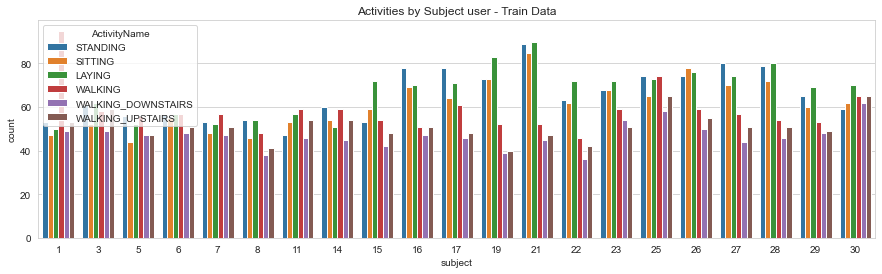

In [49]:
#plot to display activities count by subject on training data
sns.set_style('whitegrid')
plt.figure(figsize=(15,4))
plt.title('Activities by Subject user - Train Data', fontsize=12)
sns.countplot(x='subject',hue='ActivityName', data = df_train)
plt.show()

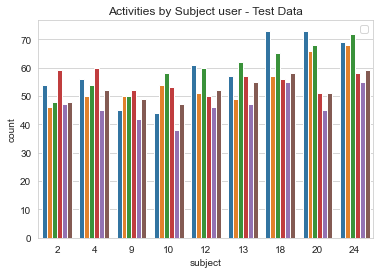

In [53]:
#plot to display activities count by subject on test data
plt.figure(figsize=(6,4))
plt.title('Activities by Subject user - Test Data', fontsize=12)
sns.countplot(x='subject',hue='ActivityName', data = df_test)
plt.legend("")
plt.show()

In [63]:
from matplotlib import gridspec

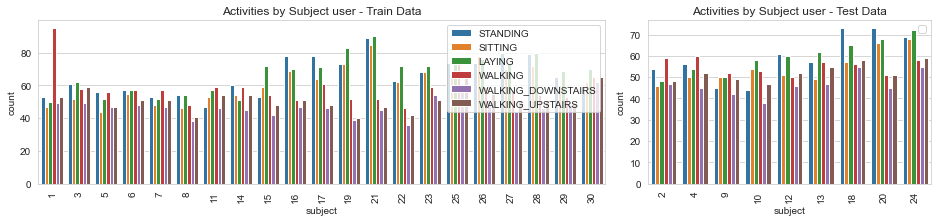

In [70]:
# Plot count of activities per subject 
fig=plt.figure(figsize=(16,3))
spec=gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2,1], wspace=0.1)

ax1=fig.add_subplot(spec[0])
# plt.subplot(1,2,1, gridspec_kw={'height_ratios':[2,1]})
plt.title('Activities by Subject user - Train Data', fontsize=12)
sns.countplot(x='subject',hue='ActivityName', data = df_train)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
# plt.subplot(1,2,2)
ax2=fig.add_subplot(spec[1])
plt.title('Activities by Subject user - Test Data', fontsize=12)
sns.countplot(x='subject',hue='ActivityName', data = df_test)
plt.xticks(rotation=90)
plt.legend("")
plt.show()

There is no imbalance in the data, the amount of data per subject activities are uniformly distributed

In [129]:
df=round(df_train.ActivityName.value_counts(normalize=True),2)
df

LAYING                0.19
STANDING              0.19
SITTING               0.17
WALKING               0.17
WALKING_UPSTAIRS      0.15
WALKING_DOWNSTAIRS    0.13
Name: ActivityName, dtype: float64

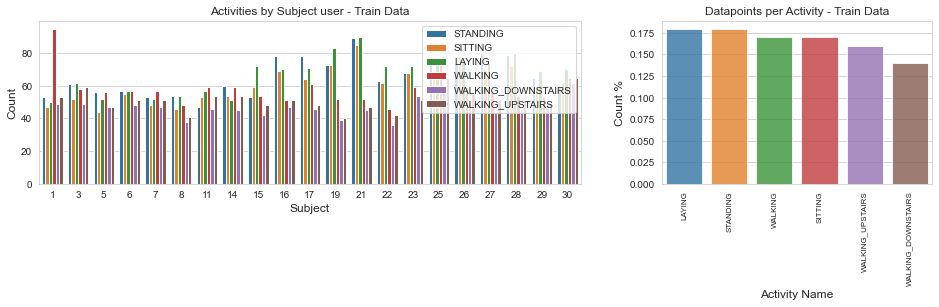

In [136]:
# Plot count of activities per subject 
fig=plt.figure(figsize=(16,3))
spec=gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2,1], wspace=0.2)

ax1=fig.add_subplot(spec[0])
# plt.subplot(1,2,1, gridspec_kw={'height_ratios':[2,1]})
plt.title('Activities by Subject user - Train Data', fontsize=12)
sns.countplot(x='subject',hue='ActivityName', data = df_train)
plt.xlabel('Subject', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(loc='upper right')
plt.xticks( fontsize=10)
# plt.subplot(1,2,2)
ax2=fig.add_subplot(spec[1])
plt.title('Datapoints per Activity - Train Data', fontsize=12)
sns.barplot(df.index, df.values, alpha=0.8)
plt.xlabel('Activity Name', fontsize=12)
plt.ylabel('Count %', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [135]:
df=round(df_test.ActivityName.value_counts(normalize=True),2)
df

LAYING                0.18
STANDING              0.18
WALKING               0.17
SITTING               0.17
WALKING_UPSTAIRS      0.16
WALKING_DOWNSTAIRS    0.14
Name: ActivityName, dtype: float64

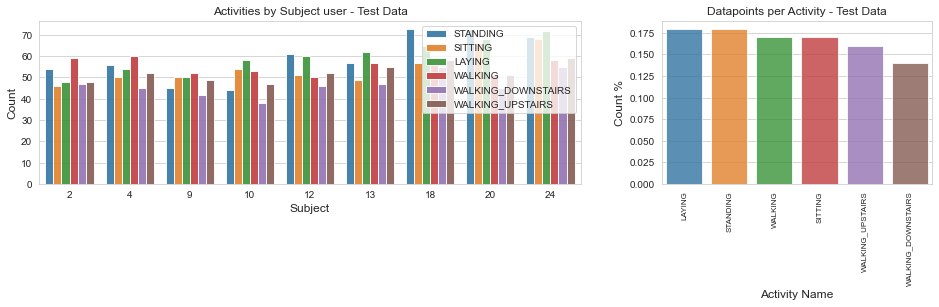

In [139]:
# Plot count of activities per subject 
fig=plt.figure(figsize=(16,3))
spec=gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2,1], wspace=0.2)

ax1=fig.add_subplot(spec[0])
# plt.subplot(1,2,1, gridspec_kw={'height_ratios':[2,1]})
plt.title('Activities by Subject user - Test Data', fontsize=12)
sns.countplot(x='subject',hue='ActivityName', data = df_test, alpha=0.9)
plt.xlabel('Subject', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(loc='upper right')
plt.xticks( fontsize=10)
# plt.subplot(1,2,2)
ax2=fig.add_subplot(spec[1])
plt.title('Datapoints per Activity - Test Data', fontsize=12)
# sns.countplot(df_test.ActivityName)
sns.barplot(df.index, df.values, alpha=0.8)
plt.xlabel('Activity Name', fontsize=12)
plt.ylabel('Count %', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.show()

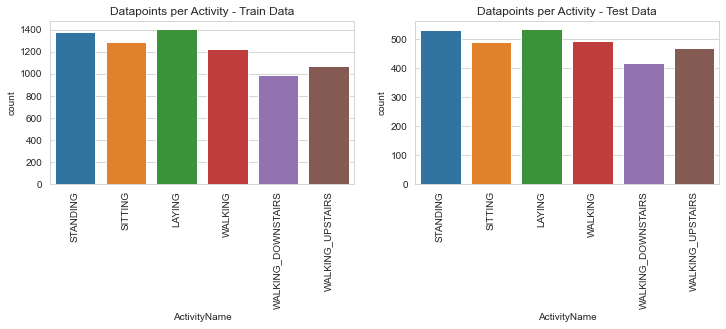

In [56]:
# Plot count of activities per actitytype
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title('Datapoints per Activity - Train Data', fontsize=12)
sns.countplot(df_train.ActivityName)
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title('Datapoints per Activity - Test Data', fontsize=12)
sns.countplot(df_test.ActivityName)
plt.xticks(rotation=90)
plt.show()

In [88]:
round(100*df_train['ActivityName'].value_counts(normalize=True),2).transform(lambda x: str(x)+' %')

LAYING                19.14 %
STANDING              18.69 %
SITTING               17.49 %
WALKING               16.68 %
WALKING_UPSTAIRS      14.59 %
WALKING_DOWNSTAIRS    13.41 %
Name: ActivityName, dtype: object

In [89]:
round(100*df_test['ActivityName'].value_counts(normalize=True),2).transform(lambda x: str(x)+' %')

LAYING                18.22 %
STANDING              18.05 %
WALKING               16.83 %
SITTING               16.66 %
WALKING_UPSTAIRS      15.98 %
WALKING_DOWNSTAIRS    14.25 %
Name: ActivityName, dtype: object

The overall activity counts per activity types are almost identicial, uniformly distrubuted 

In [49]:
#display the unique values in each attributes to check if any attributed of type categorical in nature
df_train.nunique().sort_values()

ActivityName                            6
Activity                                6
subject                                21
fBodyGyro_maxInds_Z                    25
fBodyAcc_maxInds_Z                     26
fBodyAcc_maxInds_Y                     26
fBodyBodyGyroMag_maxInds               27
fBodyGyro_maxInds_X                    27
fBodyGyro_maxInds_Y                    29
fBodyAcc_maxInds_X                     29
fBodyAccMag_maxInds                    29
fBodyAccJerk_maxInds_Y                 48
fBodyAccJerk_maxInds_X                 48
fBodyAccJerk_maxInds_Z                 49
fBodyBodyGyroJerkMag_maxInds           52
fBodyBodyAccJerkMag_maxInds            57
tGravityAcc_entropy_Y                1179
tGravityAcc_entropy_Z                2710
tGravityAcc_entropy_X                3168
fBodyAccJerk_entropy_X               3313
fBodyAccJerk_entropy_Z               3325
fBodyAccJerk_entropy_Y               3359
fBodyBodyAccJerkMag_entropy          3396
fBodyAcc_entropy_X                

#### Univariate Analysis

*Accelerometer signal attributes*

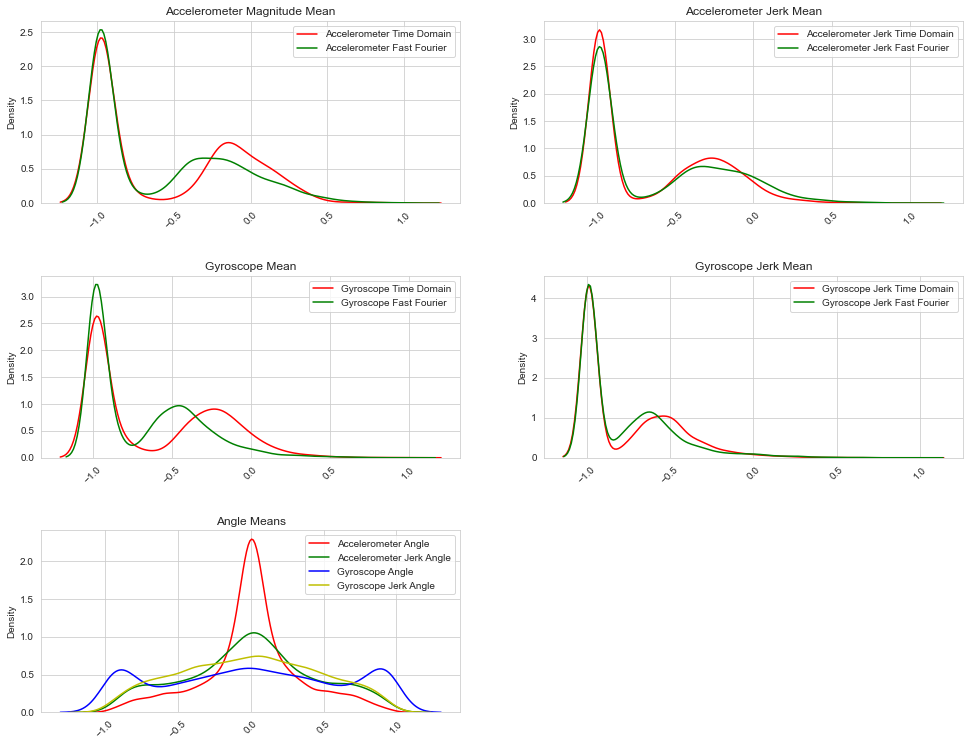

In [50]:
# Distribution of signal attribute means
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
sns.distplot(df_train['tBodyAccMag_mean'], hist=False, color='r', label='Accelerometer Time Domain')
sns.distplot(df_train['fBodyAccMag_mean'], hist=False, color='g', label='Accelerometer Fast Fourier')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Accelerometer Magnitude Mean')
plt.legend(loc='upper right')

plt.subplot(3,2,2)
sns.distplot(df_train['tBodyAccJerkMag_mean'], hist=False, color='r', label='Accelerometer Jerk Time Domain')
sns.distplot(df_train['fBodyBodyAccJerkMag_mean'], hist=False, color='g', label='Accelerometer Jerk Fast Fourier')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Accelerometer Jerk Mean')
plt.legend(loc='upper right')

plt.subplot(3,2,3)
sns.distplot(df_train['tBodyGyroMag_mean'], hist=False, color='r', label='Gyroscope Time Domain')
sns.distplot(df_train['fBodyBodyGyroMag_mean'], hist=False, color='g', label='Gyroscope Fast Fourier')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Gyroscope Mean')
plt.legend(loc='upper right')

plt.subplot(3,2,4)
sns.distplot(df_train['tBodyGyroJerkMag_mean'], hist=False, color='r', label='Gyroscope Jerk Time Domain')
sns.distplot(df_train['fBodyBodyGyroJerkMag_mean'], hist=False, color='g', label='Gyroscope Jerk Fast Fourier')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Gyroscope Jerk Mean')
plt.legend(loc='upper right')

plt.subplot(3,2,5)
sns.distplot(df_train['angletBodyAccMeangravity'], hist=False, color='r', label='Accelerometer Angle')
sns.distplot(df_train['angletBodyAccJerkMeangravityMean'], hist=False, color='g', label='Accelerometer Jerk Angle')
sns.distplot(df_train['angletBodyGyroMeangravityMean'], hist=False, color='b', label='Gyroscope Angle')
sns.distplot(df_train['angletBodyGyroJerkMeangravityMean'], hist=False, color='y', label='Gyroscope Jerk Angle')
# sns.distplot(df_train['angleXgravityMean'], hist=False, color='c', label='Accelerometer Gravity')
# sns.distplot(df_train['angleYgravityMean'], hist=False, color='k', label='Accelerometer Gravity')
# sns.distplot(df_train['angleZgravityMean'], hist=False, color='m', label='Accelerometer Gravity')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Angle Means')
plt.legend(loc='upper right')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.show()

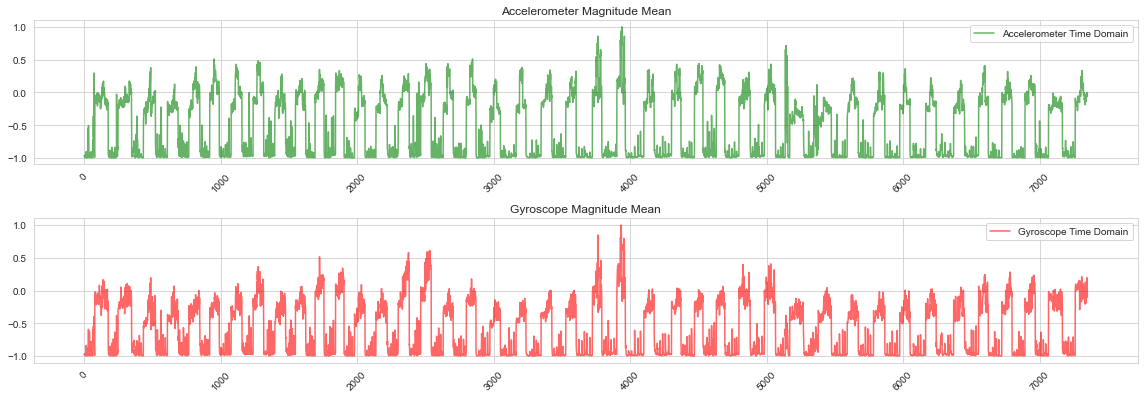

In [162]:
# Distribution of signal attribute means
plt.figure(figsize=(16,8))
plt.subplot(3,1,1)
plt.plot(df_train['tBodyAccMag_mean'], color='g', label='Accelerometer Time Domain', alpha=0.6)
# plt.plot(df_train['fBodyAccMag_mean'], color='g', label='Accelerometer Fast Fourier')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Accelerometer Magnitude Mean')
plt.legend(loc='upper right')


plt.subplot(3,1,2)
plt.plot(df_train['tBodyGyroMag_mean'], color='r', label='Gyroscope Time Domain', alpha=0.6)
# sns.distplot(df_train['fBodyBodyGyroMag_mean'], hist=False, color='g', label='Gyroscope Fast Fourier')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Gyroscope Magnitude Mean')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

#### Correlation of attributes with Activities

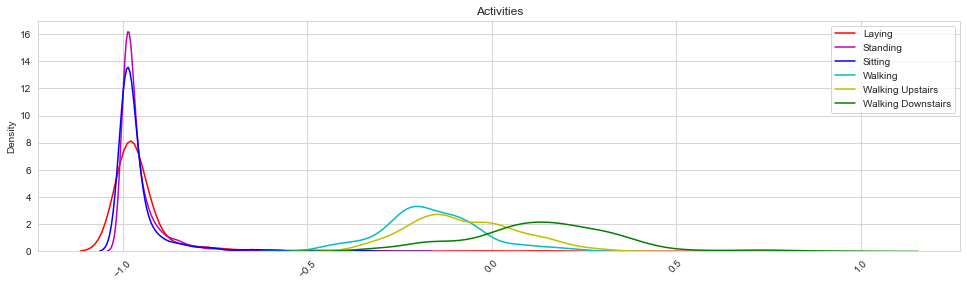

In [51]:
# Distribution of tBodyAccMag_mean by Activities

plt.figure(figsize=(16,4))

sns.distplot(df_train[df_train['ActivityName']=='LAYING']['tBodyAccMag_mean'], hist=False, color='r', label='Laying')
sns.distplot(df_train[df_train['ActivityName']=='STANDING']['tBodyAccMag_mean'], hist=False, color='m', label='Standing')
sns.distplot(df_train[df_train['ActivityName']=='SITTING']['tBodyAccMag_mean'], hist=False, color='b', label='Sitting')

sns.distplot(df_train[df_train['ActivityName']=='WALKING']['tBodyAccMag_mean'], hist=False, color='c', label='Walking')
sns.distplot(df_train[df_train['ActivityName']=='WALKING_UPSTAIRS']['tBodyAccMag_mean'], hist=False, color='y', label='Walking Upstairs')
sns.distplot(df_train[df_train['ActivityName']=='WALKING_DOWNSTAIRS']['tBodyAccMag_mean'], hist=False, color='g', label='Walking Downstairs')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Activities')
plt.legend(loc='upper right')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.show()

In [52]:
# Distribution of tBodyAccMag_mean by Activities Group

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.distplot(df_train[df_train['ActivityName']=='LAYING']['tBodyAccMag_mean'], hist=False, color='r', label='Laying')
sns.distplot(df_train[df_train['ActivityName']=='STANDING']['tBodyAccMag_mean'], hist=False, color='m', label='Standing')
sns.distplot(df_train[df_train['ActivityName']=='SITTING']['tBodyAccMag_mean'], hist=False, color='b', label='Sitting')
plt.xticks(rotation=45)
plt.xlim(-1.2,1.2)
plt.xlabel('')
plt.title('Stationary Activities')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
sns.distplot(df_train[df_train['ActivityName']=='WALKING']['tBodyAccMag_mean'], hist=False, color='c', label='Walking')
sns.distplot(df_train[df_train['ActivityName']=='WALKING_UPSTAIRS']['tBodyAccMag_mean'], hist=False, color='y', label='Walking Upstairs')
sns.distplot(df_train[df_train['ActivityName']=='WALKING_DOWNSTAIRS']['tBodyAccMag_mean'], hist=False, color='g', label='Walking Downstairs')
plt.xticks(rotation=45)
plt.xlim(-1.2,1.2)
plt.xlabel('')
plt.title('Moving Activities')
plt.legend(loc='upper right')


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.show()

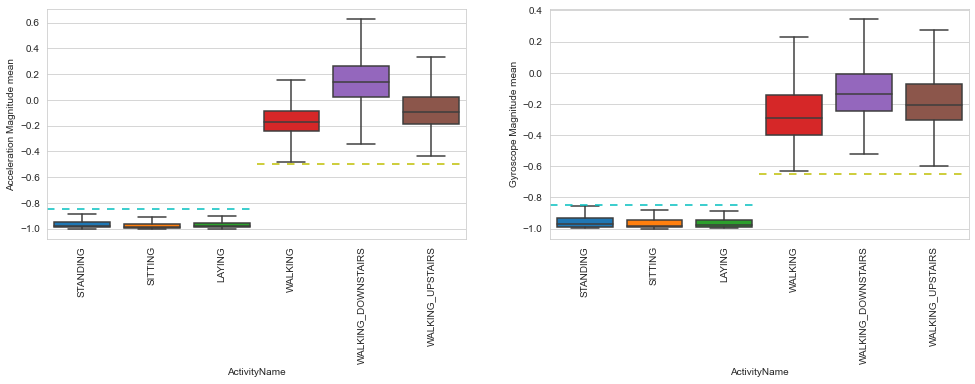

In [165]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.boxplot(x='ActivityName', y='tBodyAccMag_mean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.5, xmin=0.5 ,dashes=(5,5), c='y')
plt.axhline(y=-0.85, xmin=0, xmax=0.5, dashes=(5,5), c='c')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(x='ActivityName', y='tBodyGyroMag_mean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Gyroscope Magnitude mean')
plt.axhline(y=-0.65, xmin=0.5 ,dashes=(5,5), c='y')
plt.axhline(y=-0.85, xmin=0, xmax=0.5, dashes=(5,5), c='c')
plt.xticks(rotation=90)



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.show()

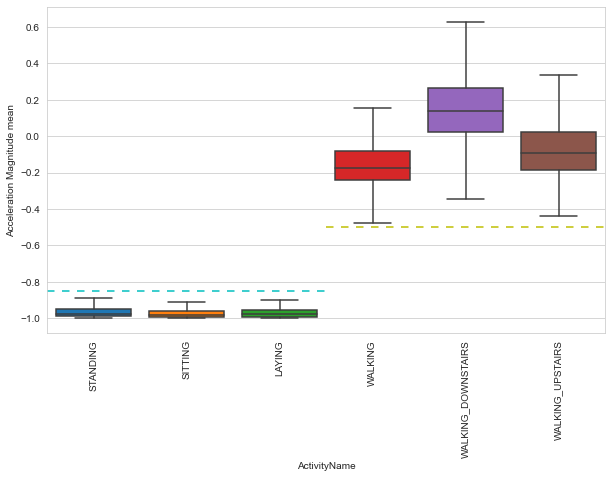

In [53]:
# Boxplot of tBodyAccMag_mean by Activities
plt.figure(figsize=(10,6))
sns.boxplot(x='ActivityName', y='tBodyAccMag_mean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.5, xmin=0.5 ,dashes=(5,5), c='y')
plt.axhline(y=-0.85, xmin=0, xmax=0.5, dashes=(5,5), c='c')
plt.xticks(rotation=90)
plt.show()

In [54]:
# Boxplot of tBodyGyroMag_mean by Activities
plt.figure(figsize=(10,6))
sns.boxplot(x='ActivityName', y='tBodyGyroMag_mean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.65, xmin=0.5 ,dashes=(5,5), c='y')
plt.axhline(y=-0.85, xmin=0, xmax=0.5, dashes=(5,5), c='c')
plt.xticks(rotation=90)
# plt.title('Body Gyro Magnitude Mean')
plt.show()

In [55]:
# Boxplot of tBodyAccJerkMag_mean by Activities
plt.figure(figsize=(10,6))
sns.boxplot(x='ActivityName', y='tBodyAccJerkMag_mean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.8, xmin=0.5 ,dashes=(5,5), c='y')
plt.axhline(y=-0.95, xmin=0, xmax=0.5, dashes=(5,5), c='c')
plt.xticks(rotation=90)
plt.show()

In [56]:
# Boxplot of tBodyGyroJerkMag_mean by Activities
plt.figure(figsize=(10,6))
sns.boxplot(x='ActivityName', y='tBodyGyroJerkMag_mean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.85, xmin=0.5 ,dashes=(5,5), c='y')
plt.axhline(y=-0.95, xmin=0, xmax=0.5, dashes=(5,5), c='c')
plt.xticks(rotation=90)
plt.show()

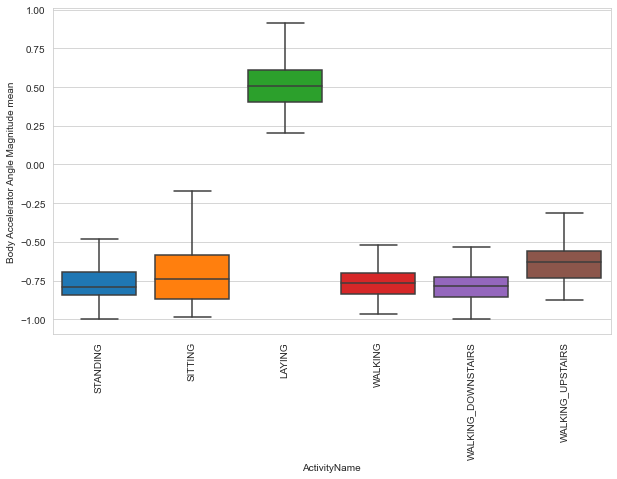

In [57]:
# Boxplot of angleXgravityMean by Activities
plt.figure(figsize=(10,6))
sns.boxplot(x='ActivityName', y='angleXgravityMean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Body Accelerator Angle Magnitude mean')
# plt.axhline(y=0.2, xmin=0.5 ,dashes=(5,5), c='y')
# plt.axhline(y=-0.1, xmin=0, xmax=0.5, dashes=(5,5), c='c')
plt.xticks(rotation=90)
plt.show()

In [58]:
# Boxplot of angleYgravityMean by Activities
plt.figure(figsize=(10,6))
sns.boxplot(x='ActivityName', y='angleYgravityMean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Body Accelerator Angle Magnitude mean')
# plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='y')
# plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='c')
plt.xticks(rotation=90)
plt.show()

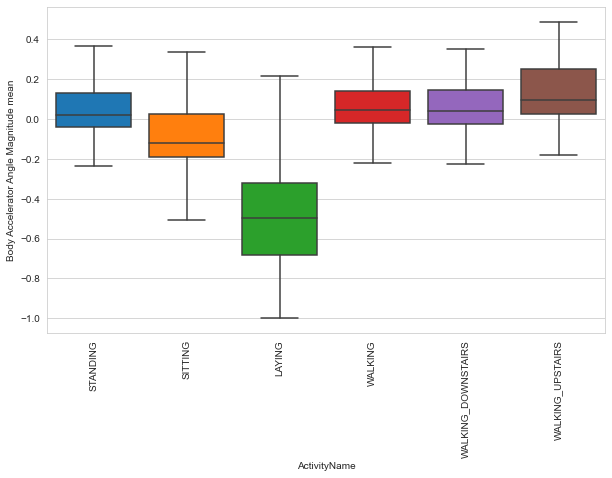

In [59]:
# Boxplot of angleZgravityMean by Activities
plt.figure(figsize=(10,6))
sns.boxplot(x='ActivityName', y='angleZgravityMean',data=df_train, showfliers=False, saturation=1)
plt.ylabel('Body Accelerator Angle Magnitude mean')
# plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='y')
# plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='c')
plt.xticks(rotation=90)
plt.show()

#### Dimensionality Reduction and Visualization of Data

**t-SNE**

In [60]:
# performs t-sne with different perplexity values and their respective plots

def apply_tsne(X, y, perplexities, n_iter, img_name_prefix='t-sne'):
    
    for index,perplexity in enumerate(perplexities):
        # perform t-sne
        print('\nPerplexity: {},   Max Iterations: {}'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X)
        print('Done..')
        
        # prepare the data for seaborn         
        print('Creating plot for this t-sne visualization..')
        df_tsne = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y})
        
        
        # draw the plot in appropriate place in the grid
        sns.lmplot(data=df_tsne, x='x', y='y', hue='label', fit_reg=False, size=8,\
                   markers=['o','s','>','P', '*','X'])
        plt.title("Perplexity : {}, Max Iterations : {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('Saving plot as image in current directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')


In [61]:
X = df_train.drop(['subject', 'Activity','ActivityName'], axis=1)
y = df_train['ActivityName']

In [62]:
n_iter=1000

In [63]:
# # TODO: Need to be deleted, only for testing purpose
# X = X[:500]
# y = y[:500]
# n_iter=10


Perplexity: 2,   Max Iterations: 1000
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.572s...
[t-SNE] Computed neighbors for 7352 samples in 38.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.635854
[t-SNE] Computed conditional probabilities in 0.031s
[t-SNE] Iteration 50: error = 124.6576614, gradient norm = 0.0282318 (50 iterations in 2.216s)
[t-SNE] Iteration 100: error = 107.3519135, gradient norm = 0.0285739 (50 iterations in 1.808s)
[t-SNE] Iteration 1

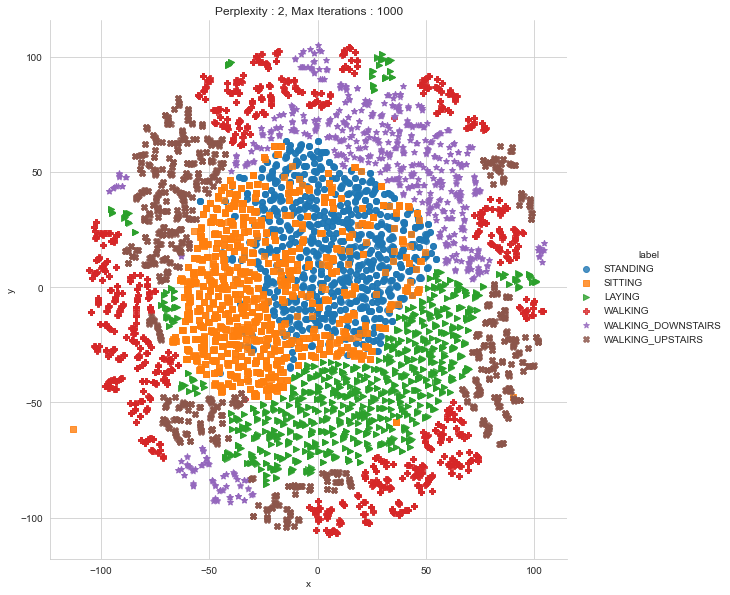

Done

Perplexity: 5,   Max Iterations: 1000
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.393s...
[t-SNE] Computed neighbors for 7352 samples in 29.950s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.961265
[t-SNE] Computed conditional probabilities in 0.038s
[t-SNE] Iteration 50: error = 113.9830017, gradient norm = 0.0211284 (50 iterations in 1.648s)
[t-SNE] Iteration 100: error = 97.5087509, gradient norm = 0.0135326 (50 iterations in 1.772s)
[t-SNE] Iterat

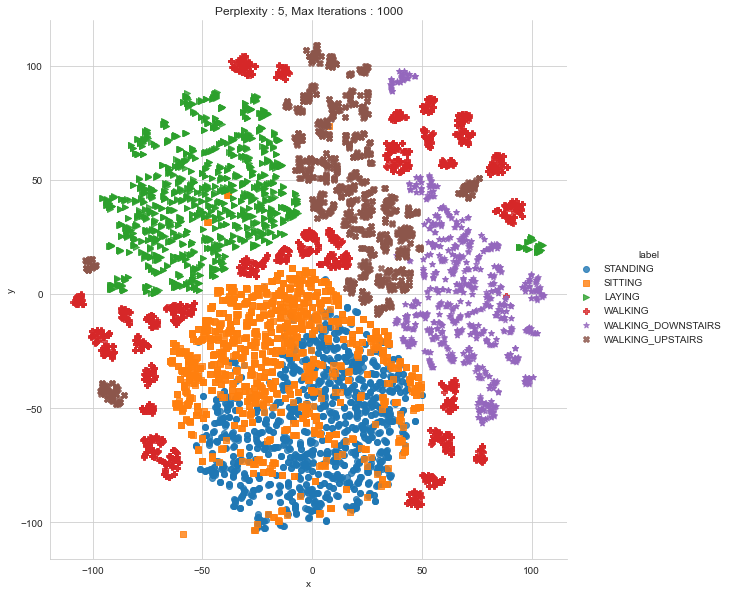

Done

Perplexity: 10,   Max Iterations: 1000
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.399s...
[t-SNE] Computed neighbors for 7352 samples in 30.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.133828
[t-SNE] Computed conditional probabilities in 0.065s
[t-SNE] Iteration 50: error = 105.6947479, gradient norm = 0.0213214 (50 iterations in 1.966s)
[t-SNE] Iteration 100: error = 90.1230621, gradient norm = 0.0094803 (50 iterations in 1.812s)
[t-SNE] Itera

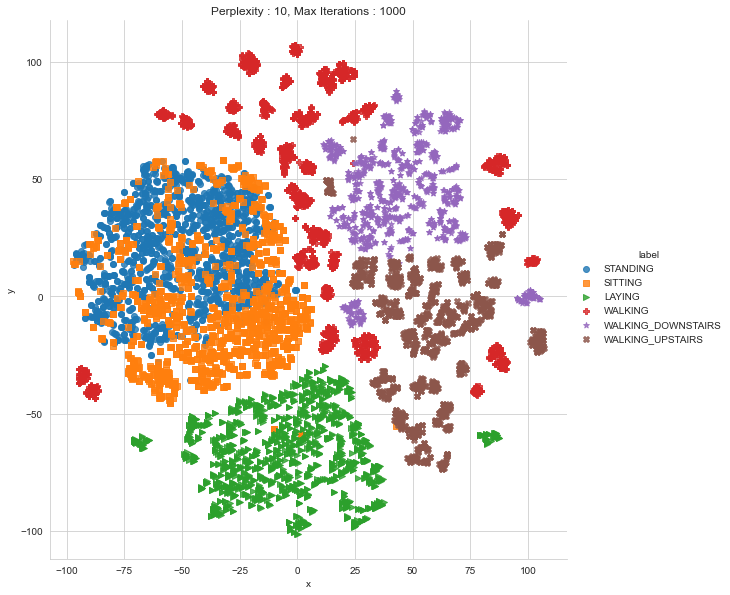

Done

Perplexity: 20,   Max Iterations: 1000
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.405s...
[t-SNE] Computed neighbors for 7352 samples in 30.605s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.274335
[t-SNE] Computed conditional probabilities in 0.147s
[t-SNE] Iteration 50: error = 97.6324005, gradient norm = 0.0196931 (50 iterations in 1.860s)
[t-SNE] Iteration 100: error = 83.9311981, gradient norm = 0.0059904 (50 iterations in 2.016s)
[t-SNE] Iterat

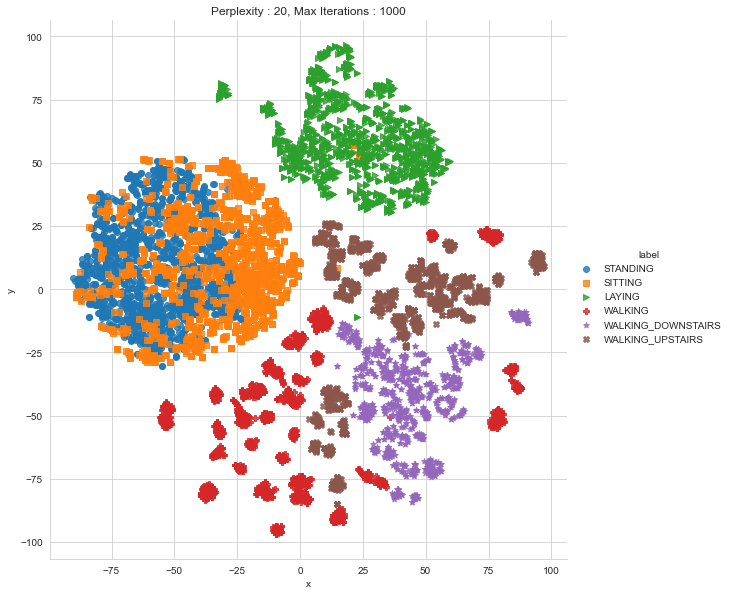

Done

Perplexity: 40,   Max Iterations: 1000
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.381s...
[t-SNE] Computed neighbors for 7352 samples in 31.875s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.399086
[t-SNE] Computed conditional probabilities in 0.261s
[t-SNE] Iteration 50: error = 87.6818771, gradient norm = 0.0305839 (50 iterations in 2.105s)
[t-SNE] Iteration 100: error = 78.0901108, gradient norm = 0.0042316 (50 iterations in 2.626s)
[t-SNE] Itera

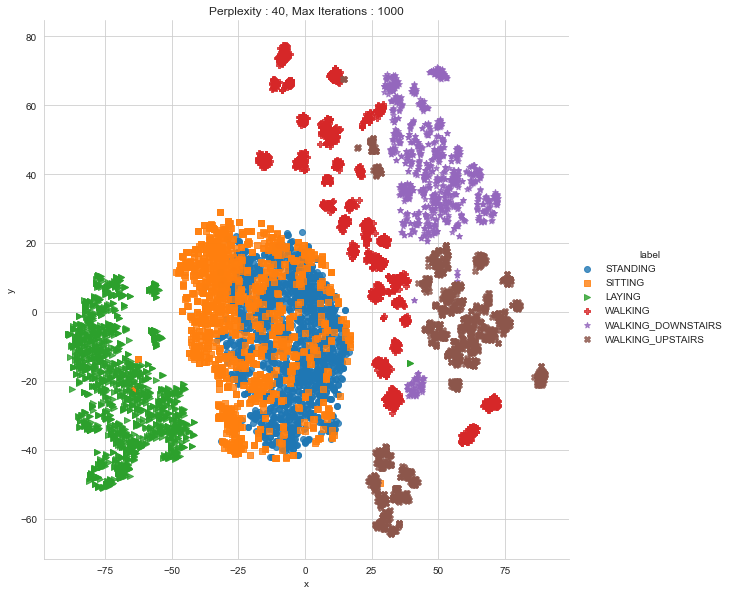

Done

Perplexity: 50,   Max Iterations: 1000
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.405s...
[t-SNE] Computed neighbors for 7352 samples in 31.837s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.437672
[t-SNE] Computed conditional probabilities in 0.364s
[t-SNE] Iteration 50: error = 84.8691483, gradient norm = 0.0327745 (50 iterations in 2.255s)
[t-SNE] Iteration 100: error = 75.6575546, gradient norm = 0.0039511 (50 iterations in 2.454s)
[t-SNE] Itera

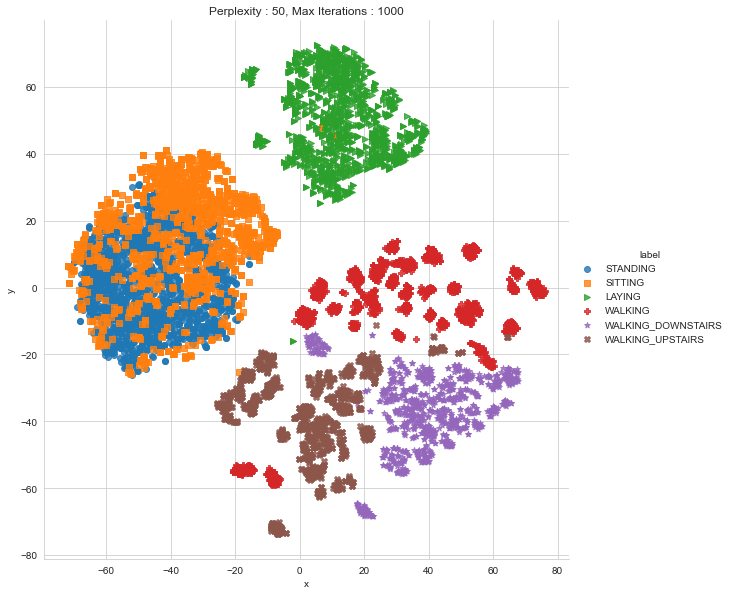

Done
Time taken to run: 418.872754573822 seconds


In [64]:
# apply tsne and plot the result
start = time()

# TODO: Need to be uncommented
apply_tsne(X = X, y=y,n_iter=n_iter, perplexities =[2,5,10,20,40,50])

print(f'Time taken to run: {time() - start} seconds')

In [179]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(mpimg.imread('./Images/t-SNE-2.png'))
plt.subplot(1,2,2)
plt.imshow(mpimg.imread('./Images/t-SNE-20.png'))
# plt.subplot(2,2,3)
# plt.imshow(mpimg.imread('./Images/t-SNE-50.png'))
plt.show()


In [65]:
trainX.shape, trainy.shape

((7352, 128, 9), (7352, 1))

In [68]:
# load mapping of rows to subjects
sub_map = load_file(filedir+'train/subject_train.txt')
train_subjects = unique(sub_map)
print('train subjects',train_subjects)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print('subject id:',sub_id, ', X shape:',subX.shape, ', y shape:', suby.shape)

train subjects [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
subject id: 1 , X shape: (347, 128, 9) , y shape: (347, 1)


In [69]:
# plot the data for one subject
def plot_subject(X, y):
    plt.figure(figsize=(16,12))
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]),'-g', color='r')
        plt.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]),'-g', color='g')
        plt.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]),'-g', color='m')
        plt.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    plt.subplot(n, 1, n)
    plt.plot(y, color='b')
    plt.title('activity', y=0, loc='left')
    plt.show()



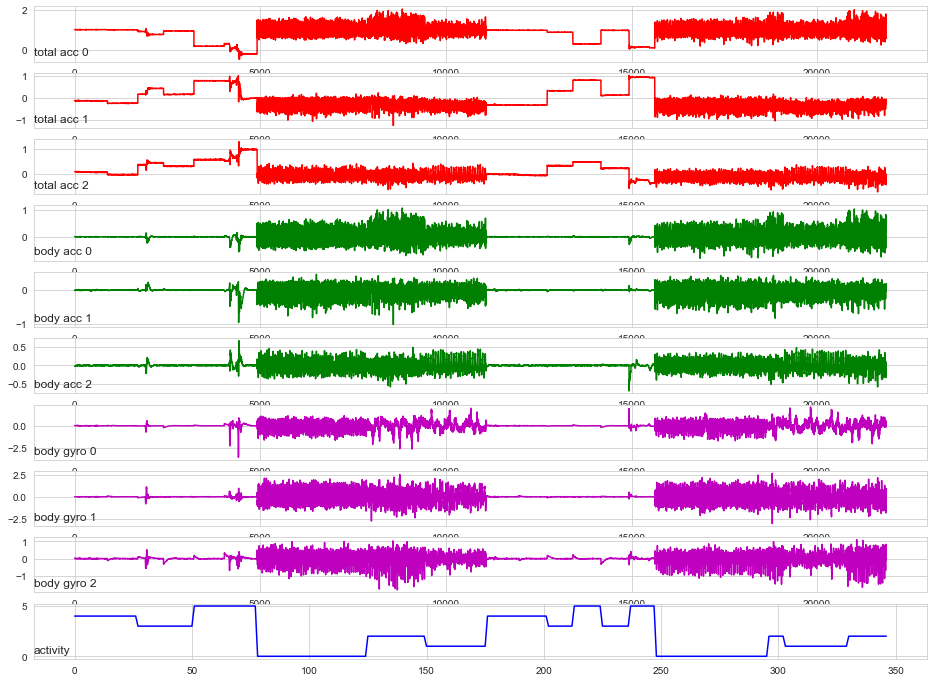

In [70]:
# plot data for selected subject
plot_subject(subX, suby)

In [71]:
# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, n=10):
    plt.figure(figsize=(16,12))
    # get unique subjects
    subject_ids = unique(sub_map[:,0])
    # enumerate subjects
    xaxis = None
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # total acc
        for i in range(3):
            ax = plt.subplot(n, 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            plt.hist(to_series(subX[:,:,i]), bins=100)

    

    plt.show()

In [72]:
# load training dataset
X, y = load_dataset_group('train',filedir)
# load mapping of rows to subjects
sub_map = load_file(filedir+'train/subject_train.txt')


In [73]:
X.shape, y.shape

((7352, 128, 9), (7352, 1))

In [74]:
# plot histograms for subjects
plot_subject_histograms(X, y, sub_map, n=5)

In [75]:
# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}


# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    plt.figure(figsize=(16,12))
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = plt.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            plt.hist(to_series(grouped[act_id][:,:,3+i]), bins=100)
            plt.title('activity '+str(act_id), y=0, loc='left')
    plt.show()

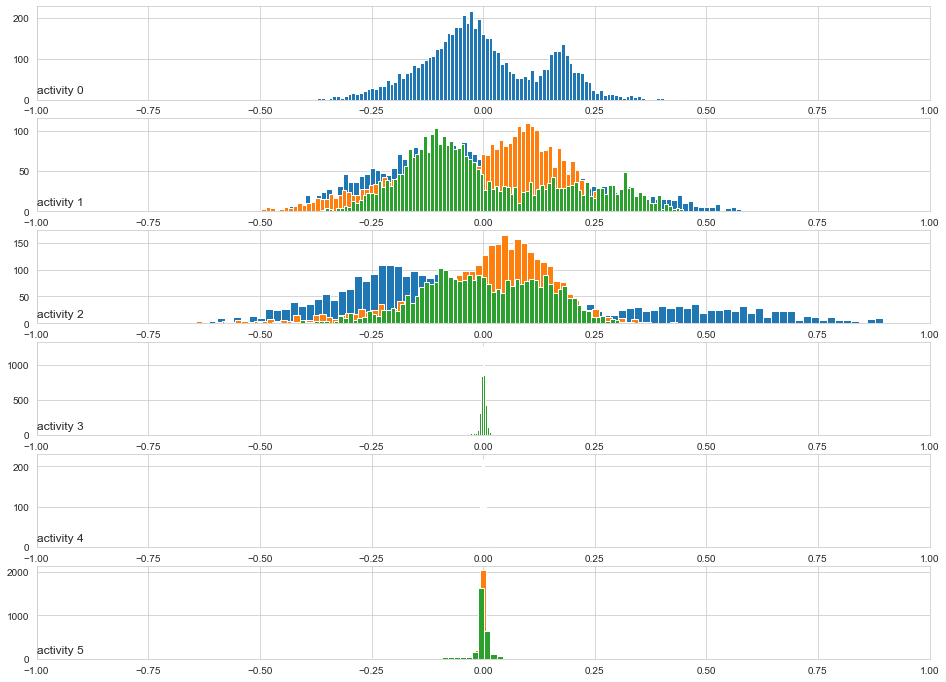

In [76]:
# plot data for subject
plot_activity_histograms(subX, suby)

## 4. Model

In [45]:
#load dataset with onehot enocoded y values
trainX, trainy, testX, testy = load_dataset_onehot(filedir)

trainX.shape: (7352, 128, 9) trainy.shape: (7352, 1)
testX.shape: (2947, 128, 9) testy.shape: (2947, 1)
trainX Shape: (7352, 128, 9) trainy shape: (7352, 6) testX shape: (2947, 128, 9) testy shape: (2947, 6)


In [46]:
trainX.shape, trainy.shape, testX.shape, testy.shape 

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [81]:
# TODO: Only for intial coding, required to be removed

# trainX=trainX[:500]
# trainy=trainy[:500]

# testX=testX[:100]
# testy=testy[:100]


In [47]:
trainX.shape, trainy.shape, testX.shape, testy.shape 

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [48]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [49]:
n_timesteps, n_features, n_outputs

(128, 9, 6)

In [87]:
n_repeats, epochs, batch_size = 5, 20, 32 # TODO: reset the values

In [51]:
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.models import load_model

In [52]:
#dislay the model metrics such as accuracy, precision, recall, f1-sore
def display_metrics(model, X, y):

    # predict probabilities for test set
    predy = model.predict(X, verbose=0)
    predy_classes = np.argmax(predy, axis=1)

    testy_classes=np.argmax(y, axis=1)
    
#     cm=confusion_matrix(testy_classes,predy_classes)
#     print('Confusion Matrix:')
#     print(cm)

    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(testy_classes, predy_classes)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(testy_classes, predy_classes, average='micro')
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(testy_classes, predy_classes, average='micro')
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testy_classes, predy_classes, average='micro')
    print('F1 score: %f' % f1)


In [53]:
#dislay the model metrics such as accuracy, precision, recall, f1-sore
def display_metrics_file(filepath, X, y):

    model = load_model(filepath)
    
    # predict probabilities for test set
    predy = model.predict(X, verbose=0)
    predy_classes = np.argmax(predy, axis=1)

    testy_classes=np.argmax(y, axis=1)
    
#     cm=confusion_matrix(testy_classes,predy_classes)
#     print('Confusion Matrix:')
#     print(cm)

    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(testy_classes, predy_classes)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(testy_classes, predy_classes, average='micro')
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(testy_classes, predy_classes, average='micro')
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testy_classes, predy_classes, average='micro')
    print('F1 score: %f' % f1)


In [118]:
# common function to summarize scores in detail
def plot_history(history):
    
    
    # plot train and validation loss across multiple runs
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], color='blue', label='Train')
    plt.plot(history.history['val_loss'], color='orange', label='Validation')
    plt.title('model train vs validation loss')
    plt.xticks(range(0,epochs+1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)
    # plot of train and validation scores vs tree depth
    plt.plot(history.history['accuracy'], '-o', label='Train')
    plt.plot(history.history['val_accuracy'] , '-o', label='Validation')
    plt.title('model train vs validation accuracy')
    plt.xticks(range(0,epochs+1))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
   
    plt.grid()
    plt.show()

In [55]:
# fit and evaluate a model
def evaluate_model(model):
    verbose = 1
    # fit network
    print('')
    print('fit the model on the training data')
    history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    print('evaluating the model')
    
    _, train_accuracy=model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    print('train accuracy',train_accuracy)

    _, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    print('test accuracy',test_accuracy)
    
    return train_accuracy, test_accuracy

In [56]:
# fit and evaluate a model with detailed hsitory display
def evaluate_model_det(model, callbacks):
    # fit network
    verbose=1
    print('')
    print('>>>>>fit the model on the training data')
    train_history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2, callbacks=callbacks)
    
    plot_history(train_history)
     
    # evaluate model
    print('')
    print('>>>>>evaluating the model on the test data')
    test_history = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    return train_history, test_history

In [57]:
# common function to summarize scores
def summarize_results(train_scores, test_scores):
    
    print('')
    m, s = mean(train_scores), std(train_scores)
    print('Train Accuracy: mean %.3f%%, std (+/-%.3f)' % (m, s))
    m, s = mean(test_scores), std(test_scores)
    print('Test Accuracy: mean %.3f%%, std (+/-%.3f)' % (m, s))
    

In [112]:
# common function to summarize scores in detail
def summarize_results_det(repeats, df_train_accuracies, df_train_losses, df_val_accuracies
                          , df_val_losses, df_test_accuracies, df_test_losses):
    
    
    # plot train and validation loss across multiple runs
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(df_train_losses, color='blue', label='Train')
    plt.plot(df_val_losses, color='orange', label='Validation')
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch of repeats')
    plt.grid()
    plt.show()
    
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    values=range(1,repeats+1)
    # plot of train and validation scores vs tree depth
    plt.plot(values, df_train_accuracies.mean(axis=0), '-o', label='Train')
    plt.plot(values, df_val_accuracies.mean(axis=0), '-o', label='Validation')
    plt.title('model train vs validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('repeats')
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)
    # plot of train and test scores vs tree depth
    plt.plot(values, df_train_accuracies.mean(axis=0), '-o', label='Train')
    plt.plot(values, df_test_accuracies.mean(axis=0), '-o', label='Test')
    plt.title('model train vs test accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('repeats')
    plt.legend()
    
    plt.grid()
    plt.show()


In [59]:
# run an experiment
def run_experiment(model,  repeats=2):
    # repeat experiment
    train_scores = list()
    test_scores = list()
    for r in range(repeats):
        train_score, test_score = evaluate_model(model)
        train_score = train_score * 100.0
        test_score = test_score * 100.0
        print('>repeat #%d: train score %.3f, test score %.3f' % (r+1, train_score, test_score))
        train_scores.append(train_score)
        test_scores.append(test_score)
        
        if test_score<0.5:
            break

        
    # summarize results
    summarize_results(train_scores, test_scores)

In [60]:
df_train_accuracies=pd.DataFrame()
df_train_losses=pd.DataFrame()
df_val_accuracies=pd.DataFrame()
df_val_losses=pd.DataFrame()

df_test_accuracies = pd.DataFrame()
df_test_losses=pd.DataFrame()

train_scores = list()
test_scores = list()
    

In [61]:
# run an experiment with detailed information displayed

def run_experiment_det(model,  callbacks, repeats=2):



    df_train_accuracies.drop(df_train_accuracies.columns, axis=1, inplace=True)
    df_train_accuracies.drop(index=df_train_accuracies.index, axis=0, inplace=True)
    
    df_train_losses.drop(df_train_losses.columns, axis=1, inplace=True)
    df_train_losses.drop(index=df_train_losses.index, axis=0, inplace=True)
    
    df_val_accuracies.drop(df_val_accuracies.columns, axis=1, inplace=True)
    df_val_accuracies.drop(index=df_val_accuracies.index, axis=0, inplace=True)
    
    df_val_losses.drop(df_val_losses.columns, axis=1, inplace=True)
    df_val_losses.drop(index=df_val_losses.index, axis=0, inplace=True)
    
    df_test_accuracies.drop(df_test_accuracies.columns, axis=1, inplace=True)
    df_test_accuracies.drop(index=df_test_accuracies.index, axis=0, inplace=True)
    
    df_test_losses.drop(df_test_losses.columns, axis=1, inplace=True)
    df_test_losses.drop(index=df_test_losses.index, axis=0, inplace=True)
    
    train_scores=[]
    test_scores=[]
        

    # repeat experiment
    for r in range(repeats):
        
        print('r:',r)
        train_history, test_history = evaluate_model_det(model, callbacks)
        
        df_train_accuracies[str(r)] = train_history.history['accuracy']
        df_train_losses[str(r)]     = train_history.history['loss']
        df_val_accuracies[str(r)] = train_history.history['val_accuracy'] 
        df_val_losses[str(r)]     = train_history.history['val_loss'] 
        
        df_test_accuracies[str(r)] = [test_history[1]] 
        df_test_losses[str(r)] = [test_history[0]]
        
        print('df_test_losses', df_test_losses)
        
    
        train_score, test_score = train_history.history['accuracy'][-1], test_history[1]
        
        train_scores.append(train_score)
        test_scores.append(test_score)
        print('')
        print('>repeat #%d: train accuracy %.3f, test accuracy %.3f' % (r+1, train_score, test_score))
        
        if test_score<0.5:
            break

        
    # summarize results
    summarize_results(train_scores, test_scores)
    
    # summarize results in detail
    summarize_results_det(repeats, df_train_accuracies, df_train_losses, df_val_accuracies
                          , df_val_losses, df_test_accuracies, df_test_losses)

#### LSTM

In [90]:
n_repeats, epochs, batch_size = 5, 20, 32 # TODO: reset the values

In [96]:
#build lstm model
def build_model_lstm():

    model = Sequential()
    model.add(LSTM(32, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_lstm_1_0.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath

In [97]:
model_lstm, callbacks, filepath = build_model_lstm()
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                5376      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 6)                 198       
                                                                 
Total params: 6,630
Trainable params: 6,630
Non-trainable params: 0
_________________________________________________________________


In [98]:
filepath

'./Model/my_best_model_lstm_1_0.hdf5'

r: 0

>>>>>fit the model on the training data
Epoch 1/20
181/184 [============================>.] - ETA: 0s - loss: 1.2612 - accuracy: 0.4772
Epoch 00001: val_loss improved from inf to 1.00326, saving model to ./Model\my_best_model_lstm_1_0.hdf5
184/184 [==============================] - 3s 14ms/step - loss: 1.2580 - accuracy: 0.4775 - val_loss: 1.0033 - val_accuracy: 0.5921
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.7692 - accuracy: 0.6504
Epoch 00002: val_loss improved from 1.00326 to 0.81836, saving model to ./Model\my_best_model_lstm_1_0.hdf5
184/184 [==============================] - 3s 14ms/step - loss: 0.7691 - accuracy: 0.6504 - val_loss: 0.8184 - val_accuracy: 0.5955
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.6228 - accuracy: 0.7005 ETA
Epoch 00003: val_loss improved from 0.81836 to 0.72603, saving model to ./Model\my_best_model_lstm_1_0.hdf5
184/184 [==============================] - 4s 21ms/step - loss: 0.6237 - accur

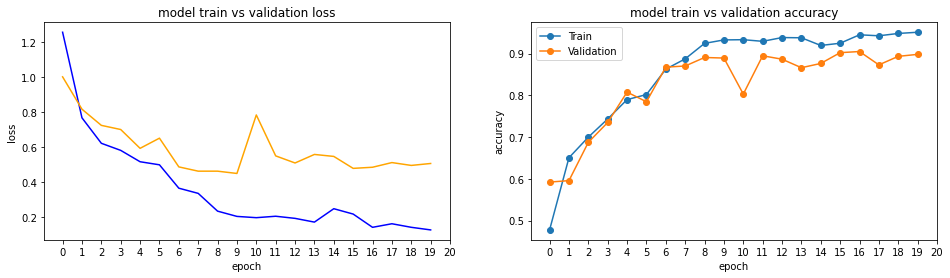


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.411013

>repeat #1: train accuracy 0.951, test accuracy 0.896
r: 1

>>>>>fit the model on the training data
Epoch 1/20
182/184 [============================>.] - ETA: 0s - loss: 0.1304 - accuracy: 0.9500
Epoch 00001: val_loss did not improve from 0.45132
184/184 [==============================] - 5s 26ms/step - loss: 0.1300 - accuracy: 0.9503 - val_loss: 0.4989 - val_accuracy: 0.9021
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9506
Epoch 00002: val_loss did not improve from 0.45132
184/184 [==============================] - 5s 25ms/step - loss: 0.1251 - accuracy: 0.9503 - val_loss: 0.5069 - val_accuracy: 0.9041
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.9537
Epoch 00003: val_loss did not improve from 0.45132
184/184 [==============================] - 5s 28ms/step - loss: 0.1172 - accuracy: 0.9534 - val_loss: 0.4980 - 

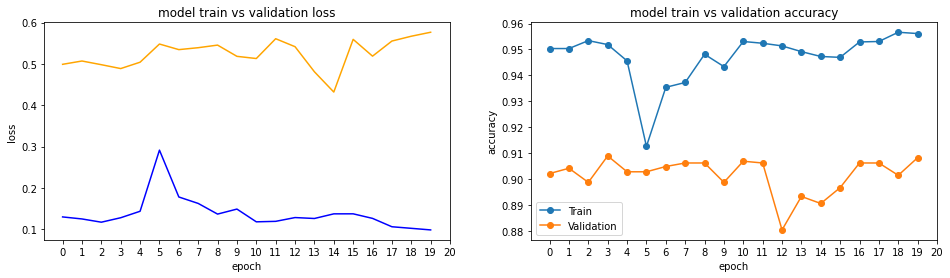


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.411013  0.439802

>repeat #2: train accuracy 0.956, test accuracy 0.890
r: 2

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.95 - ETA: 0s - loss: 0.1028 - accuracy: 0.9549
Epoch 00001: val_loss did not improve from 0.43186
184/184 [==============================] - 5s 27ms/step - loss: 0.1037 - accuracy: 0.9546 - val_loss: 0.5573 - val_accuracy: 0.9028
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9461
Epoch 00002: val_loss did not improve from 0.43186
184/184 [==============================] - 7s 39ms/step - loss: 0.1269 - accuracy: 0.9461 - val_loss: 0.5089 - val_accuracy: 0.9096
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.1032 - accuracy: 0.9544
Epoch 00003: val_loss did not improve from 0.43186
184/184 [==============================] - 6s 33m


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.411013  0.439802  0.442018

>repeat #3: train accuracy 0.956, test accuracy 0.915
r: 3

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.0947 - accuracy: 0.9575
Epoch 00001: val_loss did not improve from 0.43186
184/184 [==============================] - 6s 31ms/step - loss: 0.0946 - accuracy: 0.9575 - val_loss: 0.5835 - val_accuracy: 0.9055
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.1141 - accuracy: 0.9549
Epoch 00002: val_loss did not improve from 0.43186
184/184 [==============================] - 6s 30ms/step - loss: 0.1137 - accuracy: 0.9551 - val_loss: 0.5589 - val_accuracy: 0.8824
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9571
Epoch 00003: val_loss did not improve from 0.43186
184/184 [==============================] - 5s 29ms/step - loss: 0.0940 

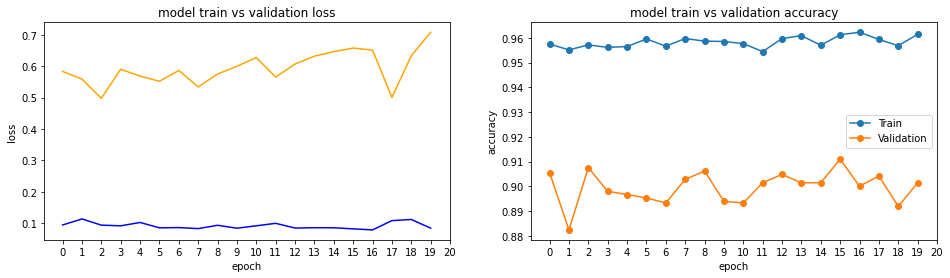


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.411013  0.439802  0.442018  0.464632

>repeat #4: train accuracy 0.961, test accuracy 0.917
r: 4

>>>>>fit the model on the training data
Epoch 1/20
182/184 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9526
Epoch 00001: val_loss did not improve from 0.43186
184/184 [==============================] - 6s 31ms/step - loss: 0.1060 - accuracy: 0.9527 - val_loss: 0.5229 - val_accuracy: 0.9341
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.1139 - accuracy: 0.9520
Epoch 00002: val_loss did not improve from 0.43186
184/184 [==============================] - 6s 31ms/step - loss: 0.1135 - accuracy: 0.9522 - val_loss: 0.6123 - val_accuracy: 0.9082
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9607
Epoch 00003: val_loss did not improve from 0.43186
184/184 [==============================] - 6s 30ms/

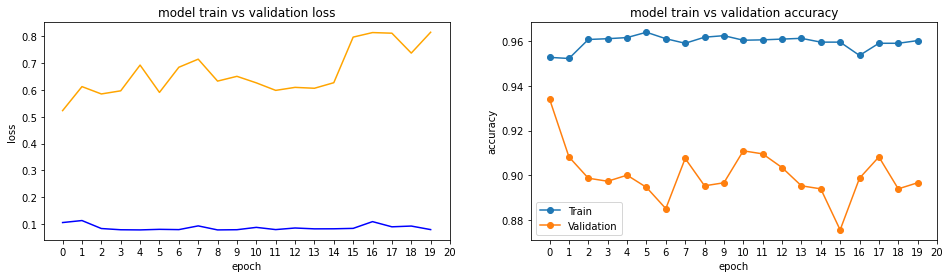


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.411013  0.439802  0.442018  0.464632  0.516298

>repeat #5: train accuracy 0.960, test accuracy 0.926

Train Accuracy: mean 0.957%, std (+/-0.004)
Test Accuracy: mean 0.909%, std (+/-0.013)


Total Time taken to train the model: 532.1930811405182 seconds, epochs=20, batch_size=32, repeats=5


In [99]:
# run the experiment
start_time = time()
# with tf.device("cpu:0"):
run_experiment_det(model_lstm, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [101]:
filepath

'./Model/my_best_model_lstm.hdf5'

In [102]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)
    
    

----Train Data----
Accuracy: 0.937704
Precision: 0.937704
Recall: 0.937704
F1 score: 0.937704

----Test Data---
Accuracy: 0.904988
Precision: 0.904988
Recall: 0.904988
F1 score: 0.904988


In [69]:
#build lstm model
def build_model_lstm():

    model = Sequential()
    model.add(LSTM(32, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.20))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_lstm_1_1.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath

In [70]:
model_lstm, callbacks, filepath = build_model_lstm()
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                5376      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 6,630
Trainable params: 6,630
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
180/184 [============================>.] - ETA: 0s - loss: 1.1575 - accuracy: 0.5135
Epoch 00001: val_loss improved from inf to 0.99382, saving model to ./Model\my_best_model_lstm.hdf5
184/184 [==============================] - 24s 15ms/step - loss: 1.1484 - accuracy: 0.5169 - val_loss: 0.9938 - val_accuracy: 0.6118
Epoch 2/20
182/184 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7043
Epoch 00002: val_loss improved from 0.99382 to 0.75868, saving model to ./Model\my_best_model_lstm.hdf5
184/184 [==============================] - 2s 12ms/step - loss: 0.6897 - accuracy: 0.7040 - val_loss: 0.7587 - val_accuracy: 0.7519
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.5640 - accuracy: 0.7871
Epoch 00003: val_loss did not improve from 0.75868
184/184 [==============================] - 2s 13ms/step - loss: 0.5640 - accuracy: 0.7871 - val_loss: 0.9330 - val_accuracy: 0.6179
Epoch 4/20
184

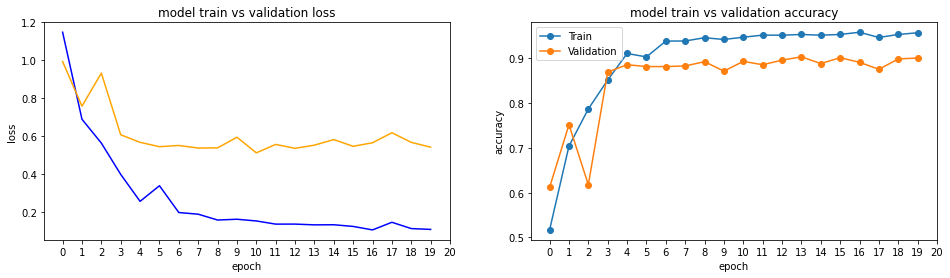


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.451088

>repeat #1: train accuracy 0.957, test accuracy 0.893
r: 1

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9561
Epoch 00001: val_loss did not improve from 0.51255
184/184 [==============================] - 6s 32ms/step - loss: 0.1054 - accuracy: 0.9563 - val_loss: 0.5610 - val_accuracy: 0.9041
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.1011 - accuracy: 0.9590
Epoch 00002: val_loss did not improve from 0.51255
184/184 [==============================] - 4s 23ms/step - loss: 0.1009 - accuracy: 0.9590 - val_loss: 0.5983 - val_accuracy: 0.9035
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9532
Epoch 00003: val_loss did not improve from 0.51255
184/184 [==============================] - 4s 20ms/step - loss: 0.1068 - accuracy: 0.9531 - val_loss: 0.5792 - 

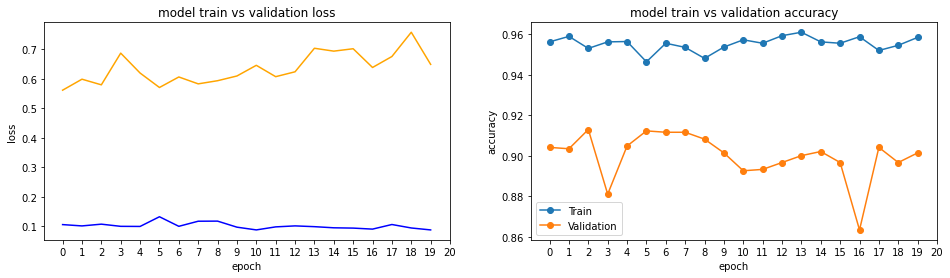


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.451088  0.564204

>repeat #2: train accuracy 0.959, test accuracy 0.913
r: 2

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.1107 - accuracy: 0.9529
Epoch 00001: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 27ms/step - loss: 0.1109 - accuracy: 0.9529 - val_loss: 0.6917 - val_accuracy: 0.9014
Epoch 2/20
181/184 [============================>.] - ETA: 0s - loss: 0.0967 - accuracy: 0.9568
Epoch 00002: val_loss did not improve from 0.51255
184/184 [==============================] - 4s 23ms/step - loss: 0.0956 - accuracy: 0.9573 - val_loss: 0.6472 - val_accuracy: 0.9143
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9583
Epoch 00003: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 27ms/step - loss: 0.0849 - accuracy: 0.9582 -

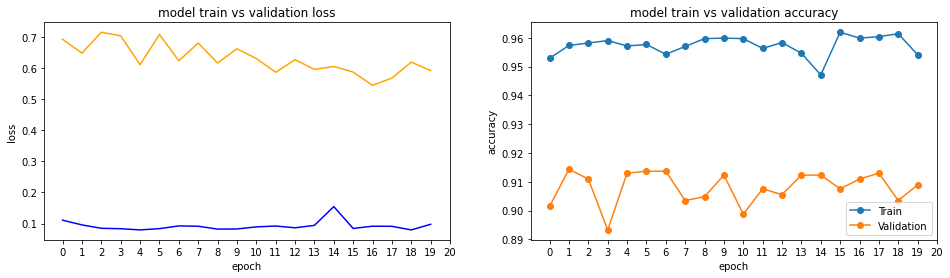


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.451088  0.564204  0.669666

>repeat #3: train accuracy 0.954, test accuracy 0.890
r: 3

>>>>>fit the model on the training data
Epoch 1/20
182/184 [============================>.] - ETA: 0s - loss: 0.1243 - accuracy: 0.9480
Epoch 00001: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 28ms/step - loss: 0.1251 - accuracy: 0.9475 - val_loss: 0.6484 - val_accuracy: 0.9069
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9578
Epoch 00002: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 28ms/step - loss: 0.1198 - accuracy: 0.9578 - val_loss: 0.5627 - val_accuracy: 0.9055
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.0968 - accuracy: 0.9621
Epoch 00003: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 27ms/step - loss: 0.0965 

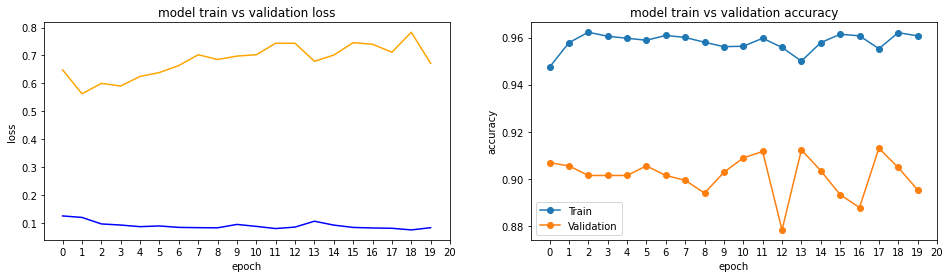


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.451088  0.564204  0.669666  0.595843

>repeat #4: train accuracy 0.961, test accuracy 0.898
r: 4

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9583
Epoch 00001: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 28ms/step - loss: 0.0932 - accuracy: 0.9585 - val_loss: 0.6898 - val_accuracy: 0.8906
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9551
Epoch 00002: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 28ms/step - loss: 0.1135 - accuracy: 0.9551 - val_loss: 0.6040 - val_accuracy: 0.8939
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9590
Epoch 00003: val_loss did not improve from 0.51255
184/184 [==============================] - 5s 28ms/

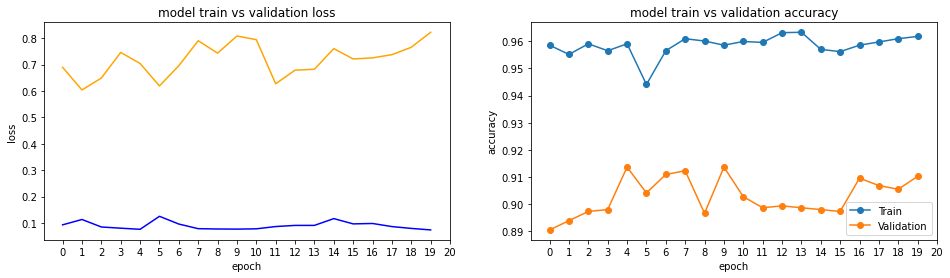


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.451088  0.564204  0.669666  0.595843  0.604584

>repeat #5: train accuracy 0.962, test accuracy 0.903

Train Accuracy: mean 0.958%, std (+/-0.003)
Test Accuracy: mean 0.899%, std (+/-0.008)


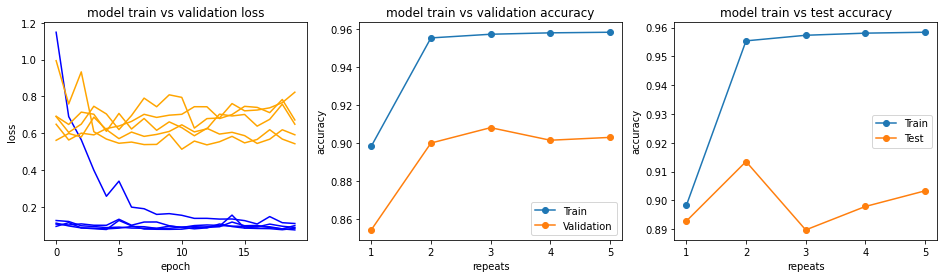

Total Time taken to train the model: 567.4792292118073 seconds, epochs=20, batch_size=32, repeats=5


In [71]:
# run the experiment
start_time = time()
# with tf.device("cpu:0"):
run_experiment_det(model_lstm, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [72]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.940832
Precision: 0.940832
Recall: 0.940832
F1 score: 0.940832

----Test Data---
Accuracy: 0.875467
Precision: 0.875467
Recall: 0.875467
F1 score: 0.875467


In [36]:
#build lstm model
def build_model_lstm():

    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_lstm.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath


In [37]:
model_lstm, callbacks, filepath = build_model_lstm()
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.5589
Epoch 00001: val_loss improved from inf to 0.83672, saving model to ./Model\my_best_model_lstm.hdf5
184/184 [==============================] - 11s 50ms/step - loss: 1.0727 - accuracy: 0.5589 - val_loss: 0.8367 - val_accuracy: 0.6472
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.7259
Epoch 00002: val_loss improved from 0.83672 to 0.64260, saving model to ./Model\my_best_model_lstm.hdf5
184/184 [==============================] - 9s 49ms/step - loss: 0.6763 - accuracy: 0.7262 - val_loss: 0.6426 - val_accuracy: 0.7947
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.3875 - accuracy: 0.8550 ETA: 0s - loss: 0.3
Epoch 00003: val_loss improved from 0.64260 to 0.49924, saving model to ./Model\my_best_model_lstm.hdf5
184/184 [==============================] - 9s 51ms/step - loss: 0.3867 - 

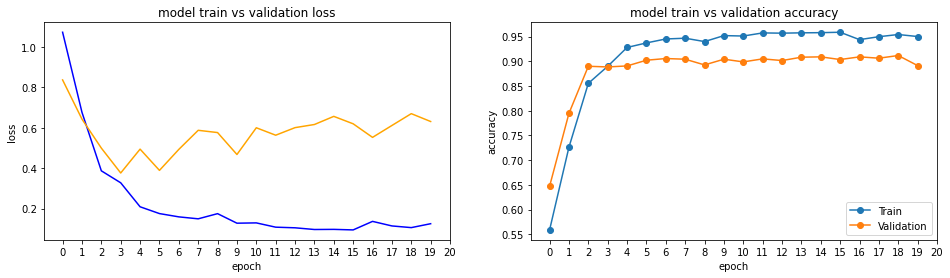


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.517193

>repeat #1: train accuracy 0.950, test accuracy 0.912
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9597
Epoch 00001: val_loss did not improve from 0.37602
184/184 [==============================] - 16s 90ms/step - loss: 0.1032 - accuracy: 0.9597 - val_loss: 0.6593 - val_accuracy: 0.8994
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9565
Epoch 00002: val_loss did not improve from 0.37602
184/184 [==============================] - 9s 46ms/step - loss: 0.0937 - accuracy: 0.9565 - val_loss: 0.7473 - val_accuracy: 0.9069
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9566
Epoch 00003: val_loss did not improve from 0.37602
184/184 [==============================] - 9s 48ms/step - loss: 0.1011 - accuracy: 0.9566 - val_loss: 0.6085 -

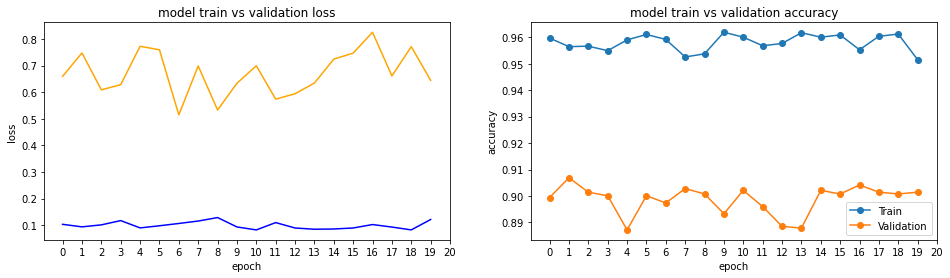


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.517193  0.400542

>repeat #2: train accuracy 0.952, test accuracy 0.915
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9602
Epoch 00001: val_loss did not improve from 0.37602
184/184 [==============================] - 17s 91ms/step - loss: 0.0944 - accuracy: 0.9602 - val_loss: 0.7117 - val_accuracy: 0.9014
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9640
Epoch 00002: val_loss did not improve from 0.37602
184/184 [==============================] - 12s 65ms/step - loss: 0.0859 - accuracy: 0.9640 - val_loss: 0.8413 - val_accuracy: 0.8906
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9629
Epoch 00003: val_loss did not improve from 0.37602
184/184 [==============================] - 15s 84ms/step - loss: 0.0815 - accuracy: 0.962

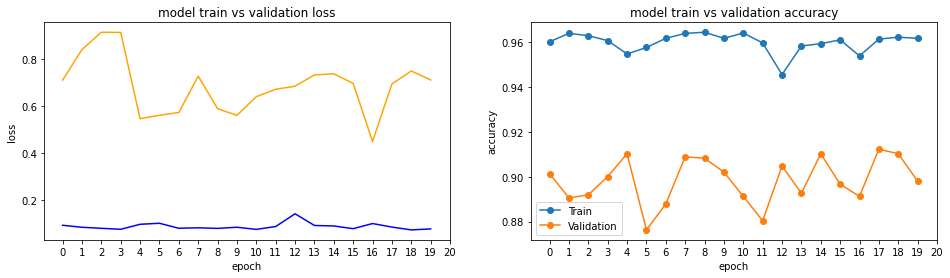


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.517193  0.400542  0.592862

>repeat #3: train accuracy 0.962, test accuracy 0.897
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9646
Epoch 00001: val_loss did not improve from 0.37602
184/184 [==============================] - 17s 92ms/step - loss: 0.0703 - accuracy: 0.9646 - val_loss: 0.5944 - val_accuracy: 0.8742
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9646
Epoch 00002: val_loss did not improve from 0.37602
184/184 [==============================] - 18s 96ms/step - loss: 0.0719 - accuracy: 0.9646 - val_loss: 0.7730 - val_accuracy: 0.9048
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9628
Epoch 00003: val_loss did not improve from 0.37602
184/184 [==============================] - 10s 57ms/step - loss: 0.07

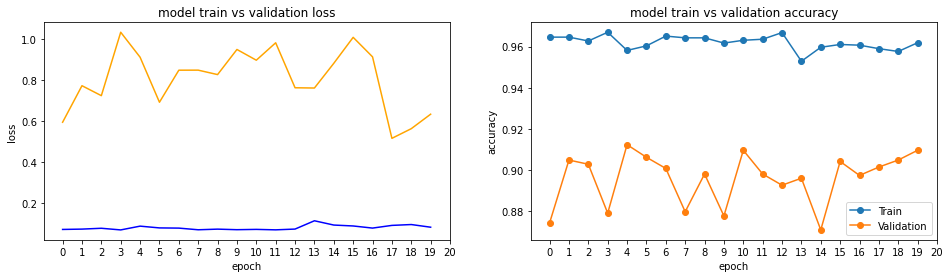


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.517193  0.400542  0.592862  0.329306

>repeat #4: train accuracy 0.962, test accuracy 0.919
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9590
Epoch 00001: val_loss did not improve from 0.37602
184/184 [==============================] - 15s 84ms/step - loss: 0.0803 - accuracy: 0.9590 - val_loss: 0.9556 - val_accuracy: 0.9150
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.9512
Epoch 00002: val_loss did not improve from 0.37602
184/184 [==============================] - 16s 88ms/step - loss: 0.1100 - accuracy: 0.9512 - val_loss: 0.9053 - val_accuracy: 0.8919
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9441
Epoch 00003: val_loss did not improve from 0.37602
184/184 [==============================] - 12s 67

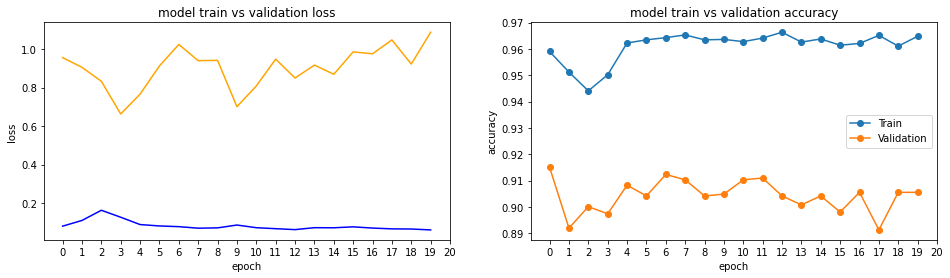


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.517193  0.400542  0.592862  0.329306  0.669925

>repeat #5: train accuracy 0.965, test accuracy 0.905

Train Accuracy: mean 0.958%, std (+/-0.006)
Test Accuracy: mean 0.910%, std (+/-0.008)


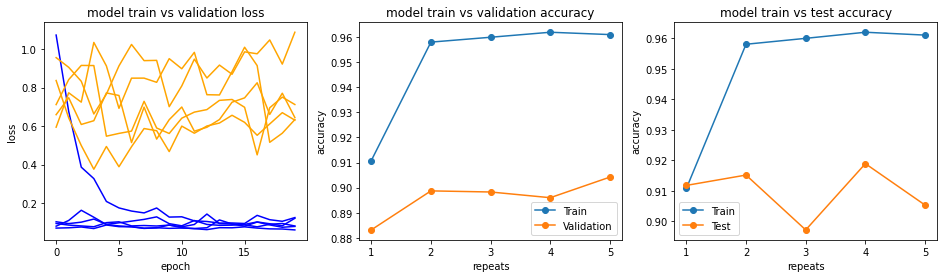

Total Time taken to train the model: 1376.50612783432 seconds, epochs=20, batch_size=32, repeats=5


In [38]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_lstm, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [39]:
filepath

'./Model/my_best_model_lstm.hdf5'

In [40]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)


----Train Data----
Accuracy: 0.911997
Precision: 0.911997
Recall: 0.911997
F1 score: 0.911997

----Test Data---
Accuracy: 0.861893
Precision: 0.861893
Recall: 0.861893
F1 score: 0.861893


In [103]:
#build lstm model
def build_model_lstm2():

    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_lstm2.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath


In [104]:
#build and compile the model structure
model_lstm2, callbacks, filepath = build_model_lstm2()
model_lstm2.summary()    
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               272384    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 306,054
Trainable params: 306,054
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.5589
Epoch 00001: val_loss improved from inf to 0.97845, saving model to ./Model\my_best_model_lstm2.hdf5
184/184 [==============================] - 53s 281ms/step - loss: 1.0440 - accuracy: 0.5589 - val_loss: 0.9784 - val_accuracy: 0.5799
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.6722
Epoch 00002: val_loss improved from 0.97845 to 0.89739, saving model to ./Model\my_best_model_lstm2.hdf5
184/184 [==============================] - 47s 257ms/step - loss: 0.7123 - accuracy: 0.6722 - val_loss: 0.8974 - val_accuracy: 0.6846
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.7776 - accuracy: 0.6722
Epoch 00003: val_loss did not improve from 0.89739
184/184 [==============================] - 47s 257ms/step - loss: 0.7776 - accuracy: 0.6722 - val_loss: 1.2519 - val_accuracy: 0.4922
Epoch 4

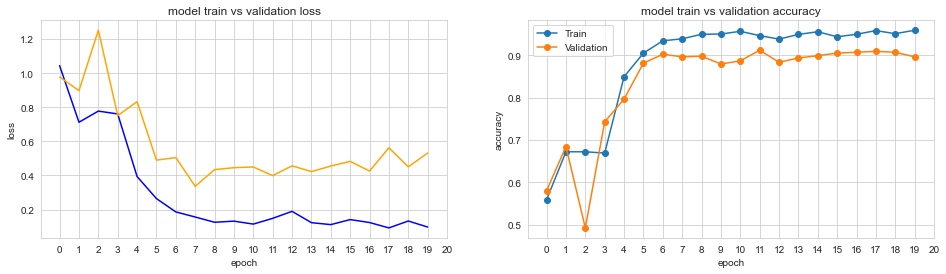


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.246041

>repeat #1: train accuracy 0.960, test accuracy 0.909
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9570
Epoch 00001: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 248ms/step - loss: 0.1028 - accuracy: 0.9570 - val_loss: 0.4173 - val_accuracy: 0.9103
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9607
Epoch 00002: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 251ms/step - loss: 0.0887 - accuracy: 0.9607 - val_loss: 0.4618 - val_accuracy: 0.9096
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.9634
Epoch 00003: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 251ms/step - loss: 0.0867 - accuracy: 0.9634 - val_loss: 0.4

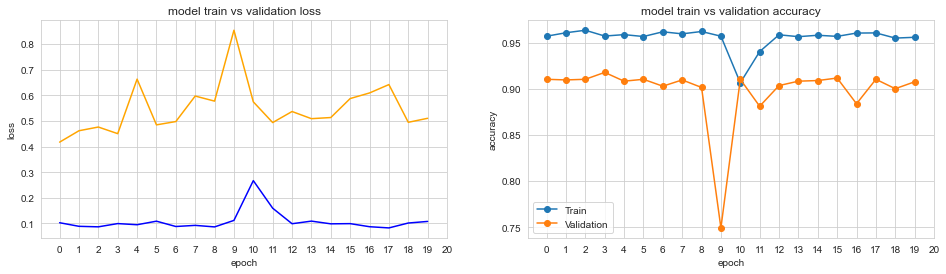


>>>>>evaluating the model on the test data
df_test_losses           0        1
0  0.246041  0.32024

>repeat #2: train accuracy 0.956, test accuracy 0.908
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9541
Epoch 00001: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 251ms/step - loss: 0.1118 - accuracy: 0.9541 - val_loss: 0.4696 - val_accuracy: 0.9041
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9597
Epoch 00002: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 252ms/step - loss: 0.0879 - accuracy: 0.9597 - val_loss: 0.5699 - val_accuracy: 0.9035
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9616
Epoch 00003: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 253ms/step - loss: 0.0847 - accuracy: 0.96

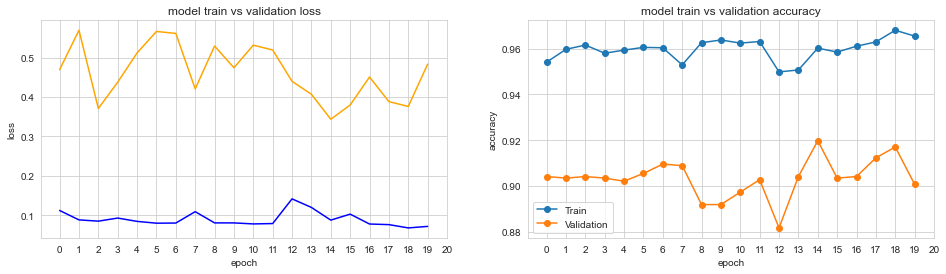


>>>>>evaluating the model on the test data
df_test_losses           0        1         2
0  0.246041  0.32024  0.379475

>repeat #3: train accuracy 0.965, test accuracy 0.920
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9663
Epoch 00001: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 252ms/step - loss: 0.0670 - accuracy: 0.9663 - val_loss: 0.4910 - val_accuracy: 0.8946
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9583
Epoch 00002: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 252ms/step - loss: 0.0967 - accuracy: 0.9583 - val_loss: 0.6551 - val_accuracy: 0.8973
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9614
Epoch 00003: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 252ms/step - loss: 0.0

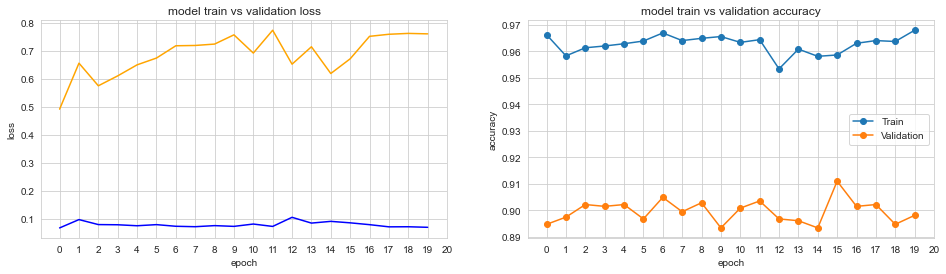


>>>>>evaluating the model on the test data
df_test_losses           0        1         2         3
0  0.246041  0.32024  0.379475  0.308847

>repeat #4: train accuracy 0.968, test accuracy 0.926
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9663
Epoch 00001: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 248ms/step - loss: 0.0680 - accuracy: 0.9663 - val_loss: 0.8541 - val_accuracy: 0.8926
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9687
Epoch 00002: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 250ms/step - loss: 0.0668 - accuracy: 0.9687 - val_loss: 0.8539 - val_accuracy: 0.9035
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9667
Epoch 00003: val_loss did not improve from 0.33664
184/184 [==============================] - 46s 25

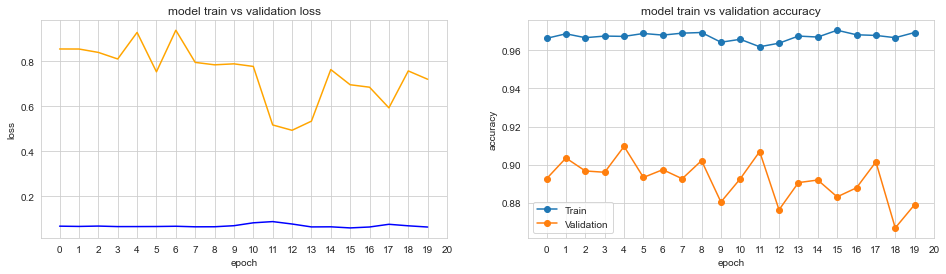


>>>>>evaluating the model on the test data
df_test_losses           0        1         2         3         4
0  0.246041  0.32024  0.379475  0.308847  0.494325

>repeat #5: train accuracy 0.969, test accuracy 0.913

Train Accuracy: mean 0.964%, std (+/-0.005)
Test Accuracy: mean 0.915%, std (+/-0.007)


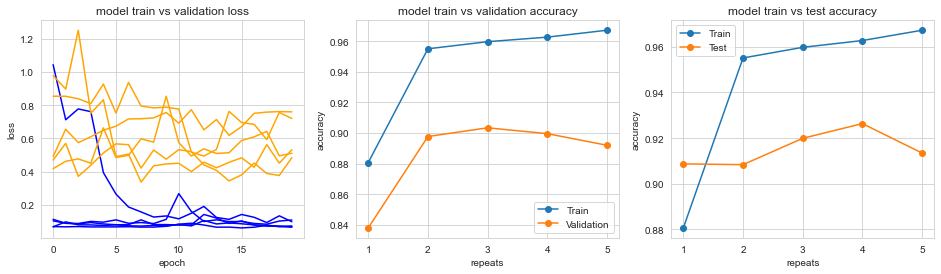

Total Time taken to train the model: 4679.930729389191 seconds, epochs=20, batch_size=32, repeats=5


In [105]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_lstm2, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')



In [106]:
filepath

'./Model/my_best_model_lstm2.hdf5'

In [107]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)
    

----Train Data----
Accuracy: 0.945457
Precision: 0.945457
Recall: 0.945457
F1 score: 0.945457

----Test Data---
Accuracy: 0.904309
Precision: 0.904309
Recall: 0.904309
F1 score: 0.904309


In [108]:
#build lstm model
def build_model_lstm3():

    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_lstm3.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath

In [109]:
model_lstm3, callbacks, filepath = build_model_lstm3()
model_lstm3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               272384    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 339,718
Trainable params: 339,718
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.5860
Epoch 00001: val_loss improved from inf to 0.84944, saving model to ./Model\my_best_model_lstm3.hdf5
184/184 [==============================] - 52s 280ms/step - loss: 0.9972 - accuracy: 0.5860 - val_loss: 0.8494 - val_accuracy: 0.6812
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.7720
Epoch 00002: val_loss improved from 0.84944 to 0.45852, saving model to ./Model\my_best_model_lstm3.hdf5
184/184 [==============================] - 53s 288ms/step - loss: 0.5799 - accuracy: 0.7720 - val_loss: 0.4585 - val_accuracy: 0.8470
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8837
Epoch 00003: val_loss improved from 0.45852 to 0.34461, saving model to ./Model\my_best_model_lstm3.hdf5
184/184 [==============================] - 53s 289ms/step - loss: 0.3165 - accuracy: 0.

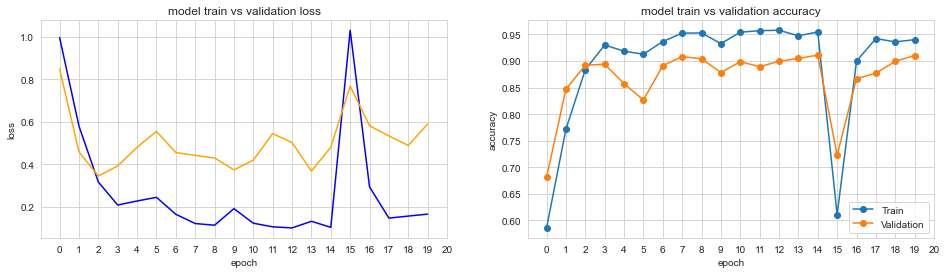


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.287779

>repeat #1: train accuracy 0.940, test accuracy 0.908
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9585
Epoch 00001: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 289ms/step - loss: 0.1044 - accuracy: 0.9585 - val_loss: 0.6287 - val_accuracy: 0.9109
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9475
Epoch 00002: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 291ms/step - loss: 0.1268 - accuracy: 0.9475 - val_loss: 0.4854 - val_accuracy: 0.9007
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9522
Epoch 00003: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 289ms/step - loss: 0.1229 - accuracy: 0.9522 - val_loss: 0.5

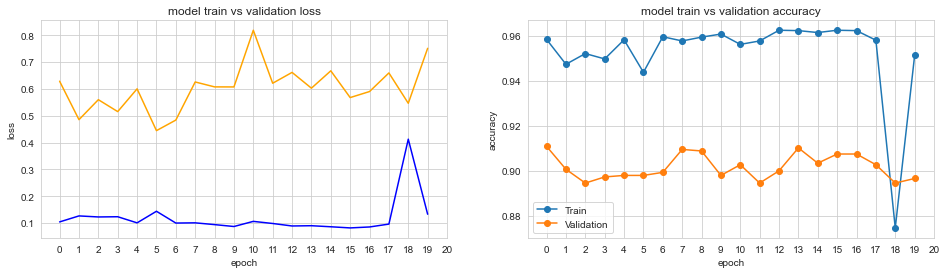


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.287779  0.287545

>repeat #2: train accuracy 0.951, test accuracy 0.913
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9580
Epoch 00001: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 289ms/step - loss: 0.1083 - accuracy: 0.9580 - val_loss: 0.8404 - val_accuracy: 0.8878
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9589
Epoch 00002: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 291ms/step - loss: 0.1024 - accuracy: 0.9589 - val_loss: 1.0539 - val_accuracy: 0.8994
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9602
Epoch 00003: val_loss did not improve from 0.34461
184/184 [==============================] - 54s 292ms/step - loss: 0.1003 - accuracy: 0.

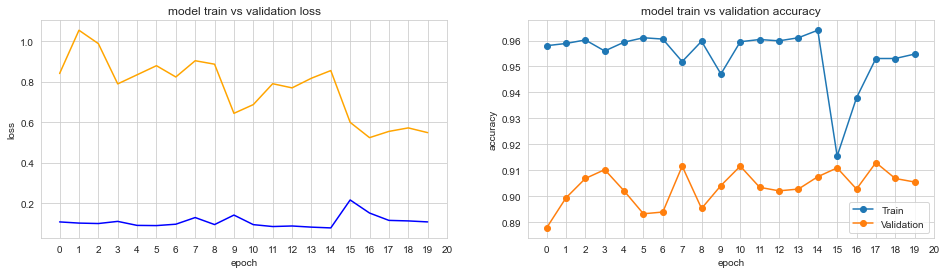


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.287779  0.287545  0.366767

>repeat #3: train accuracy 0.955, test accuracy 0.902
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9612
Epoch 00001: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 286ms/step - loss: 0.0977 - accuracy: 0.9612 - val_loss: 0.6012 - val_accuracy: 0.9014
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9585
Epoch 00002: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 287ms/step - loss: 0.0975 - accuracy: 0.9585 - val_loss: 0.6178 - val_accuracy: 0.8906
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9621
Epoch 00003: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 288ms/step - loss: 0

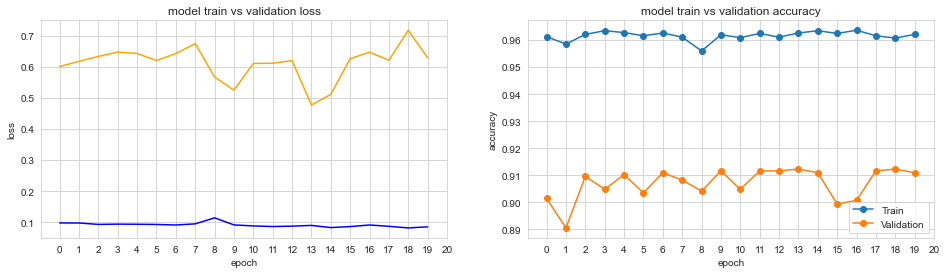


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.287779  0.287545  0.366767  0.360136

>repeat #4: train accuracy 0.962, test accuracy 0.919
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9626
Epoch 00001: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 286ms/step - loss: 0.0827 - accuracy: 0.9626 - val_loss: 0.6592 - val_accuracy: 0.9143
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9621
Epoch 00002: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 291ms/step - loss: 0.0802 - accuracy: 0.9621 - val_loss: 0.7239 - val_accuracy: 0.9137
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9648
Epoch 00003: val_loss did not improve from 0.34461
184/184 [==============================] - 53s 

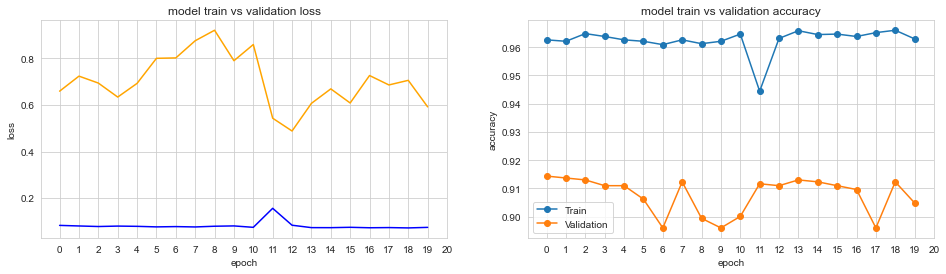


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.287779  0.287545  0.366767  0.360136  0.448239

>repeat #5: train accuracy 0.963, test accuracy 0.918

Train Accuracy: mean 0.954%, std (+/-0.008)
Test Accuracy: mean 0.912%, std (+/-0.006)


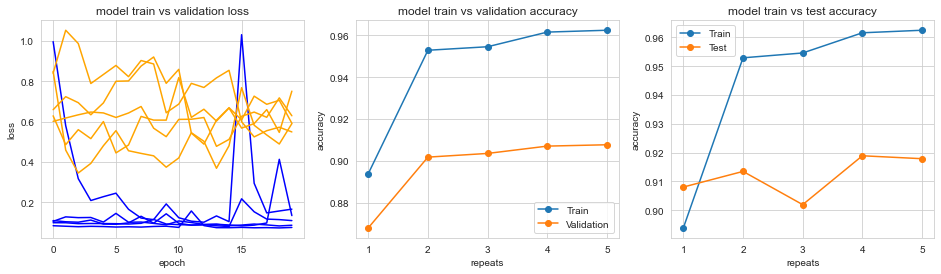

Total Time taken to train the model: 5374.987537622452 seconds, epochs=20, batch_size=32, repeats=5


In [110]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_lstm3, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [111]:
filepath

'./Model/my_best_model_lstm3.hdf5'

In [112]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.917165
Precision: 0.917165
Recall: 0.917165
F1 score: 0.917165

----Test Data---
Accuracy: 0.871395
Precision: 0.871395
Recall: 0.871395
F1 score: 0.871395


#### GRU

In [115]:
#build lstm model
def build_model_gru():

    model = Sequential()
    model.add(GRU(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_gru_100.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath


In [116]:
model_gru, callbacks, filepath =  build_model_gru()
model_gru.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 100)               33300     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               10100     
                                                                 
 dense_25 (Dense)            (None, 6)                 606       
                                                                 
Total params: 44,006
Trainable params: 44,006
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
182/184 [============================>.] - ETA: 0s - loss: 1.0962 - accuracy: 0.5374
Epoch 00001: val_loss improved from inf to 0.82598, saving model to ./Model\my_best_model_gru_100.hdf5
184/184 [==============================] - 4s 16ms/step - loss: 1.0921 - accuracy: 0.5392 - val_loss: 0.8260 - val_accuracy: 0.6649
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.7278
Epoch 00002: val_loss improved from 0.82598 to 0.63503, saving model to ./Model\my_best_model_gru_100.hdf5
184/184 [==============================] - 3s 15ms/step - loss: 0.6312 - accuracy: 0.7279 - val_loss: 0.6350 - val_accuracy: 0.7899
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8555
Epoch 00003: val_loss improved from 0.63503 to 0.42531, saving model to ./Model\my_best_model_gru_100.hdf5
184/184 [==============================] - 3s 16ms/step - loss: 0.3671 - accuracy: 0.

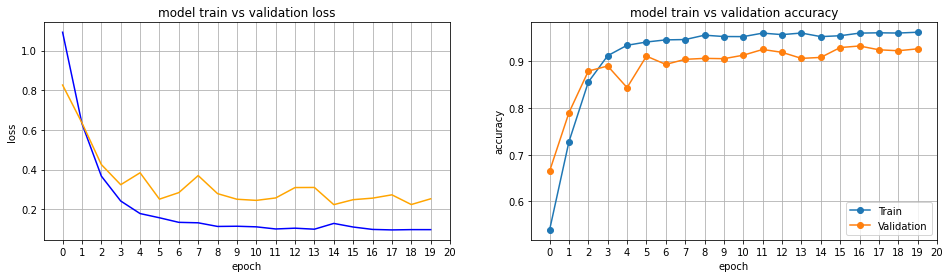


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.325195

>repeat #1: train accuracy 0.962, test accuracy 0.901
r: 1

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.0919 - accuracy: 0.9611
Epoch 00001: val_loss did not improve from 0.22324
184/184 [==============================] - 4s 21ms/step - loss: 0.0923 - accuracy: 0.9607 - val_loss: 0.3204 - val_accuracy: 0.9089
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9590
Epoch 00002: val_loss did not improve from 0.22324
184/184 [==============================] - 3s 18ms/step - loss: 0.1043 - accuracy: 0.9590 - val_loss: 0.4792 - val_accuracy: 0.9082
Epoch 3/20
182/184 [============================>.] - ETA: 0s - loss: 0.1039 - accuracy: 0.9615
Epoch 00003: val_loss did not improve from 0.22324
184/184 [==============================] - 3s 19ms/step - loss: 0.1040 - accuracy: 0.9616 - val_loss: 0.3581 - 

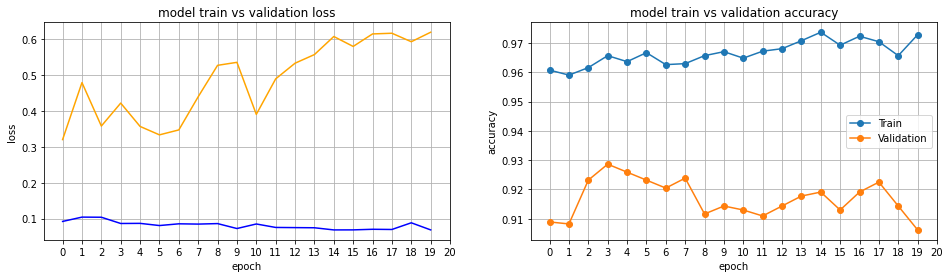


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.325195  0.245663

>repeat #2: train accuracy 0.973, test accuracy 0.927
r: 2

>>>>>fit the model on the training data
Epoch 1/20
181/184 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9753
Epoch 00001: val_loss did not improve from 0.22324
184/184 [==============================] - 4s 24ms/step - loss: 0.0582 - accuracy: 0.9753 - val_loss: 0.7410 - val_accuracy: 0.9232
Epoch 2/20
182/184 [============================>.] - ETA: 0s - loss: 0.0603 - accuracy: 0.9734
Epoch 00002: val_loss did not improve from 0.22324
184/184 [==============================] - 5s 28ms/step - loss: 0.0601 - accuracy: 0.9736 - val_loss: 0.6610 - val_accuracy: 0.8980
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9731
Epoch 00003: val_loss did not improve from 0.22324
184/184 [==============================] - 5s 25ms/step - loss: 0.0578 - accuracy: 0.9731 -

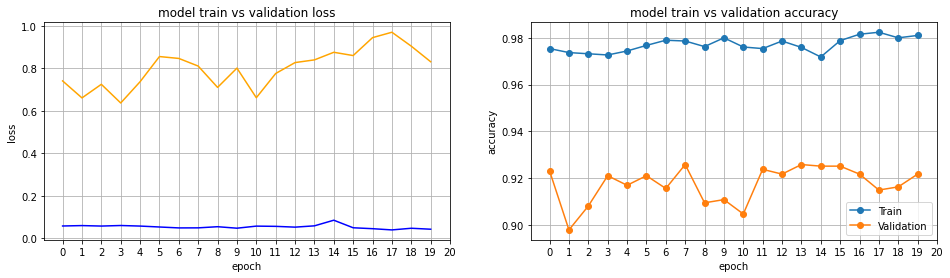


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.325195  0.245663  0.436975

>repeat #3: train accuracy 0.981, test accuracy 0.912
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9803
Epoch 00001: val_loss did not improve from 0.22324
184/184 [==============================] - 5s 25ms/step - loss: 0.0481 - accuracy: 0.9803 - val_loss: 0.8971 - val_accuracy: 0.9218
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 0.9822
Epoch 00002: val_loss did not improve from 0.22324
184/184 [==============================] - 7s 37ms/step - loss: 0.0400 - accuracy: 0.9823 - val_loss: 0.9886 - val_accuracy: 0.9177
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9854
Epoch 00003: val_loss did not improve from 0.22324
184/184 [==============================] - 6s 32ms/step - loss: 0.0388 

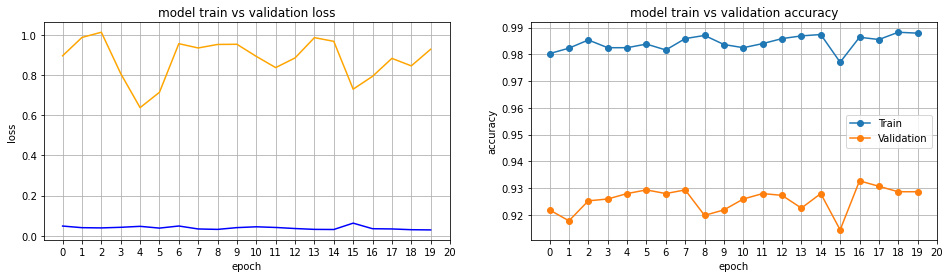


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.325195  0.245663  0.436975  0.513615

>repeat #4: train accuracy 0.988, test accuracy 0.917
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9879
Epoch 00001: val_loss did not improve from 0.22324
184/184 [==============================] - 4s 21ms/step - loss: 0.0275 - accuracy: 0.9879 - val_loss: 0.9741 - val_accuracy: 0.9279
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9898
Epoch 00002: val_loss did not improve from 0.22324
184/184 [==============================] - 4s 21ms/step - loss: 0.0268 - accuracy: 0.9898 - val_loss: 0.9385 - val_accuracy: 0.9334
Epoch 3/20
182/184 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9906
Epoch 00003: val_loss did not improve from 0.22324
184/184 [==============================] - 5s 28ms/

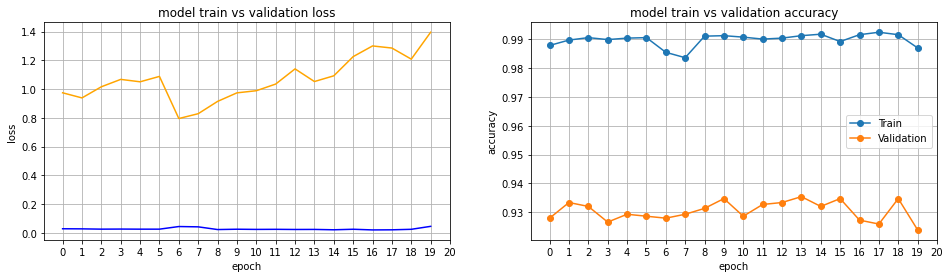


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.325195  0.245663  0.436975  0.513615  0.735368

>repeat #5: train accuracy 0.987, test accuracy 0.919

Train Accuracy: mean 0.978%, std (+/-0.010)
Test Accuracy: mean 0.915%, std (+/-0.009)


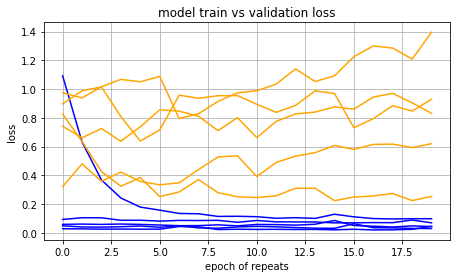

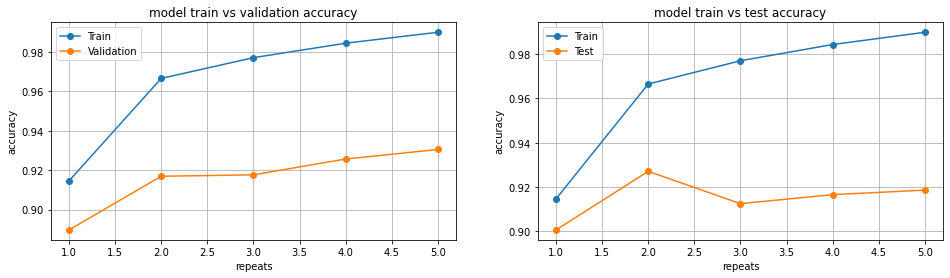

Total Time taken to train the model: 473.6173400878906 seconds, epochs=20, batch_size=32, repeats=5


In [117]:

# run the experiment
start_time = time()
# with tf.device("cpu:0"):
run_experiment_det(model_gru, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [119]:
filepath

'./Model/my_best_model_gru_100.hdf5'

In [120]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.943825
Precision: 0.943825
Recall: 0.943825
F1 score: 0.943825

----Test Data---
Accuracy: 0.899220
Precision: 0.899220
Recall: 0.899220
F1 score: 0.899220


In [121]:
#build lstm model
def build_model_gru():

    model = Sequential()
    model.add(GRU(32, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_gru_1_0.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath


model_gru, callbacks, filepath =  build_model_gru()
model_gru.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 32)                4128      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 6)                 198       
                                                                 
Total params: 5,382
Trainable params: 5,382
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
180/184 [============================>.] - ETA: 0s - loss: 1.3194 - accuracy: 0.4653
Epoch 00001: val_loss improved from inf to 1.09595, saving model to ./Model\my_best_model_gru_1_0.hdf5
184/184 [==============================] - 3s 12ms/step - loss: 1.3146 - accuracy: 0.4656 - val_loss: 1.0960 - val_accuracy: 0.5466
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.9389 - accuracy: 0.5875
Epoch 00002: val_loss improved from 1.09595 to 0.89068, saving model to ./Model\my_best_model_gru_1_0.hdf5
184/184 [==============================] - 2s 11ms/step - loss: 0.9389 - accuracy: 0.5875 - val_loss: 0.8907 - val_accuracy: 0.6458
Epoch 3/20
180/184 [============================>.] - ETA: 0s - loss: 0.6747 - accuracy: 0.6951
Epoch 00003: val_loss improved from 0.89068 to 0.61305, saving model to ./Model\my_best_model_gru_1_0.hdf5
184/184 [==============================] - 2s 12ms/step - loss: 0.6722 - accuracy: 0.

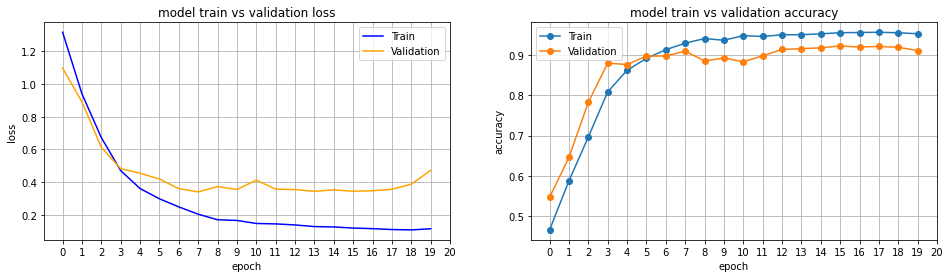


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.398085

>repeat #1: train accuracy 0.953, test accuracy 0.899
r: 1

>>>>>fit the model on the training data
Epoch 1/20
181/184 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9575
Epoch 00001: val_loss did not improve from 0.34141
184/184 [==============================] - 3s 17ms/step - loss: 0.1101 - accuracy: 0.9568 - val_loss: 0.4722 - val_accuracy: 0.8980
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9580
Epoch 00002: val_loss did not improve from 0.34141
184/184 [==============================] - 3s 16ms/step - loss: 0.1133 - accuracy: 0.9580 - val_loss: 0.4920 - val_accuracy: 0.9116
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9580
Epoch 00003: val_loss did not improve from 0.34141
184/184 [==============================] - 3s 17ms/step - loss: 0.1057 - accuracy: 0.9582 - val_loss: 0.3820 - 

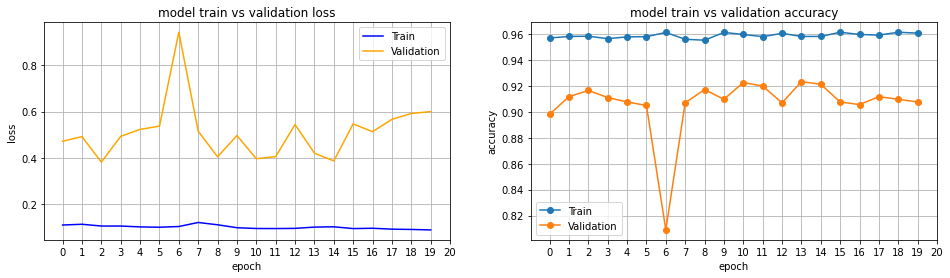


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.398085  0.574256

>repeat #2: train accuracy 0.961, test accuracy 0.905
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9553
Epoch 00001: val_loss did not improve from 0.34141
184/184 [==============================] - 4s 21ms/step - loss: 0.1119 - accuracy: 0.9553 - val_loss: 0.4886 - val_accuracy: 0.9082
Epoch 2/20
182/184 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9584
Epoch 00002: val_loss did not improve from 0.34141
184/184 [==============================] - 4s 23ms/step - loss: 0.1044 - accuracy: 0.9583 - val_loss: 0.4782 - val_accuracy: 0.9069
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.0879 - accuracy: 0.9626
Epoch 00003: val_loss did not improve from 0.34141
184/184 [==============================] - 4s 21ms/step - loss: 0.0885 - accuracy: 0.9624 -

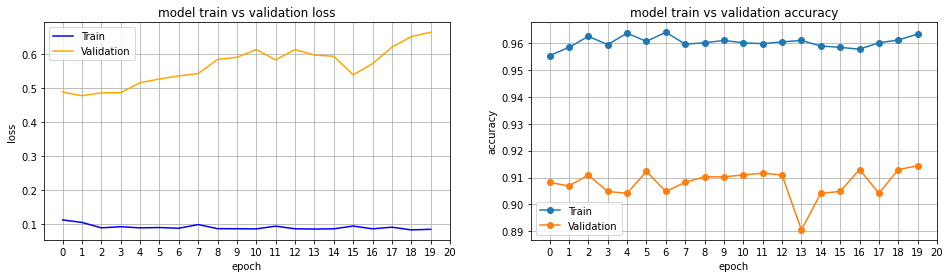


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.398085  0.574256  0.585675

>repeat #3: train accuracy 0.963, test accuracy 0.901
r: 3

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.0896 - accuracy: 0.9612
Epoch 00001: val_loss did not improve from 0.34141
184/184 [==============================] - 4s 22ms/step - loss: 0.0896 - accuracy: 0.9614 - val_loss: 0.6247 - val_accuracy: 0.9150
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9611
Epoch 00002: val_loss did not improve from 0.34141
184/184 [==============================] - 4s 24ms/step - loss: 0.0827 - accuracy: 0.9611 - val_loss: 0.6325 - val_accuracy: 0.9143
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9626
Epoch 00003: val_loss did not improve from 0.34141
184/184 [==============================] - 4s 24ms/step - loss: 0.0826 

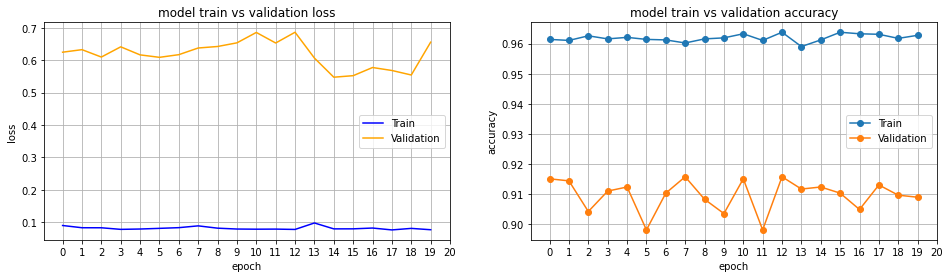


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.398085  0.574256  0.585675  0.528838

>repeat #4: train accuracy 0.963, test accuracy 0.910
r: 4

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.0773 - accuracy: 0.9614
Epoch 00001: val_loss did not improve from 0.34141
184/184 [==============================] - 6s 34ms/step - loss: 0.0770 - accuracy: 0.9616 - val_loss: 0.6839 - val_accuracy: 0.9150
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9631
Epoch 00002: val_loss did not improve from 0.34141
184/184 [==============================] - 5s 25ms/step - loss: 0.0740 - accuracy: 0.9633 - val_loss: 0.6498 - val_accuracy: 0.8953
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9628
Epoch 00003: val_loss did not improve from 0.34141
184/184 [==============================] - 4s 24ms/

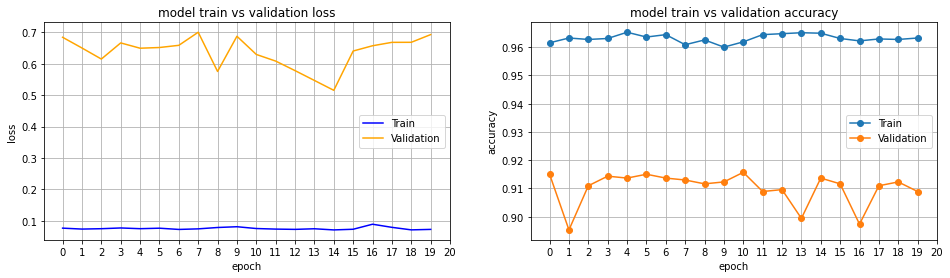


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.398085  0.574256  0.585675  0.528838  0.560584

>repeat #5: train accuracy 0.963, test accuracy 0.917

Train Accuracy: mean 0.961%, std (+/-0.004)
Test Accuracy: mean 0.906%, std (+/-0.007)


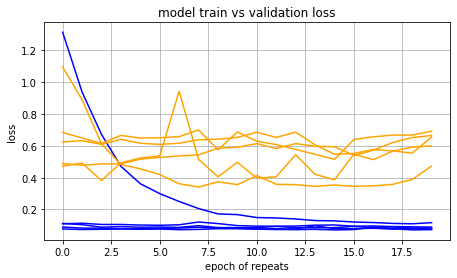

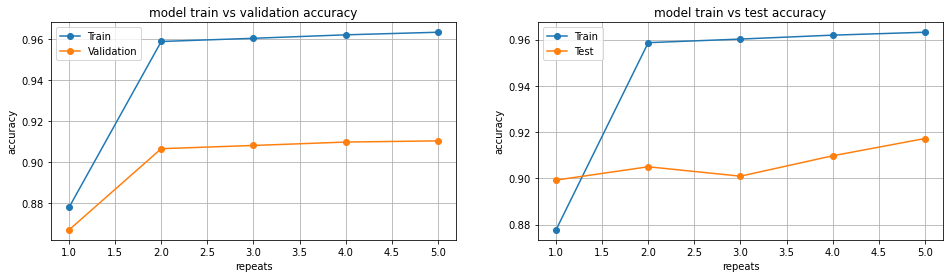

Total Time taken to train the model: 429.5810897350311 seconds, epochs=20, batch_size=32, repeats=5


In [122]:

# run the experiment
start_time = time()
# with tf.device("cpu:0"):
run_experiment_det(model_gru, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [124]:
filepath

'./Model/my_best_model_gru_1_0.hdf5'

In [123]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.939608
Precision: 0.939608
Recall: 0.939608
F1 score: 0.939608

----Test Data---
Accuracy: 0.880896
Precision: 0.880896
Recall: 0.880896
F1 score: 0.880896


In [126]:
#build lstm model
def build_model_gru():

    model = Sequential()
    model.add(GRU(32, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.20))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_gru_1_1.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath


model_gru, callbacks, filepath =  build_model_gru()
model_gru.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 32)                4128      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                1056      
                                                                 
 dense_31 (Dense)            (None, 6)                 198       
                                                                 
Total params: 5,382
Trainable params: 5,382
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
182/184 [============================>.] - ETA: 0s - loss: 1.2728 - accuracy: 0.4518
Epoch 00001: val_loss improved from inf to 1.06500, saving model to ./Model\my_best_model_gru_1_1.hdf5
184/184 [==============================] - 3s 12ms/step - loss: 1.2712 - accuracy: 0.4520 - val_loss: 1.0650 - val_accuracy: 0.5534
Epoch 2/20
181/184 [============================>.] - ETA: 0s - loss: 0.9115 - accuracy: 0.6057
Epoch 00002: val_loss improved from 1.06500 to 0.75605, saving model to ./Model\my_best_model_gru_1_1.hdf5
184/184 [==============================] - 2s 11ms/step - loss: 0.9093 - accuracy: 0.6057 - val_loss: 0.7561 - val_accuracy: 0.6574
Epoch 3/20
181/184 [============================>.] - ETA: 0s - loss: 0.6794 - accuracy: 0.6728
Epoch 00003: val_loss improved from 0.75605 to 0.65292, saving model to ./Model\my_best_model_gru_1_1.hdf5
184/184 [==============================] - 2s 11ms/step - loss: 0.6787 - accuracy: 0.

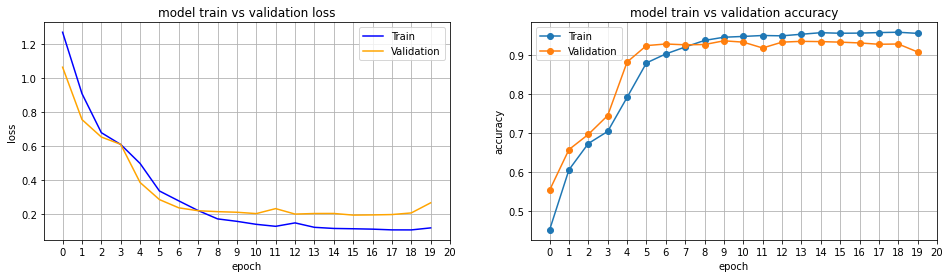


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.485487

>repeat #1: train accuracy 0.954, test accuracy 0.868
r: 1

>>>>>fit the model on the training data
Epoch 1/20
180/184 [============================>.] - ETA: 0s - loss: 0.1085 - accuracy: 0.9602
Epoch 00001: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 17ms/step - loss: 0.1087 - accuracy: 0.9599 - val_loss: 0.2207 - val_accuracy: 0.9245
Epoch 2/20
181/184 [============================>.] - ETA: 0s - loss: 0.1004 - accuracy: 0.9596
Epoch 00002: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 16ms/step - loss: 0.1001 - accuracy: 0.9597 - val_loss: 0.2212 - val_accuracy: 0.9171
Epoch 3/20
182/184 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9615
Epoch 00003: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 18ms/step - loss: 0.0981 - accuracy: 0.9614 - val_loss: 0.2166 - 

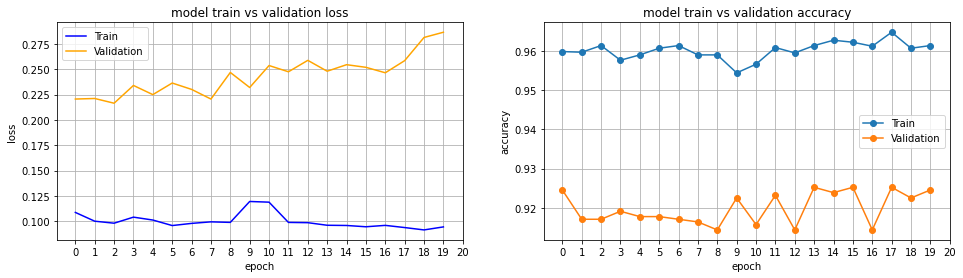


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.485487  0.416905

>repeat #2: train accuracy 0.961, test accuracy 0.907
r: 2

>>>>>fit the model on the training data
Epoch 1/20
183/184 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9640
Epoch 00001: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 17ms/step - loss: 0.0917 - accuracy: 0.9641 - val_loss: 0.2602 - val_accuracy: 0.9245
Epoch 2/20
181/184 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9613
Epoch 00002: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 17ms/step - loss: 0.0929 - accuracy: 0.9614 - val_loss: 0.3011 - val_accuracy: 0.9239
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9577
Epoch 00003: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 17ms/step - loss: 0.1184 - accuracy: 0.9577 -

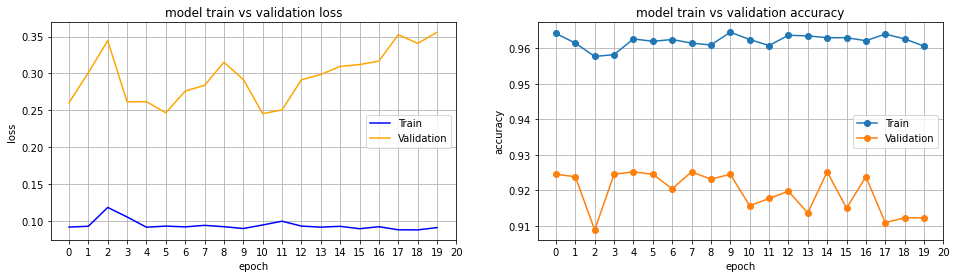


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.485487  0.416905  0.337175

>repeat #3: train accuracy 0.961, test accuracy 0.916
r: 3

>>>>>fit the model on the training data
Epoch 1/20
182/184 [============================>.] - ETA: 0s - loss: 0.0885 - accuracy: 0.9639
Epoch 00001: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 19ms/step - loss: 0.0892 - accuracy: 0.9634 - val_loss: 0.3875 - val_accuracy: 0.9116
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9621
Epoch 00002: val_loss did not improve from 0.19237
184/184 [==============================] - 4s 19ms/step - loss: 0.0963 - accuracy: 0.9621 - val_loss: 0.3571 - val_accuracy: 0.9116
Epoch 3/20
181/184 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9641
Epoch 00003: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 19ms/step - loss: 0.0958 

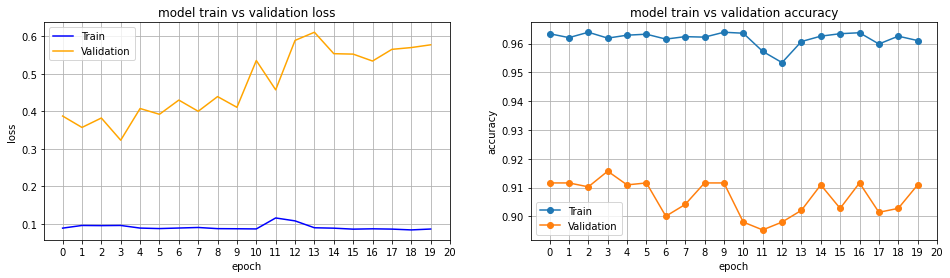


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.485487  0.416905  0.337175  0.343894

>repeat #4: train accuracy 0.961, test accuracy 0.919
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9624 ETA: 0s - loss: 0.0895 - 
Epoch 00001: val_loss did not improve from 0.19237
184/184 [==============================] - 4s 20ms/step - loss: 0.0869 - accuracy: 0.9624 - val_loss: 0.5834 - val_accuracy: 0.9021
Epoch 2/20
183/184 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9611
Epoch 00002: val_loss did not improve from 0.19237
184/184 [==============================] - 3s 18ms/step - loss: 0.0863 - accuracy: 0.9611 - val_loss: 0.5857 - val_accuracy: 0.9035
Epoch 3/20
183/184 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9629
Epoch 00003: val_loss did not improve from 0.19237
184/184 [================

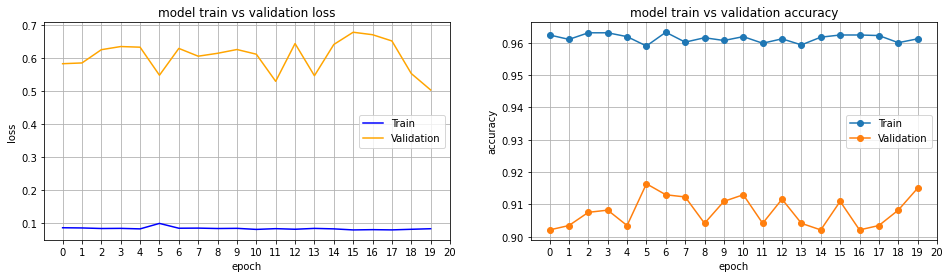


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.485487  0.416905  0.337175  0.343894  0.305776

>repeat #5: train accuracy 0.961, test accuracy 0.918

Train Accuracy: mean 0.960%, std (+/-0.003)
Test Accuracy: mean 0.906%, std (+/-0.019)


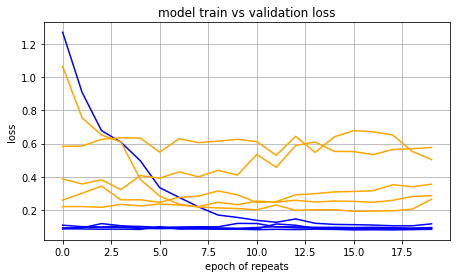

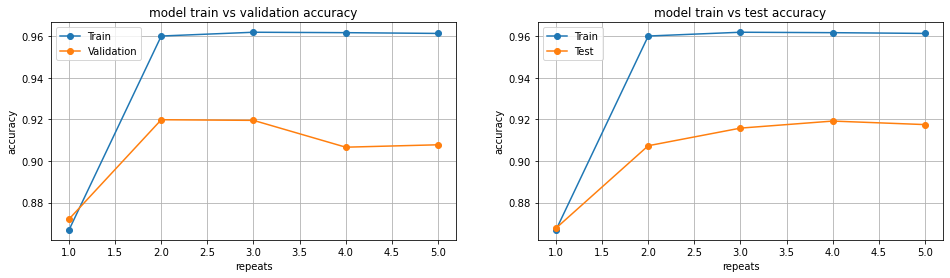

Total Time taken to train the model: 343.5386369228363 seconds, epochs=20, batch_size=32, repeats=5


In [127]:
# run the experiment
start_time = time()
# with tf.device("gpu:0"):
run_experiment_det(model_gru, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [128]:
filepath

'./Model/my_best_model_gru_1_1.hdf5'

In [129]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.956202
Precision: 0.956202
Recall: 0.956202
F1 score: 0.956202

----Test Data---
Accuracy: 0.899898
Precision: 0.899898
Recall: 0.899898
F1 score: 0.899898


In [118]:
#build lstm model
def build_model_gru2():

    model = Sequential()
    model.add(GRU(256, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_gru2.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath

In [119]:
model_gru2, callbacks, filepath = build_model_gru2()
model_gru2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 256)               205056    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 238,726
Trainable params: 238,726
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.9860 - accuracy: 0.5936
Epoch 00001: val_loss improved from inf to 0.75257, saving model to ./Model\my_best_model_gru2.hdf5
184/184 [==============================] - 31s 162ms/step - loss: 0.9860 - accuracy: 0.5936 - val_loss: 0.7526 - val_accuracy: 0.7505
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.8102
Epoch 00002: val_loss improved from 0.75257 to 0.43666, saving model to ./Model\my_best_model_gru2.hdf5
184/184 [==============================] - 29s 160ms/step - loss: 0.4667 - accuracy: 0.8102 - val_loss: 0.4367 - val_accuracy: 0.8736
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9262
Epoch 00003: val_loss improved from 0.43666 to 0.42259, saving model to ./Model\my_best_model_gru2.hdf5
184/184 [==============================] - 29s 160ms/step - loss: 0.1883 - accuracy: 0.926

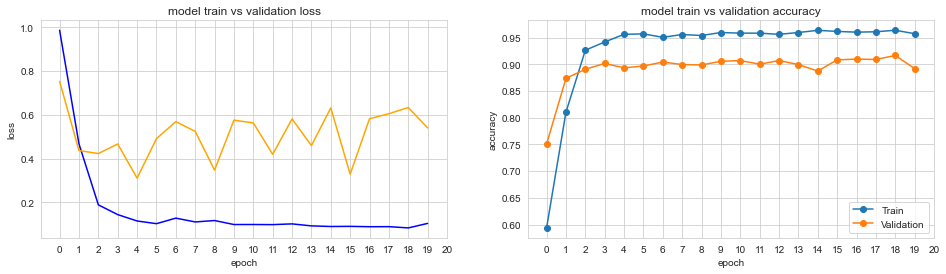


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.298623

>repeat #1: train accuracy 0.957, test accuracy 0.909
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9640
Epoch 00001: val_loss did not improve from 0.31046
184/184 [==============================] - 30s 163ms/step - loss: 0.0918 - accuracy: 0.9640 - val_loss: 0.7049 - val_accuracy: 0.9062
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9633
Epoch 00002: val_loss did not improve from 0.31046
184/184 [==============================] - 30s 162ms/step - loss: 0.0818 - accuracy: 0.9633 - val_loss: 0.7827 - val_accuracy: 0.9109
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9578
Epoch 00003: val_loss did not improve from 0.31046
184/184 [==============================] - 30s 162ms/step - loss: 0.0993 - accuracy: 0.9578 - val_loss: 0.3

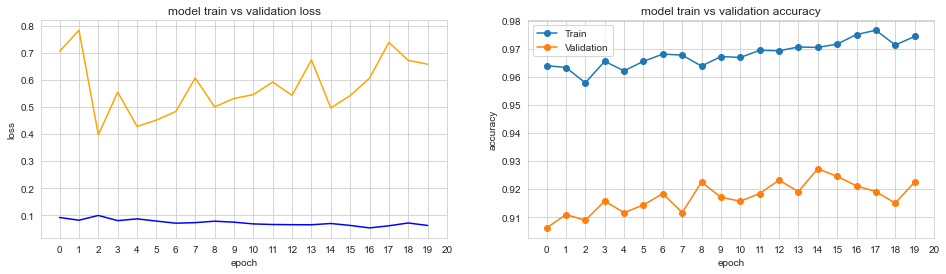


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.298623  0.332923

>repeat #2: train accuracy 0.974, test accuracy 0.924
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9779
Epoch 00001: val_loss did not improve from 0.31046
184/184 [==============================] - 30s 162ms/step - loss: 0.0502 - accuracy: 0.9779 - val_loss: 0.7108 - val_accuracy: 0.9252
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9794
Epoch 00002: val_loss did not improve from 0.31046
184/184 [==============================] - 29s 160ms/step - loss: 0.0486 - accuracy: 0.9794 - val_loss: 0.8027 - val_accuracy: 0.9171
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9832
Epoch 00003: val_loss did not improve from 0.31046
184/184 [==============================] - 30s 161ms/step - loss: 0.0437 - accuracy: 0.

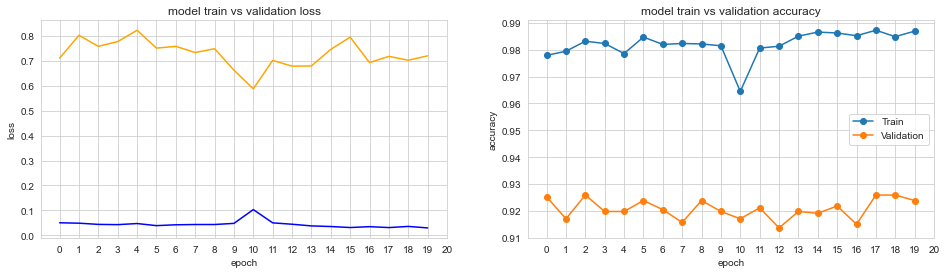


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.298623  0.332923  0.398407

>repeat #3: train accuracy 0.987, test accuracy 0.937
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9850
Epoch 00001: val_loss did not improve from 0.31046
184/184 [==============================] - 29s 159ms/step - loss: 0.0397 - accuracy: 0.9850 - val_loss: 0.7239 - val_accuracy: 0.9218
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9884
Epoch 00002: val_loss did not improve from 0.31046
184/184 [==============================] - 29s 158ms/step - loss: 0.0302 - accuracy: 0.9884 - val_loss: 0.7448 - val_accuracy: 0.9184
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9884
Epoch 00003: val_loss did not improve from 0.31046
184/184 [==============================] - 29s 158ms/step - loss: 0

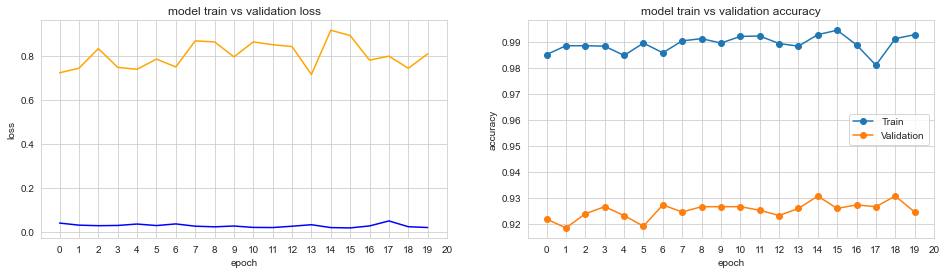


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.298623  0.332923  0.398407  0.505491

>repeat #4: train accuracy 0.993, test accuracy 0.930
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9906
Epoch 00001: val_loss did not improve from 0.31046
184/184 [==============================] - 30s 161ms/step - loss: 0.0306 - accuracy: 0.9906 - val_loss: 0.7825 - val_accuracy: 0.9341
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9942
Epoch 00002: val_loss did not improve from 0.31046
184/184 [==============================] - 29s 160ms/step - loss: 0.0152 - accuracy: 0.9942 - val_loss: 0.8328 - val_accuracy: 0.9313
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9935
Epoch 00003: val_loss did not improve from 0.31046
184/184 [==============================] - 29s 

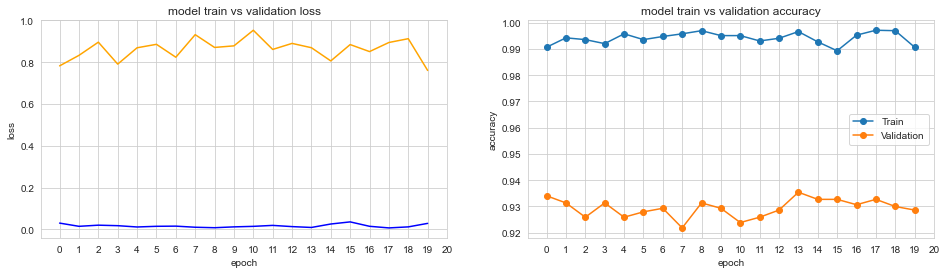


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.298623  0.332923  0.398407  0.505491  0.600591

>repeat #5: train accuracy 0.991, test accuracy 0.929

Train Accuracy: mean 0.980%, std (+/-0.013)
Test Accuracy: mean 0.926%, std (+/-0.009)


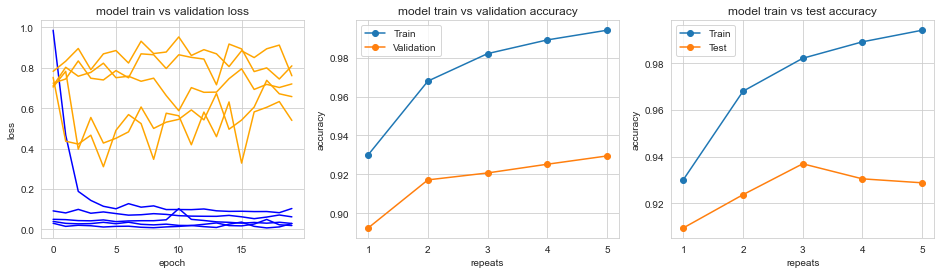

Total Time taken to train the model: 2975.533336162567 seconds, epochs=20, batch_size=32, repeats=5


In [120]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_gru2, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [121]:
filepath

'./Model/my_best_model_gru2.hdf5'

In [122]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)


----Train Data----
Accuracy: 0.944369
Precision: 0.944369
Recall: 0.944369
F1 score: 0.944369

----Test Data---
Accuracy: 0.900577
Precision: 0.900577
Recall: 0.900577
F1 score: 0.900577


In [123]:
#build lstm model
def build_model_gru3():

    model = Sequential()
    model.add(GRU(256, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    filepath = './Model/my_best_model_gru3.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
    callbacks = [checkpoint]
    
    return model, callbacks, filepath

In [124]:
model_gru3 , callbacks, filepath = build_model_gru3()
model_gru3.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 256)               205056    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 272,390
Trainable params: 272,390
Non-trainable params: 0
_________________________________________________________________


r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.0063 - accuracy: 0.5871
Epoch 00001: val_loss improved from inf to 0.82650, saving model to ./Model\my_best_model_gru3.hdf5
184/184 [==============================] - 31s 165ms/step - loss: 1.0063 - accuracy: 0.5871 - val_loss: 0.8265 - val_accuracy: 0.7050
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.7839
Epoch 00002: val_loss improved from 0.82650 to 0.65561, saving model to ./Model\my_best_model_gru3.hdf5
184/184 [==============================] - 30s 162ms/step - loss: 0.5345 - accuracy: 0.7839 - val_loss: 0.6556 - val_accuracy: 0.7811
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9073
Epoch 00003: val_loss improved from 0.65561 to 0.35122, saving model to ./Model\my_best_model_gru3.hdf5
184/184 [==============================] - 31s 171ms/step - loss: 0.2428 - accuracy: 0.907

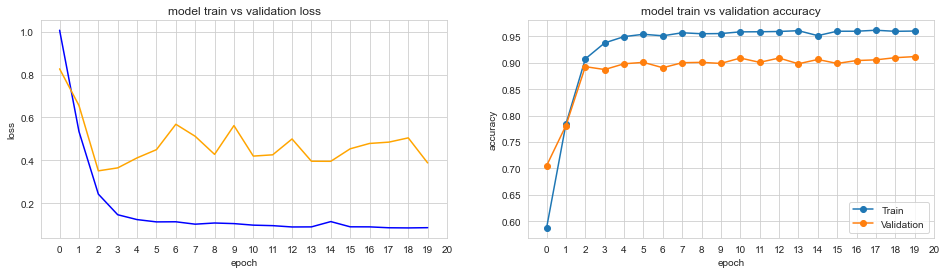


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.402992

>repeat #1: train accuracy 0.960, test accuracy 0.905
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9554
Epoch 00001: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 163ms/step - loss: 0.1005 - accuracy: 0.9554 - val_loss: 0.4787 - val_accuracy: 0.8885
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9611
Epoch 00002: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 161ms/step - loss: 0.0866 - accuracy: 0.9611 - val_loss: 0.4650 - val_accuracy: 0.9062
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9617
Epoch 00003: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 162ms/step - loss: 0.0820 - accuracy: 0.9617 - val_loss: 0.4

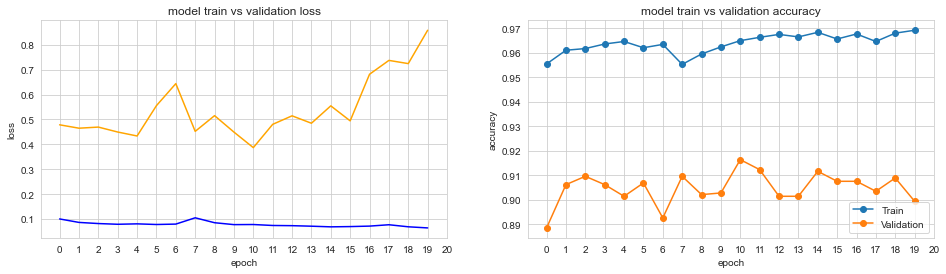


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.402992  0.716778

>repeat #2: train accuracy 0.969, test accuracy 0.905
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9651
Epoch 00001: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 163ms/step - loss: 0.0779 - accuracy: 0.9651 - val_loss: 0.7368 - val_accuracy: 0.9123
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9704
Epoch 00002: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 163ms/step - loss: 0.0670 - accuracy: 0.9704 - val_loss: 0.6543 - val_accuracy: 0.8946
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9714
Epoch 00003: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 162ms/step - loss: 0.0627 - accuracy: 0.

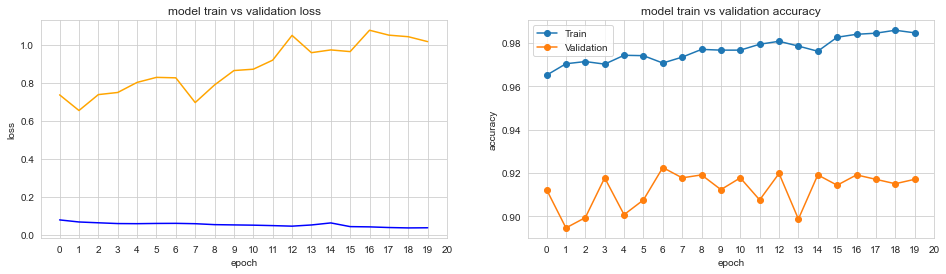


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  0.402992  0.716778  0.598827

>repeat #3: train accuracy 0.985, test accuracy 0.924
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9847
Epoch 00001: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 163ms/step - loss: 0.0404 - accuracy: 0.9847 - val_loss: 1.1007 - val_accuracy: 0.9082
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9794
Epoch 00002: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 163ms/step - loss: 0.0581 - accuracy: 0.9794 - val_loss: 0.5909 - val_accuracy: 0.9300
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9847
Epoch 00003: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 163ms/step - loss: 0

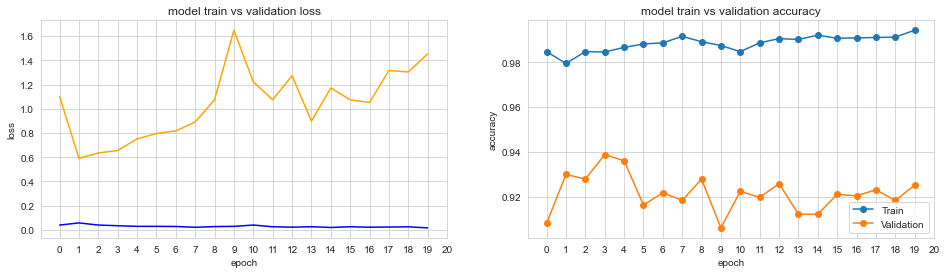


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  0.402992  0.716778  0.598827  0.803854

>repeat #4: train accuracy 0.994, test accuracy 0.928
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9862
Epoch 00001: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 163ms/step - loss: 0.0385 - accuracy: 0.9862 - val_loss: 1.0270 - val_accuracy: 0.9273
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9867
Epoch 00002: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 162ms/step - loss: 0.0372 - accuracy: 0.9867 - val_loss: 1.2128 - val_accuracy: 0.9259
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9929
Epoch 00003: val_loss did not improve from 0.35122
184/184 [==============================] - 30s 

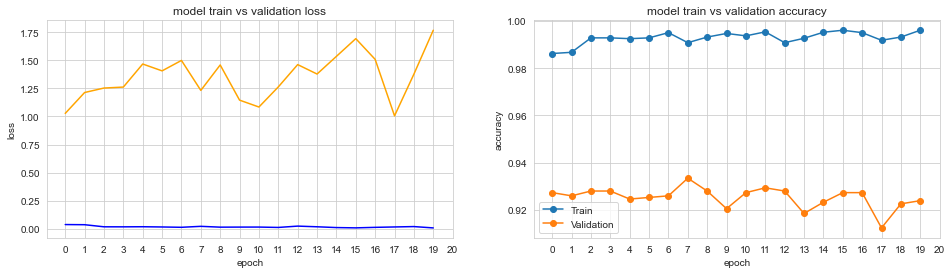


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  0.402992  0.716778  0.598827  0.803854  1.097196

>repeat #5: train accuracy 0.996, test accuracy 0.918

Train Accuracy: mean 0.981%, std (+/-0.014)
Test Accuracy: mean 0.916%, std (+/-0.009)


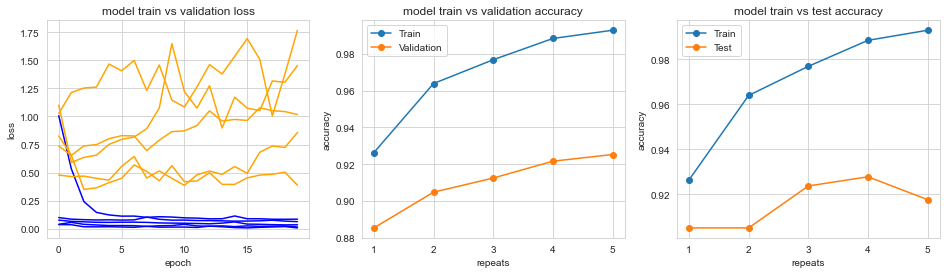

Total Time taken to train the model: 3013.7077980041504 seconds, epochs=20, batch_size=32, repeats=5


In [125]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_gru3, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')



In [126]:
filepath

'./Model/my_best_model_gru3.hdf5'

In [127]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.940152
Precision: 0.940152
Recall: 0.940152
F1 score: 0.940152

----Test Data---
Accuracy: 0.883610
Precision: 0.883610
Recall: 0.883610
F1 score: 0.883610


#### Transformer

In [128]:
input_shape = trainX.shape[1:]
input_shape

(128, 9)

In [129]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-4):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [130]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    epsilon=1e-4
):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, epsilon)

    x = layers.GlobalMaxPooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    
    outputs = layers.Dense(n_outputs, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [131]:

model_transformer = build_model(
    input_shape,
    head_size=128,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.25,
    dropout=0.25,
    epsilon=1e-4
)

model_transformer.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

filepath = './Model/my_best_model_transformer.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                         monitor='val_loss',
                         verbose=1, 
                         save_best_only=True,
                         mode='min')
callbacks = [checkpoint]

    
model_transformer.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 128, 9)      18          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 128, 9)      19977       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.9904 - accuracy: 0.1847
Epoch 00001: val_loss improved from inf to 1.63082, saving model to ./Model\my_best_model_transformer.hdf5
184/184 [==============================] - 60s 317ms/step - loss: 1.9904 - accuracy: 0.1847 - val_loss: 1.6308 - val_accuracy: 0.2257
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 1.6768 - accuracy: 0.2539
Epoch 00002: val_loss improved from 1.63082 to 1.50163, saving model to ./Model\my_best_model_transformer.hdf5
184/184 [==============================] - 58s 314ms/step - loss: 1.6768 - accuracy: 0.2539 - val_loss: 1.5016 - val_accuracy: 0.2835
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 1.5374 - accuracy: 0.2999
Epoch 00003: val_loss improved from 1.50163 to 1.43679, saving model to ./Model\my_best_model_transformer.hdf5
184/184 [==============================] - 61s 332ms/step - loss: 1.5

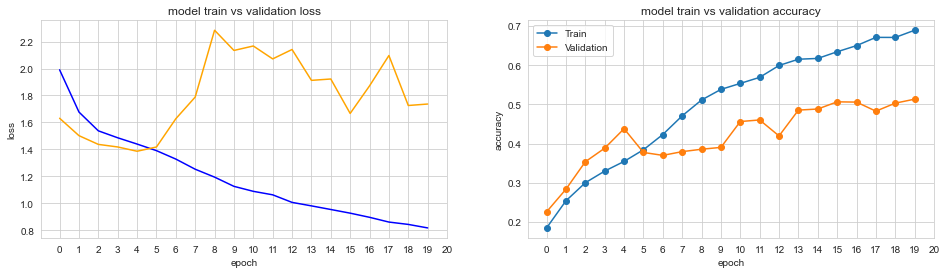


>>>>>evaluating the model on the test data
df_test_losses           0
0  1.791521

>repeat #1: train accuracy 0.689, test accuracy 0.509
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.7082
Epoch 00001: val_loss did not improve from 1.38591
184/184 [==============================] - 60s 328ms/step - loss: 0.7869 - accuracy: 0.7082 - val_loss: 1.5223 - val_accuracy: 0.5527
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.7786 - accuracy: 0.7023
Epoch 00002: val_loss did not improve from 1.38591
184/184 [==============================] - 61s 330ms/step - loss: 0.7786 - accuracy: 0.7023 - val_loss: 1.6718 - val_accuracy: 0.5160
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.7172
Epoch 00003: val_loss did not improve from 1.38591
184/184 [==============================] - 60s 327ms/step - loss: 0.7427 - accuracy: 0.7172 - val_loss: 1.4

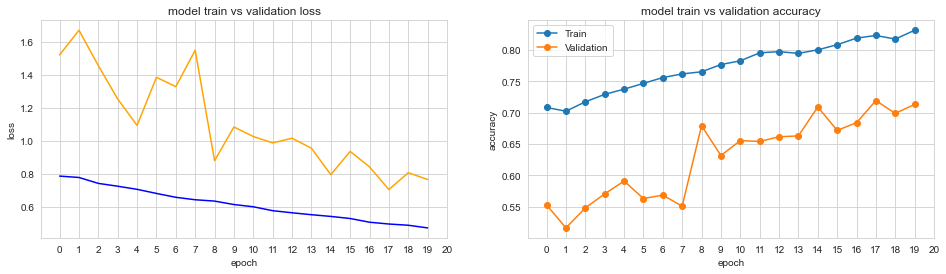


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  1.791521  0.888077

>repeat #2: train accuracy 0.831, test accuracy 0.676
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.8366
Epoch 00001: val_loss improved from 0.70522 to 0.69362, saving model to ./Model\my_best_model_transformer.hdf5
184/184 [==============================] - 58s 314ms/step - loss: 0.4605 - accuracy: 0.8366 - val_loss: 0.6936 - val_accuracy: 0.7267
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.8364
Epoch 00002: val_loss improved from 0.69362 to 0.64928, saving model to ./Model\my_best_model_transformer.hdf5
184/184 [==============================] - 58s 313ms/step - loss: 0.4598 - accuracy: 0.8364 - val_loss: 0.6493 - val_accuracy: 0.7410
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8386
Epoch 00003: val_l

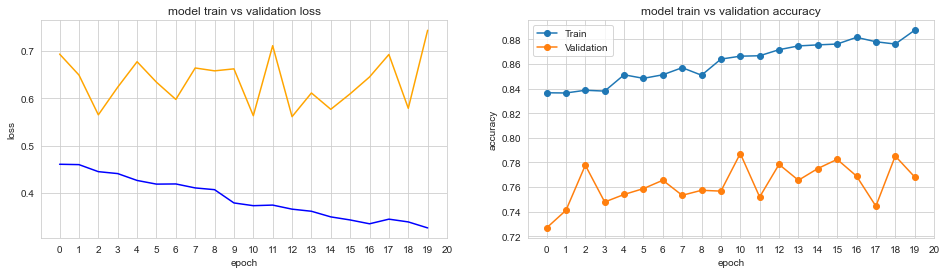


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  1.791521  0.888077  1.011891

>repeat #3: train accuracy 0.887, test accuracy 0.720
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8840
Epoch 00001: val_loss did not improve from 0.56125
184/184 [==============================] - 58s 313ms/step - loss: 0.3215 - accuracy: 0.8840 - val_loss: 0.6371 - val_accuracy: 0.7784
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8817
Epoch 00002: val_loss improved from 0.56125 to 0.52141, saving model to ./Model\my_best_model_transformer.hdf5
184/184 [==============================] - 58s 316ms/step - loss: 0.3299 - accuracy: 0.8817 - val_loss: 0.5214 - val_accuracy: 0.7967
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8900
Epoch 00003: val_loss did not improve from 0.52141
184/184

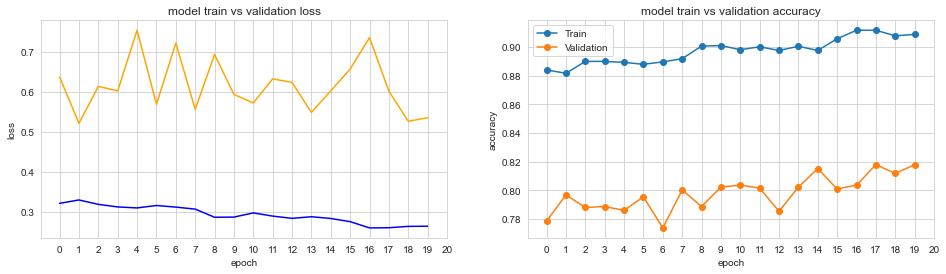


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  1.791521  0.888077  1.011891  0.801489

>repeat #4: train accuracy 0.909, test accuracy 0.784
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9053
Epoch 00001: val_loss did not improve from 0.52141
184/184 [==============================] - 59s 320ms/step - loss: 0.2680 - accuracy: 0.9053 - val_loss: 0.6226 - val_accuracy: 0.8056
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9146
Epoch 00002: val_loss did not improve from 0.52141
184/184 [==============================] - 59s 319ms/step - loss: 0.2480 - accuracy: 0.9146 - val_loss: 0.5320 - val_accuracy: 0.8049
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9136
Epoch 00003: val_loss did not improve from 0.52141
184/184 [==============================] - 59s 

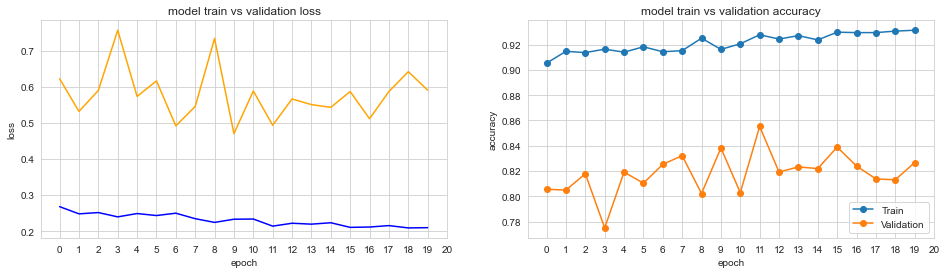


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3         4
0  1.791521  0.888077  1.011891  0.801489  0.971452

>repeat #5: train accuracy 0.931, test accuracy 0.779

Train Accuracy: mean 0.850%, std (+/-0.087)
Test Accuracy: mean 0.694%, std (+/-0.100)


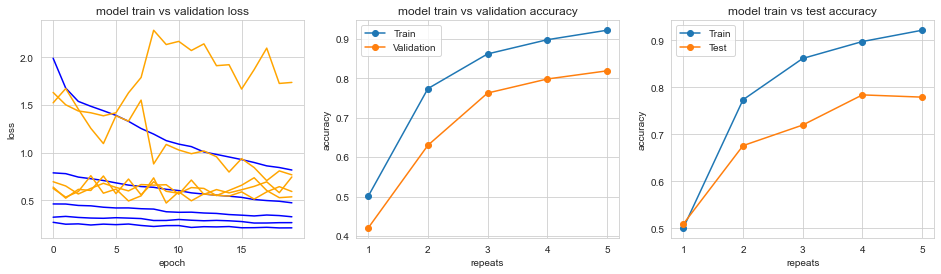

Total Time taken to train the model: 5996.761752128601 seconds, epochs=20, batch_size=32, repeats=5


In [132]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_transformer, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [133]:
filepath

'./Model/my_best_model_transformer.hdf5'

In [134]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.873776
Precision: 0.873776
Recall: 0.873776
F1 score: 0.873776

----Test Data---
Accuracy: 0.799118
Precision: 0.799118
Recall: 0.799118
F1 score: 0.799118


In [137]:
model_transformer_2 = build_model(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=2,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.25,
    dropout=0.25,
    epsilon=1e-4
)

model_transformer_2.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

filepath = './Model/my_best_model_transformer2.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                         monitor='val_loss',
                         verbose=1, 
                         save_best_only=True,
                         mode='min')
callbacks = [checkpoint]

model_transformer_2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 layer_normalization_4 (LayerNo  (None, 128, 9)      18          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 128, 9)      9993        ['layer_normalization_4[0][0]',  
 eadAttention)                                                    'layer_normalization_4[0][0]']  
                                                                                            

r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.7814 - accuracy: 0.2489
Epoch 00001: val_loss improved from inf to 1.48033, saving model to ./Model\my_best_model_transformer2.hdf5
184/184 [==============================] - 44s 233ms/step - loss: 1.7814 - accuracy: 0.2489 - val_loss: 1.4803 - val_accuracy: 0.2876
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 1.5347 - accuracy: 0.3239
Epoch 00002: val_loss improved from 1.48033 to 1.41693, saving model to ./Model\my_best_model_transformer2.hdf5
184/184 [==============================] - 48s 260ms/step - loss: 1.5347 - accuracy: 0.3239 - val_loss: 1.4169 - val_accuracy: 0.2604
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 1.4313 - accuracy: 0.3863
Epoch 00003: val_loss improved from 1.41693 to 1.37167, saving model to ./Model\my_best_model_transformer2.hdf5
184/184 [==============================] - 49s 268ms/step - loss: 

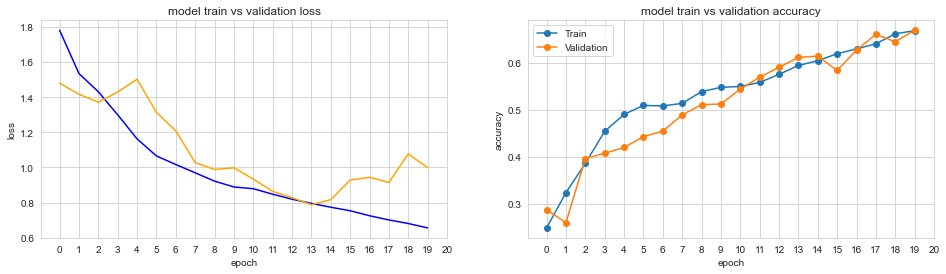


>>>>>evaluating the model on the test data
df_test_losses          0
0  0.72221

>repeat #1: train accuracy 0.669, test accuracy 0.677
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.6382 - accuracy: 0.6771
Epoch 00001: val_loss did not improve from 0.78835
184/184 [==============================] - 42s 226ms/step - loss: 0.6382 - accuracy: 0.6771 - val_loss: 0.8305 - val_accuracy: 0.6764
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.6199 - accuracy: 0.6870
Epoch 00002: val_loss did not improve from 0.78835
184/184 [==============================] - 42s 227ms/step - loss: 0.6199 - accuracy: 0.6870 - val_loss: 0.8148 - val_accuracy: 0.6683
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.6982
Epoch 00003: val_loss improved from 0.78835 to 0.57682, saving model to ./Model\my_best_model_transformer2.hdf5
184/184 [==============================] - 42s 2

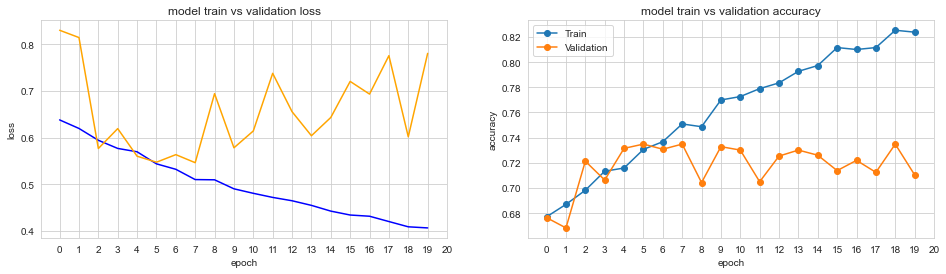


>>>>>evaluating the model on the test data
df_test_losses          0         1
0  0.72221  0.913197

>repeat #2: train accuracy 0.824, test accuracy 0.684
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8339
Epoch 00001: val_loss did not improve from 0.54643
184/184 [==============================] - 43s 236ms/step - loss: 0.3920 - accuracy: 0.8339 - val_loss: 0.6206 - val_accuracy: 0.7376
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8388
Epoch 00002: val_loss did not improve from 0.54643
184/184 [==============================] - 43s 233ms/step - loss: 0.3906 - accuracy: 0.8388 - val_loss: 0.8438 - val_accuracy: 0.7022
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8398
Epoch 00003: val_loss did not improve from 0.54643
184/184 [==============================] - 43s 232ms/step - loss: 0.3795 - accuracy: 0.83

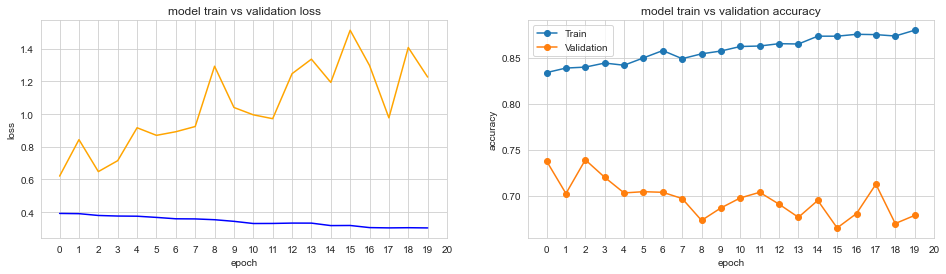


>>>>>evaluating the model on the test data
df_test_losses          0         1         2
0  0.72221  0.913197  1.262619

>repeat #3: train accuracy 0.880, test accuracy 0.657
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8810
Epoch 00001: val_loss did not improve from 0.54643
184/184 [==============================] - 41s 221ms/step - loss: 0.2900 - accuracy: 0.8810 - val_loss: 1.4157 - val_accuracy: 0.6710
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8798
Epoch 00002: val_loss did not improve from 0.54643
184/184 [==============================] - 41s 222ms/step - loss: 0.2933 - accuracy: 0.8798 - val_loss: 1.2743 - val_accuracy: 0.6846
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.8828
Epoch 00003: val_loss did not improve from 0.54643
184/184 [==============================] - 41s 221ms/step - loss: 0.2

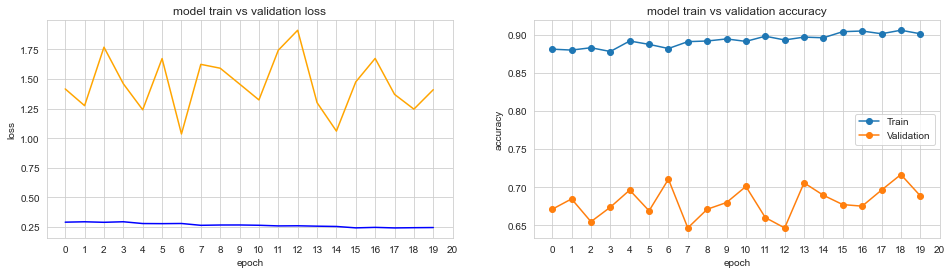


>>>>>evaluating the model on the test data
df_test_losses          0         1         2         3
0  0.72221  0.913197  1.262619  1.661057

>repeat #4: train accuracy 0.901, test accuracy 0.670
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9065
Epoch 00001: val_loss did not improve from 0.54643
184/184 [==============================] - 41s 221ms/step - loss: 0.2437 - accuracy: 0.9065 - val_loss: 1.5081 - val_accuracy: 0.6662
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9046
Epoch 00002: val_loss did not improve from 0.54643
184/184 [==============================] - 41s 222ms/step - loss: 0.2398 - accuracy: 0.9046 - val_loss: 1.5459 - val_accuracy: 0.6696
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9049
Epoch 00003: val_loss did not improve from 0.54643
184/184 [==============================] - 41s 22

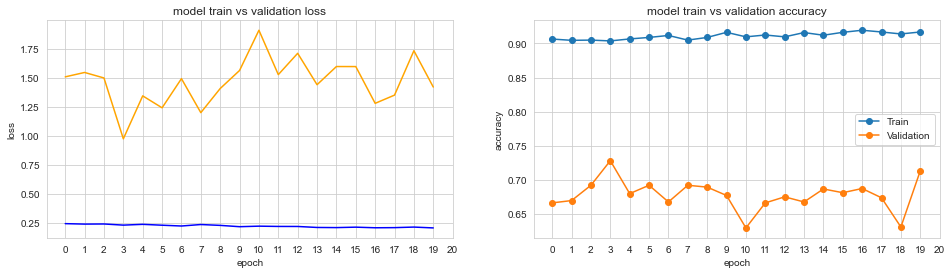


>>>>>evaluating the model on the test data
df_test_losses          0         1         2         3         4
0  0.72221  0.913197  1.262619  1.661057  1.805618

>repeat #5: train accuracy 0.917, test accuracy 0.663

Train Accuracy: mean 0.838%, std (+/-0.090)
Test Accuracy: mean 0.670%, std (+/-0.010)


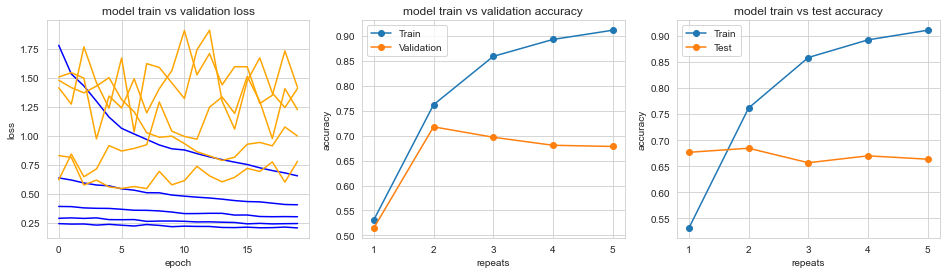

Total Time taken to train the model: 4219.41096329689 seconds, epochs=20, batch_size=32, repeats=5


In [138]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_transformer_2, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')



In [139]:
filepath

'./Model/my_best_model_transformer2.hdf5'

In [140]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.749864
Precision: 0.749864
Recall: 0.749864
F1 score: 0.749864

----Test Data---
Accuracy: 0.709196
Precision: 0.709196
Recall: 0.709196
F1 score: 0.709196


In [ ]:
batch_size = 64

In [141]:
model_transformer_3 = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.25,
    dropout=0.25,
    epsilon=1e-4
)

model_transformer_3.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

filepath = './Model/my_best_model_transformer3.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                         monitor='val_loss',
                         verbose=1, 
                         save_best_only=True,
                         mode='min')
callbacks = [checkpoint]

model_transformer_3.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 128, 9)      18          ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 128, 9)      39945       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.7397 - accuracy: 0.2450
Epoch 00001: val_loss improved from inf to 1.45029, saving model to ./Model\my_best_model_transformer3.hdf5
184/184 [==============================] - 98s 525ms/step - loss: 1.7397 - accuracy: 0.2450 - val_loss: 1.4503 - val_accuracy: 0.4126
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 1.4885 - accuracy: 0.3406
Epoch 00002: val_loss improved from 1.45029 to 1.41539, saving model to ./Model\my_best_model_transformer3.hdf5
184/184 [==============================] - 96s 524ms/step - loss: 1.4885 - accuracy: 0.3406 - val_loss: 1.4154 - val_accuracy: 0.4364
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 1.4085 - accuracy: 0.3647
Epoch 00003: val_loss improved from 1.41539 to 1.34979, saving model to ./Model\my_best_model_transformer3.hdf5
184/184 [==============================] - 96s 521ms/step - loss: 

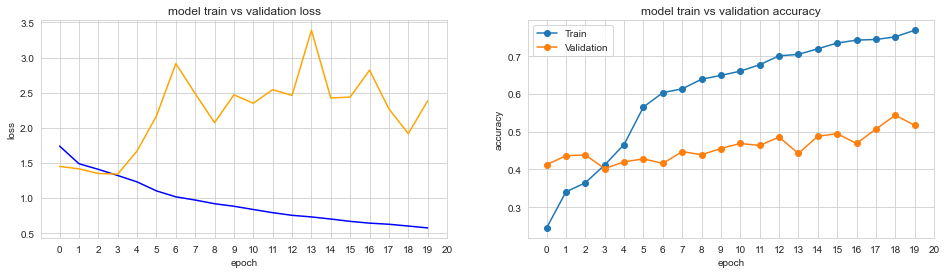


>>>>>evaluating the model on the test data
df_test_losses           0
0  2.573795

>repeat #1: train accuracy 0.769, test accuracy 0.517
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.5716 - accuracy: 0.7691
Epoch 00001: val_loss did not improve from 1.34083
184/184 [==============================] - 95s 517ms/step - loss: 0.5716 - accuracy: 0.7691 - val_loss: 1.7906 - val_accuracy: 0.5608
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.7849
Epoch 00002: val_loss did not improve from 1.34083
184/184 [==============================] - 102s 557ms/step - loss: 0.5413 - accuracy: 0.7849 - val_loss: 2.2585 - val_accuracy: 0.5303
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.5302 - accuracy: 0.7951
Epoch 00003: val_loss did not improve from 1.34083
184/184 [==============================] - 111s 605ms/step - loss: 0.5302 - accuracy: 0.7951 - val_loss: 1

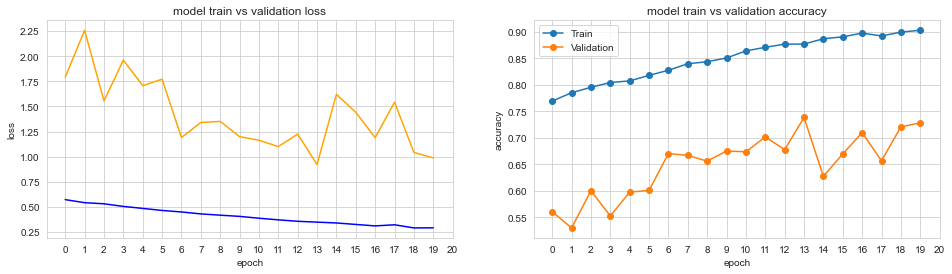


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  2.573795  0.995888

>repeat #2: train accuracy 0.903, test accuracy 0.718
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.9046
Epoch 00001: val_loss did not improve from 0.92141
184/184 [==============================] - 131s 712ms/step - loss: 0.2885 - accuracy: 0.9046 - val_loss: 1.0112 - val_accuracy: 0.7335
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.9102
Epoch 00002: val_loss did not improve from 0.92141
184/184 [==============================] - 133s 722ms/step - loss: 0.2759 - accuracy: 0.9102 - val_loss: 1.1068 - val_accuracy: 0.7043
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.9070
Epoch 00003: val_loss did not improve from 0.92141
184/184 [==============================] - 122s 663ms/step - loss: 0.2767 - accuracy:

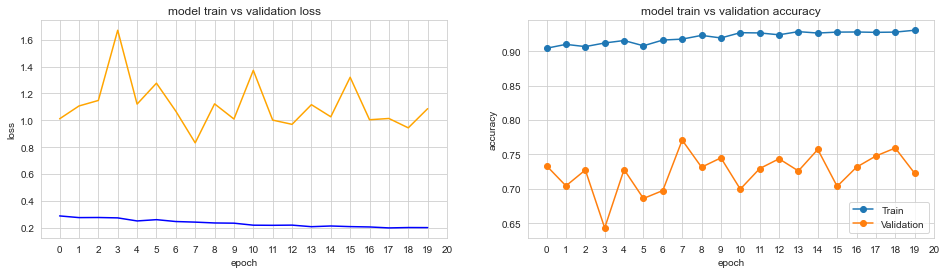


>>>>>evaluating the model on the test data
df_test_losses           0         1         2
0  2.573795  0.995888  1.547541

>repeat #3: train accuracy 0.931, test accuracy 0.684
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9333
Epoch 00001: val_loss did not improve from 0.83220
184/184 [==============================] - 124s 673ms/step - loss: 0.1925 - accuracy: 0.9333 - val_loss: 0.9309 - val_accuracy: 0.7675
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9315
Epoch 00002: val_loss did not improve from 0.83220
184/184 [==============================] - 117s 635ms/step - loss: 0.1863 - accuracy: 0.9315 - val_loss: 0.9336 - val_accuracy: 0.7512
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9328
Epoch 00003: val_loss did not improve from 0.83220
184/184 [==============================] - 125s 679ms/step - loss

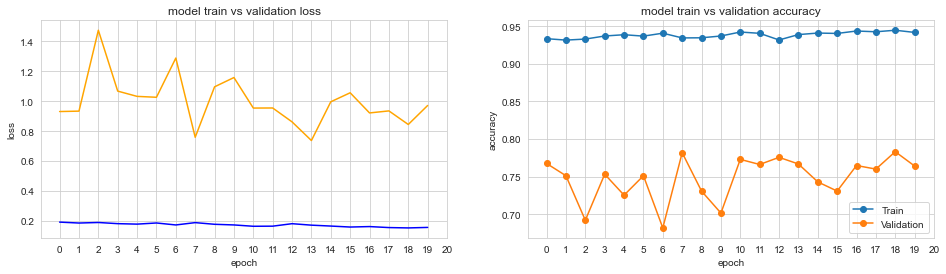


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3
0  2.573795  0.995888  1.547541  1.502273

>repeat #4: train accuracy 0.942, test accuracy 0.691
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9410
Epoch 00001: val_loss did not improve from 0.73732
184/184 [==============================] - 133s 720ms/step - loss: 0.1615 - accuracy: 0.9410 - val_loss: 1.0013 - val_accuracy: 0.7559
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9425
Epoch 00002: val_loss did not improve from 0.73732
184/184 [==============================] - 127s 689ms/step - loss: 0.1550 - accuracy: 0.9425 - val_loss: 1.0015 - val_accuracy: 0.7505
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9381
Epoch 00003: val_loss did not improve from 0.73732
184/184 [==============================] - 14

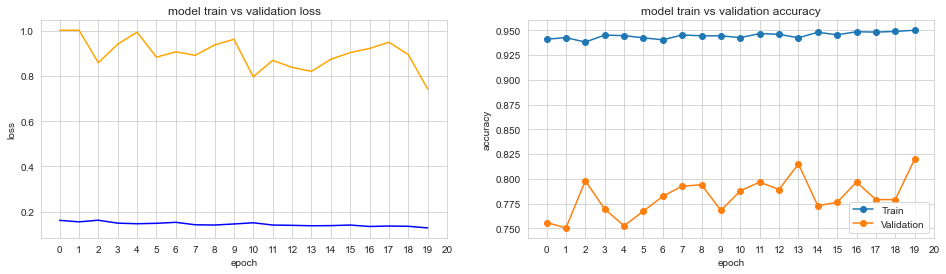


>>>>>evaluating the model on the test data
df_test_losses           0         1         2         3        4
0  2.573795  0.995888  1.547541  1.502273  1.25493

>repeat #5: train accuracy 0.950, test accuracy 0.748

Train Accuracy: mean 0.899%, std (+/-0.067)
Test Accuracy: mean 0.672%, std (+/-0.081)


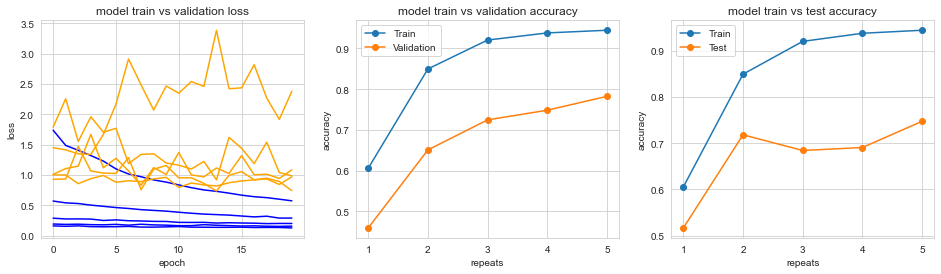

Total Time taken to train the model: 11639.080746650696 seconds, epochs=20, batch_size=32, repeats=5


In [142]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_transformer_3, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [143]:
filepath

'./Model/my_best_model_transformer3.hdf5'

In [144]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.801279
Precision: 0.801279
Recall: 0.801279
F1 score: 0.801279

----Test Data---
Accuracy: 0.710214
Precision: 0.710214
Recall: 0.710214
F1 score: 0.710214


In [151]:
model_transformer_4 = build_model(
    input_shape,
    head_size=150,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[32],
    mlp_dropout=0.3,
    dropout=0.3,
    epsilon=1e-3
)

model_transformer_4.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

filepath = './Model/my_best_model_transformer4.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                         monitor='val_loss',
                         verbose=1, 
                         save_best_only=True,
                         mode='min')
callbacks = [checkpoint]


model_transformer_4.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 layer_normalization_20 (LayerN  (None, 128, 9)      18          ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_10 (Multi  (None, 128, 9)      23409       ['layer_normalization_20[0][0]', 
 HeadAttention)                                                   'layer_normalization_20[0][0]'] 
                                                                                            

r: 0

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.7131 - accuracy: 0.2727
Epoch 00001: val_loss improved from inf to 2.13249, saving model to ./Model\my_best_model_transformer4.hdf5
184/184 [==============================] - 120s 644ms/step - loss: 1.7131 - accuracy: 0.2727 - val_loss: 2.1325 - val_accuracy: 0.3868
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 1.3195 - accuracy: 0.4195
Epoch 00002: val_loss improved from 2.13249 to 0.97797, saving model to ./Model\my_best_model_transformer4.hdf5
184/184 [==============================] - 142s 771ms/step - loss: 1.3195 - accuracy: 0.4195 - val_loss: 0.9780 - val_accuracy: 0.5479
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.9860 - accuracy: 0.5259
Epoch 00003: val_loss improved from 0.97797 to 0.79344, saving model to ./Model\my_best_model_transformer4.hdf5
184/184 [==============================] - 135s 733ms/step - los

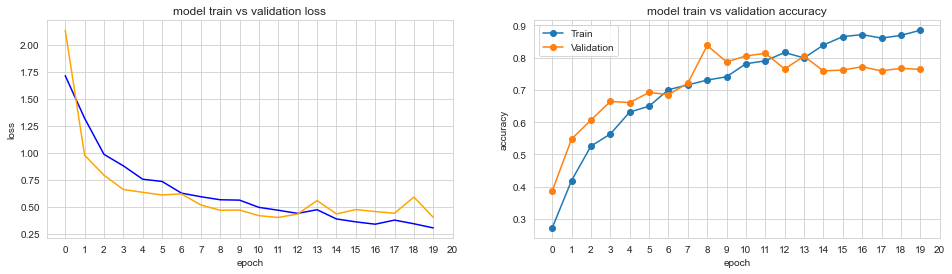


>>>>>evaluating the model on the test data
df_test_losses           0
0  0.512664

>repeat #1: train accuracy 0.885, test accuracy 0.762
r: 1

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8851
Epoch 00001: val_loss improved from 0.40300 to 0.36304, saving model to ./Model\my_best_model_transformer4.hdf5
184/184 [==============================] - 151s 819ms/step - loss: 0.3047 - accuracy: 0.8851 - val_loss: 0.3630 - val_accuracy: 0.8443
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8883
Epoch 00002: val_loss did not improve from 0.36304
184/184 [==============================] - 144s 783ms/step - loss: 0.2860 - accuracy: 0.8883 - val_loss: 0.4046 - val_accuracy: 0.8715
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8859
Epoch 00003: val_loss did not improve from 0.36304
184/184 [==============================] - 1

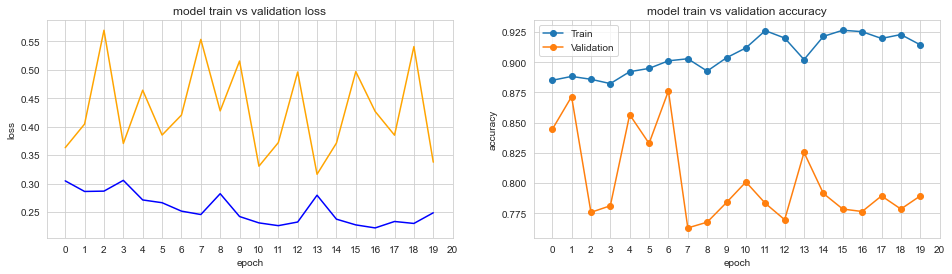


>>>>>evaluating the model on the test data
df_test_losses           0         1
0  0.512664  0.480588

>repeat #2: train accuracy 0.914, test accuracy 0.761
r: 2

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9228
Epoch 00001: val_loss did not improve from 0.31628
184/184 [==============================] - 134s 727ms/step - loss: 0.2310 - accuracy: 0.9228 - val_loss: 0.3606 - val_accuracy: 0.8865
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9277
Epoch 00002: val_loss did not improve from 0.31628
184/184 [==============================] - 134s 726ms/step - loss: 0.2125 - accuracy: 0.9277 - val_loss: 0.3545 - val_accuracy: 0.8232
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9235
Epoch 00003: val_loss did not improve from 0.31628
184/184 [==============================] - 134s 728ms/step - loss: 0.2186 - accuracy:

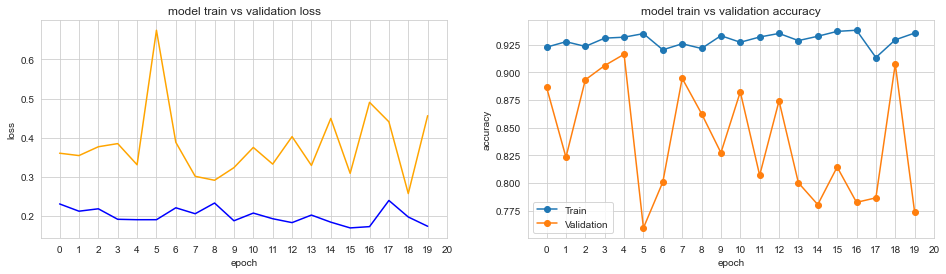


>>>>>evaluating the model on the test data
df_test_losses           0         1        2
0  0.512664  0.480588  0.64276

>repeat #3: train accuracy 0.936, test accuracy 0.734
r: 3

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9335
Epoch 00001: val_loss did not improve from 0.25752
184/184 [==============================] - 129s 699ms/step - loss: 0.1938 - accuracy: 0.9335 - val_loss: 0.5382 - val_accuracy: 0.7933
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.2108 - accuracy: 0.9282
Epoch 00002: val_loss did not improve from 0.25752
184/184 [==============================] - 128s 698ms/step - loss: 0.2108 - accuracy: 0.9282 - val_loss: 0.3343 - val_accuracy: 0.8491
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9286
Epoch 00003: val_loss did not improve from 0.25752
184/184 [==============================] - 128s 699ms/step - loss: 

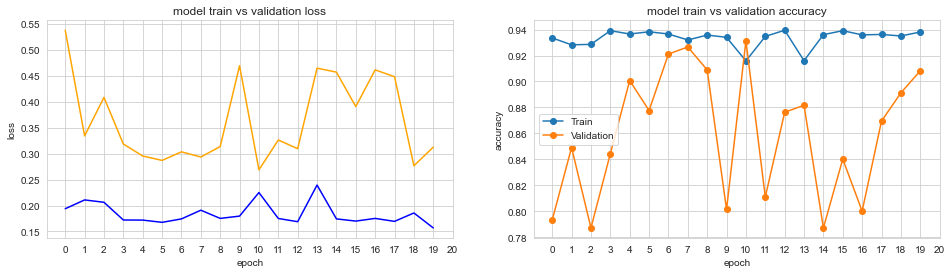


>>>>>evaluating the model on the test data
df_test_losses           0         1        2        3
0  0.512664  0.480588  0.64276  0.79056

>repeat #4: train accuracy 0.938, test accuracy 0.845
r: 4

>>>>>fit the model on the training data
Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9386
Epoch 00001: val_loss did not improve from 0.25752
184/184 [==============================] - 135s 733ms/step - loss: 0.1648 - accuracy: 0.9386 - val_loss: 0.4266 - val_accuracy: 0.8015
Epoch 2/20
184/184 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9361
Epoch 00002: val_loss did not improve from 0.25752
184/184 [==============================] - 131s 714ms/step - loss: 0.1728 - accuracy: 0.9361 - val_loss: 0.3660 - val_accuracy: 0.8613
Epoch 3/20
184/184 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.9340
Epoch 00003: val_loss did not improve from 0.25752
184/184 [==============================] - 166s 9

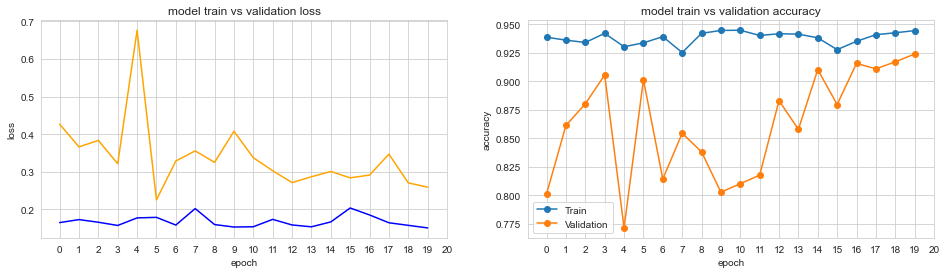


>>>>>evaluating the model on the test data
df_test_losses           0         1        2        3         4
0  0.512664  0.480588  0.64276  0.79056  0.581165

>repeat #5: train accuracy 0.944, test accuracy 0.851

Train Accuracy: mean 0.923%, std (+/-0.022)
Test Accuracy: mean 0.790%, std (+/-0.048)


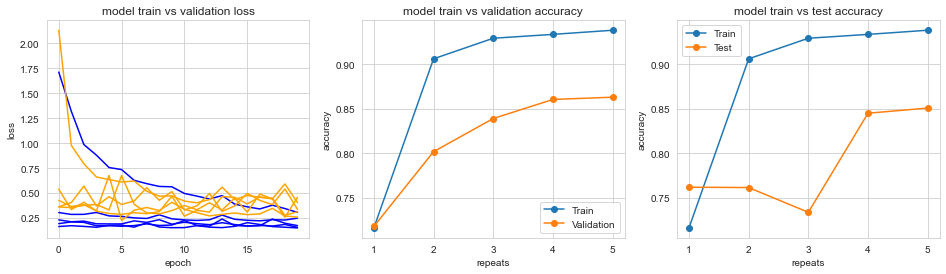

Total Time taken to train the model: 13812.274500846863 seconds, epochs=20, batch_size=32, repeats=5


In [152]:
# run the experiment
start_time = time()
with tf.device("cpu:0"):
    run_experiment_det(model_transformer_4, callbacks, repeats=n_repeats)
    
print(f'Total Time taken to train the model: {time() - start_time} seconds, epochs={epochs}, batch_size={batch_size}, repeats={n_repeats}')


In [153]:
filepath

'./Model/my_best_model_transformer4.hdf5'

In [154]:
# display model metrics
with tf.device("cpu:0"):
    print('----Train Data----')
    display_metrics_file(filepath, trainX, trainy)
    print('')
    print('----Test Data---')
    display_metrics_file(filepath, testX, testy)

----Train Data----
Accuracy: 0.905060
Precision: 0.905060
Recall: 0.905060
F1 score: 0.905060

----Test Data---
Accuracy: 0.852732
Precision: 0.852732
Recall: 0.852732
F1 score: 0.852732


### Result Analysis

This section is done after saving the training log created above by the best performing model to respective text files as Transformer_log.txt, lstm_log.txt, gru_log.txt

In [3]:
import numpy as np
import re
from itertools import chain

# function read the log file and extract the loss and accuracy values 
def GetAccuracy(file):
    str_to_search='step - loss: ([0-9.]+) - accuracy: ([0-9.]+) - val_loss: ([0-9.]+) - val_accuracy: ([0-9.]+)'
    fT=open(file)
    result=list()
    
    def tofloat(x):
        return float(x)
    
    for line in fT:
        line = line.rstrip()

        x = re.findall(str_to_search, line)
        if len(x) > 0:
            result.append(x)  
    
    
    

    result=list(chain.from_iterable(result))
    result=np.array(result, dtype=float)

    return result

In [4]:
import matplotlib.pyplot as plt
# common function to summarize scores in detail
def plot_history_log(history):
    
    
    # plot train and validation loss across multiple runs
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(history[0], color='blue', label='Train')
    plt.plot(history[2], color='orange', label='Validation')
    plt.title('model train vs validation loss')
    plt.xticks(np.arange(0,len(history[0])+1, step=5))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend()
    
    plt.subplot(1,2,2)
    # plot of train and validation scores vs tree depth
    plt.plot(history[1], color='blue', label='Train') #'-o'
    plt.plot(history[3] , color='orange', label='Validation') #'-o'
    plt.title('model train vs validation accuracy')
    plt.xticks(np.arange(0,len(history[0])+1, step=5))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
   
    plt.grid()
    plt.show()

In [6]:
# common function to summarize scores in detail
def plot_combined_history(transformer, lstm, gru):
    
#     a=np.arange(0,int(len(transformer[0])/2)-1, step=2)
#     b=np.arange(int(len(transformer[0])/2), int(len(transformer[0]))+1, step=5)
#     ticks=np.concatenate([a,b])
    ticks=np.arange(0,len(transformer[0])+1, step=5)
    
    # plot train and validation loss across multiple runs
    plt.figure(figsize=(16,6))
#     plt.subplot(1,2,1)
    plt.plot(transformer[0], color='green', label='Transformer Train')
    plt.plot(transformer[2], color='green', label='Transformer Validation',linestyle='dashed', alpha=0.6)
    
    plt.plot(lstm[0], color='red', label='LSTM Train')
    plt.plot(lstm[2], color='red', label='LSTM Validation',linestyle='dashed', alpha=0.6)

    plt.plot(gru[0], color='blue', label='GRU Train')
    plt.plot(gru[2], color='blue', label='GRU Validation', linestyle='dashed',alpha=0.6)

    
    plt.title('model train vs validation loss')
    plt.xticks(ticks)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,6))
#     plt.subplot(1,2,2)
    # plot of train and validation scores vs tree depth
    plt.plot(transformer[1],  color='green', label='Transformer Train') #'-o'
    plt.plot(transformer[3] , color='green',label='Transformer Validation', linestyle='dashed', alpha=0.6) #'-o',
    
    plt.plot(lstm[1],  color='red', label='LSTM Train') #'-o'
    plt.plot(lstm[3] , color='red',label='LSTM Validation', linestyle='dashed', alpha=0.6) #'-o',

    plt.plot(gru[1],  color='blue', label='GRU Train') #'-o'
    plt.plot(gru[3] , color='blue',label='GRU Validation', linestyle='dashed', alpha=0.6) #'-o',

    
    plt.title('model train vs validation accuracy')
    plt.xticks(ticks)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
   
    plt.grid()
    plt.show()


#### Transformer Model

In [5]:
transformer_result=GetAccuracy('./Log/transformer_log.txt')
transformer_resultT=np.transpose(transformer_result)
plot_history_log(transformer_resultT)

#### LSTM Model

In [7]:
lstm_result=GetAccuracy('./Log/lstm_log.txt')
lstm_resultT=np.transpose(lstm_result)
plot_history_log(lstm_resultT)

#### GRU Model

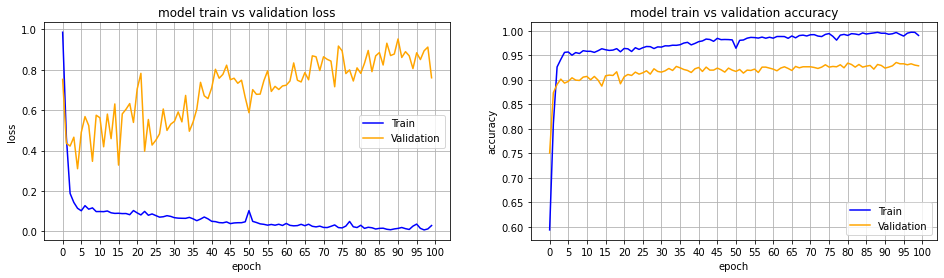

In [8]:
gru_result=GetAccuracy('./Log/gru_log.txt')
gru_resultT=np.transpose(gru_result)
plot_history_log(gru_resultT)

### Model Training Comparison

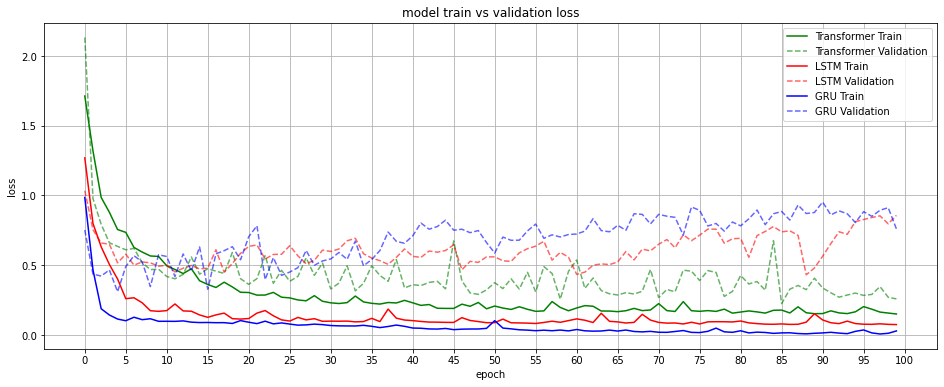

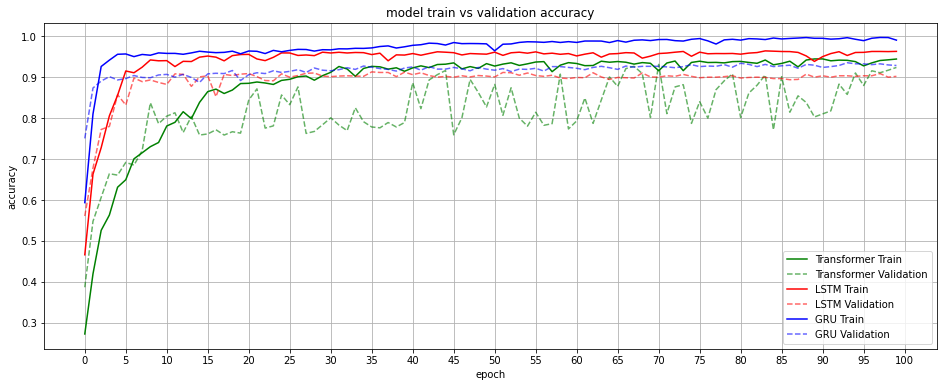

In [9]:
plot_combined_history(transformer_resultT, lstm_resultT ,gru_resultT)